# Import

In [67]:
from boruta import BorutaPy
from catboost import CatBoostClassifier
from IPython.display import Image
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tabulate import tabulate
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns

## Funções de suporte

In [3]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 18
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None

In [4]:
jupyter_settings()

In [4]:
def cross_validation(x, y, kfold, model, model_name, verbose = False):
    skf = StratifiedKFold(n_splits = kfold)
    k = 1
    accuracy = []
    precision = []
    recall = []
    f1score = []
    rocauc = []
    for train_index, valid_index in skf.split(x, y):
        if verbose:
            print('Kfold:', k)
        k += 1

        # Data split
        xtrain, xvalid = x.iloc[train_index], x.iloc[valid_index]
        ytrain, yvalid = y.iloc[train_index], y.iloc[valid_index]

        # Model training
        model.fit(xtrain, ytrain)

        # Prediction
        prediction = model.predict(xvalid)

        # Performance
        accuracy.append(metrics.accuracy_score(yvalid, prediction))
        precision.append(metrics.precision_score(yvalid, prediction))
        recall.append(metrics.recall_score(yvalid, prediction))
        f1score.append(metrics.f1_score(yvalid, prediction))
        rocauc.append(metrics.roc_auc_score(yvalid, prediction))
    return pd.DataFrame({'Model': model_name,
                         'Accuracy': str(round(np.mean(accuracy), 2)) + ' +- ' + str(round(np.std(accuracy), 2)),
                         'Precision': str(round(np.mean(precision), 2)) + ' +- ' + str(round(np.std(precision), 2)),
                         'Recall': str(round(np.mean(recall), 2)) + ' +- ' + str(round(np.std(recall), 2)),
                         'f1-score': str(round(np.mean(f1score), 2)) + ' +- ' + str(round(np.std(f1score), 2)),
                         'ROC-AUC': str(round(np.mean(rocauc), 2)) + ' +- ' + str(round(np.std(rocauc), 2))}, index = [0])

In [5]:
def cramerV(x, y):
    cm = pd.crosstab(x, y).values# Confusion matrix
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]# scipy.stats
    phi2 = chi2/n
    
    # Bias correction
    phi2corr = max(0, phi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt(phi2corr/(min(kcorr-1, rcorr-1)))

## Importar dados

In [5]:
df_raw = pd.read_csv('data/cardio_train.csv', sep = ';')

# 1 Descrição dos dados

In [6]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [7]:
df1 = df1.rename(columns = {'age': 'age_days', 'ap_hi': 'psys', 'ap_lo': 'pdia'})

## 1.2 Dimensão dos dados

In [8]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 70000
Número de colunas: 13


## 1.3 Tipos dos dados

In [9]:
df1.dtypes

id               int64
age_days         int64
gender           int64
height           int64
weight         float64
psys             int64
pdia             int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4 Tratar os NAs

In [10]:
df1.isna().sum()

id             0
age_days       0
gender         0
height         0
weight         0
psys           0
pdia           0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.5 Estatística descritiva

In [11]:
num_attributes = df1[['age_days', 'height', 'weight', 'psys', 'pdia']]
cat_attributes = df1[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]

### 1.5.1 Atributos numéricos

In [12]:
# Tendência central - média, mediana
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contatenar
m = pd.concat([d1, d2, d3, tc1, tc2, d4, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [13]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age_days,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
1,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
2,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
3,psys,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
4,pdia,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585


### 1.5.2 Atributos categóricos

In [14]:
cat_attributes.apply(lambda x: len(x.unique()))

gender         2
cholesterol    3
gluc           3
smoke          2
alco           2
active         2
cardio         2
dtype: int64

<AxesSubplot:>

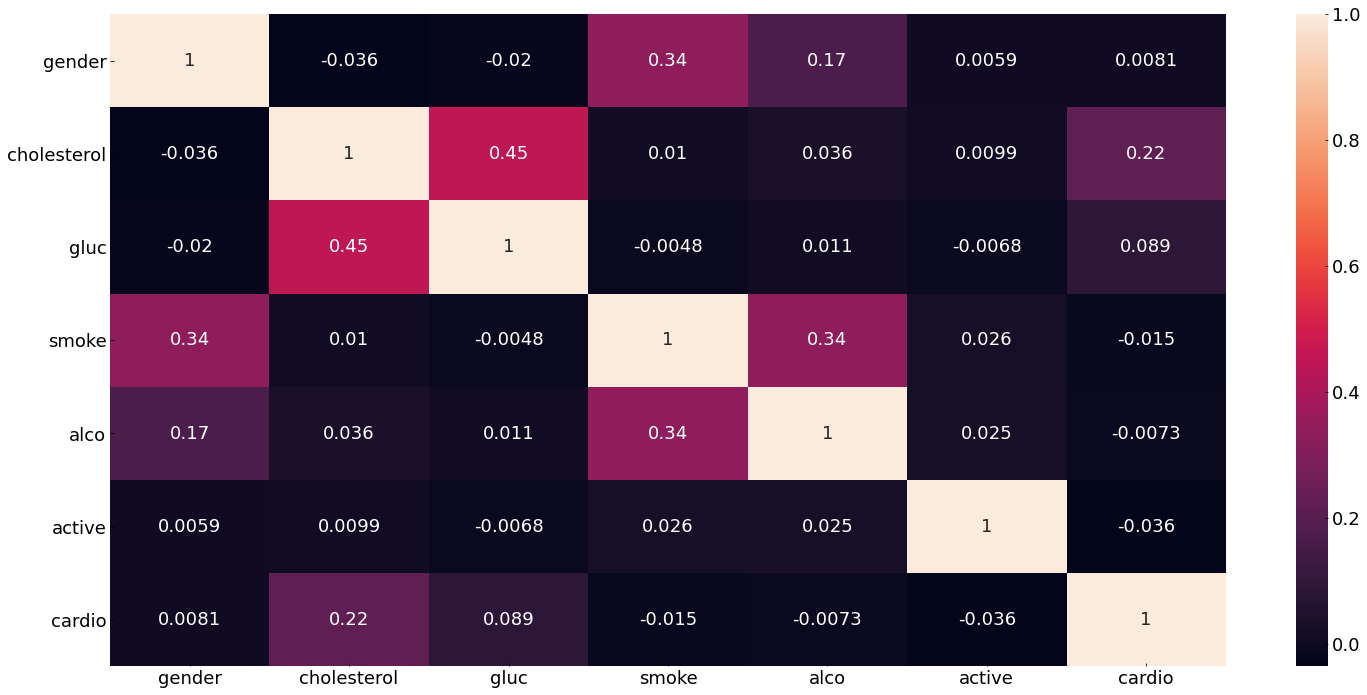

In [15]:
correlation = cat_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

## 1.6 Outliers

In [16]:
# 98,1% dos dados passam pelo filtro

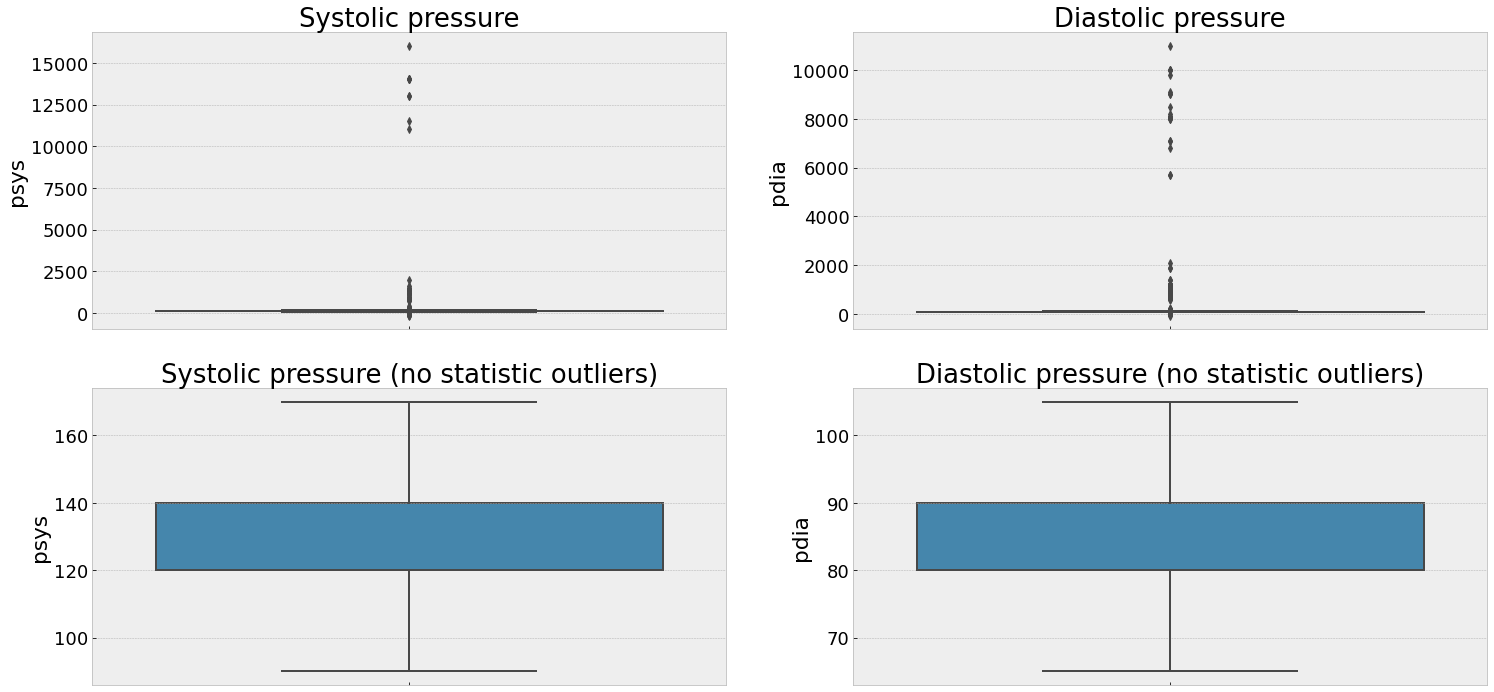

In [17]:
plt.subplot(221)
sns.boxplot(y = 'psys', data = df1)
plt.title('Systolic pressure')

plt.subplot(222)
sns.boxplot(y = 'pdia', data = df1)
plt.title('Diastolic pressure')

plt.subplot(223)
sns.boxplot(y = 'psys', data = df1, showfliers = False)
plt.title('Systolic pressure (no statistic outliers)')

plt.subplot(224)
sns.boxplot(y = 'pdia', data = df1, showfliers = False)
plt.title('Diastolic pressure (no statistic outliers)');

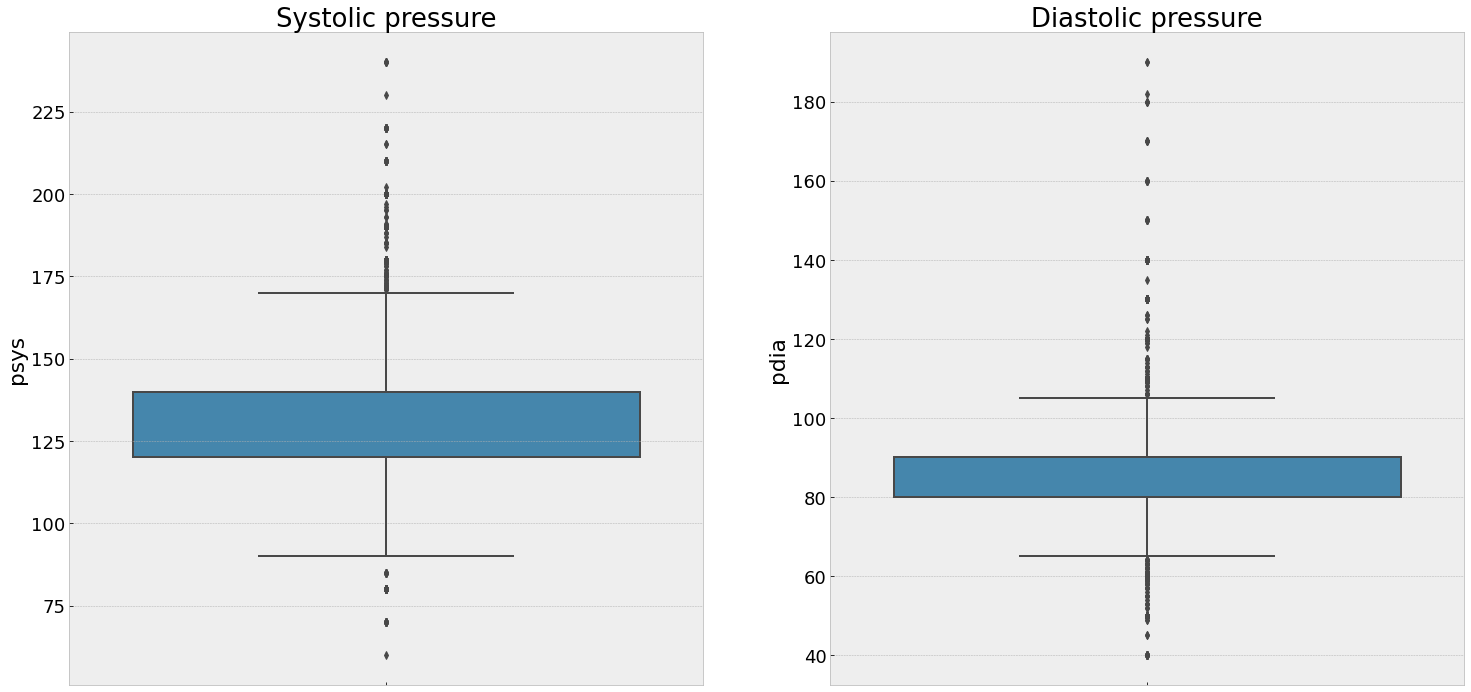

In [18]:
df1 = df1[(df1['psys'] < 400) & (df1['psys'] > 50) & (df1['pdia'] < 500) & (df1['pdia'] > 30)]

plt.subplot(121)
sns.boxplot(y = 'psys', data = df1)
plt.title('Systolic pressure')

plt.subplot(122)
sns.boxplot(y = 'pdia', data = df1)
plt.title('Diastolic pressure');

In [19]:
# A pressão sistólica deve ser maior que a pressão diastólica.
df1 = df1[df1['pdia'] < df1['psys']]

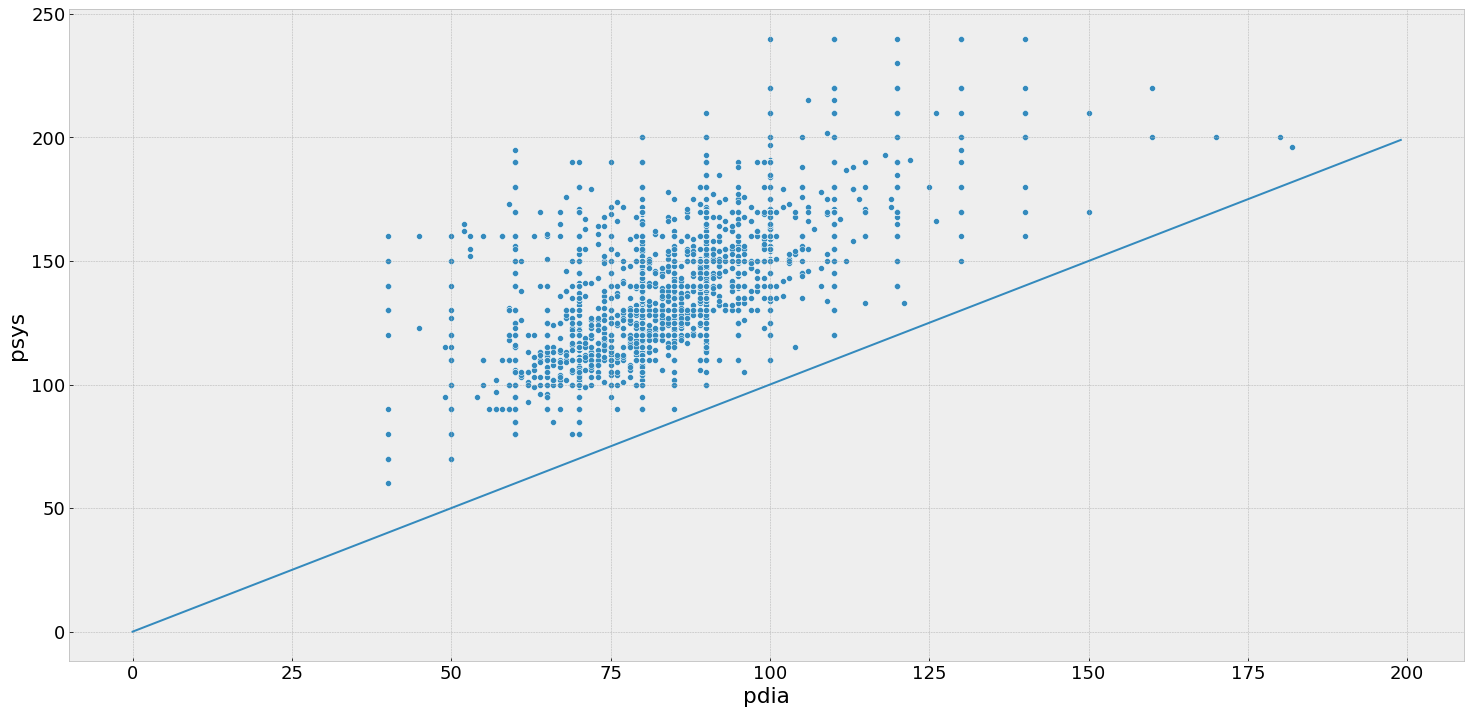

In [20]:
sns.scatterplot(x = 'pdia', y = 'psys', data = df1)
plt.plot(range(200), range(200))

# 2 Feature engineering

In [21]:
df2 = df1.copy()

## 2.1 Mapa de hipóteses

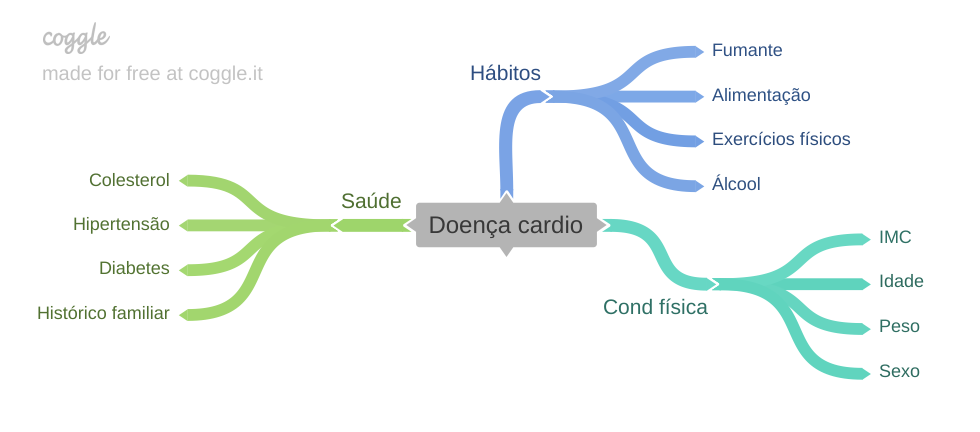

In [22]:
Image('img/HypothesisMindMap.png')

## 2.2 Criação das hipóteses

### 2.2.1 Hábitos

**1.** Fumantes têm maior chance de desenvolver doenças cardiovasculares

**2.** Alimentação saudável previne doenças cardiovasculares

**3.** Exercícios físicos diminuem a chance de doenças cardiovasculares

**4.** Consumo de álcool aumenta a chance de doenças cardiovasculares

### 2.2.2 Condição de saúde

**1.** Altos níveis de colesterol aumentam a chance de desenvolver doenças cardiovasculares

**2.** Pressão alta aumenta a chance de doenças cardiovasculares

**3.** Altos níveis de glicose no sangue aumenta a chance de doenças cardiovasculares

**4.** Histórico de doença cardiovascular na família aumenta a chance de desenvolver doenças cardiovasculares

### 2.2.3 Condição física

**1.** IMC alto aumenta as chances de doenças cardiovasculares

**2.** A chance de doenças cardiovasculares aumenta com a idade

**3.** Sobrepeso aumenta a chance de doenças cardiovasculares

**4.** Homens e mulheres têm chances diferentes de desenvolver doenças cardiovasculares

## 2.3 Prioridade das hipóteses

**1.** Fumantes têm maior chance de desenvolver doenças cardiovasculares

**2.** Exercícios físicos diminuem a chance de doenças cardiovasculares

**3.** Consumo de álcool aumenta a chance de doenças cardiovasculares

**4.** Altos níveis de colesterol aumentam a chance de desenvolver doenças cardiovasculares

**5.** Pressão alta aumenta a chance de doenças cardiovasculares

**6.** Altos níveis de glicose no sangue aumenta a chance de doenças cardiovasculares

**7.** IMC alto aumenta as chances de doenças cardiovasculares

**8.** A chance de doenças cardiovasculares aumenta com a idade

**9.** Homens e mulheres têm chances diferentes de desenvolver doenças cardiovasculares

## 2.4 Criação das variáveis

In [23]:
# Níveis de pressão:
# < 120/80 normal       | 1
# < 130/80 elevada      | 2
# >= 130/80 hipertensão | 3
df2['pressure'] = df2.apply(lambda x: 1 if x['psys'] < 120 and x['pdia'] < 80 else 2 if x['psys'] < 130 and x['pdia'] < 80 else 3, axis = 1)

In [24]:
# Altura em metros
df2['height'] = df2['height'].apply(lambda x: x/100)

# IMC | BMI - body mass index
df2['bmi'] = df2.apply(lambda x: x['weight']/x['height']**2, axis = 1)

# Abaixo do peso | IMC < 18,5
# Normal | 18,5 <= IMC < 25
# Sobrepeso | 25 <= IMC < 30
# Obesidade | IMC >= 30
df2['bmi_level'] = df2['bmi'].apply(lambda x: 1 if x < 18.5 else 2 if x < 25 else 3 if x < 30 else 4)

In [25]:
# Idade em anos
df2['age'] = df2['age_days'].apply(lambda x: x/365)

# 3 Filtragem das variáveis

In [26]:
df3 = df2.copy()

In [27]:
df3.drop(['age_days'], axis = 1, inplace = True)

# 4 Análise exploratória de dados

In [28]:
df4 = df3.copy()

In [29]:
df4.to_csv('data/interim/df4.csv', index = False)

In [ ]:
df4 = pd.read_csv('data/interim/df4.csv')

## 4.1 Análise univariada

### 4.1.1 Variável resposta

<AxesSubplot:xlabel='cardio', ylabel='count'>

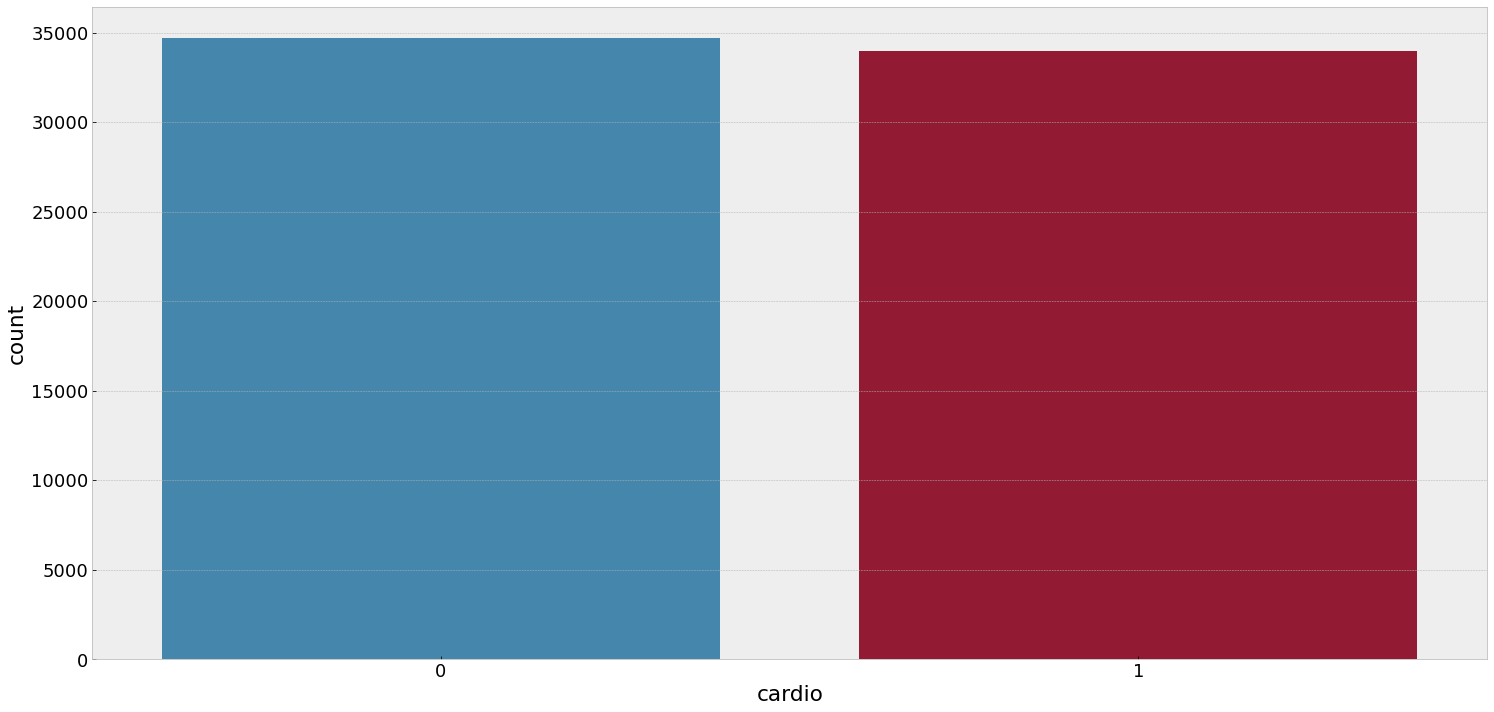

In [30]:
sns.countplot(x = 'cardio', data = df4)

### 4.1.2 Variáveis numéricas

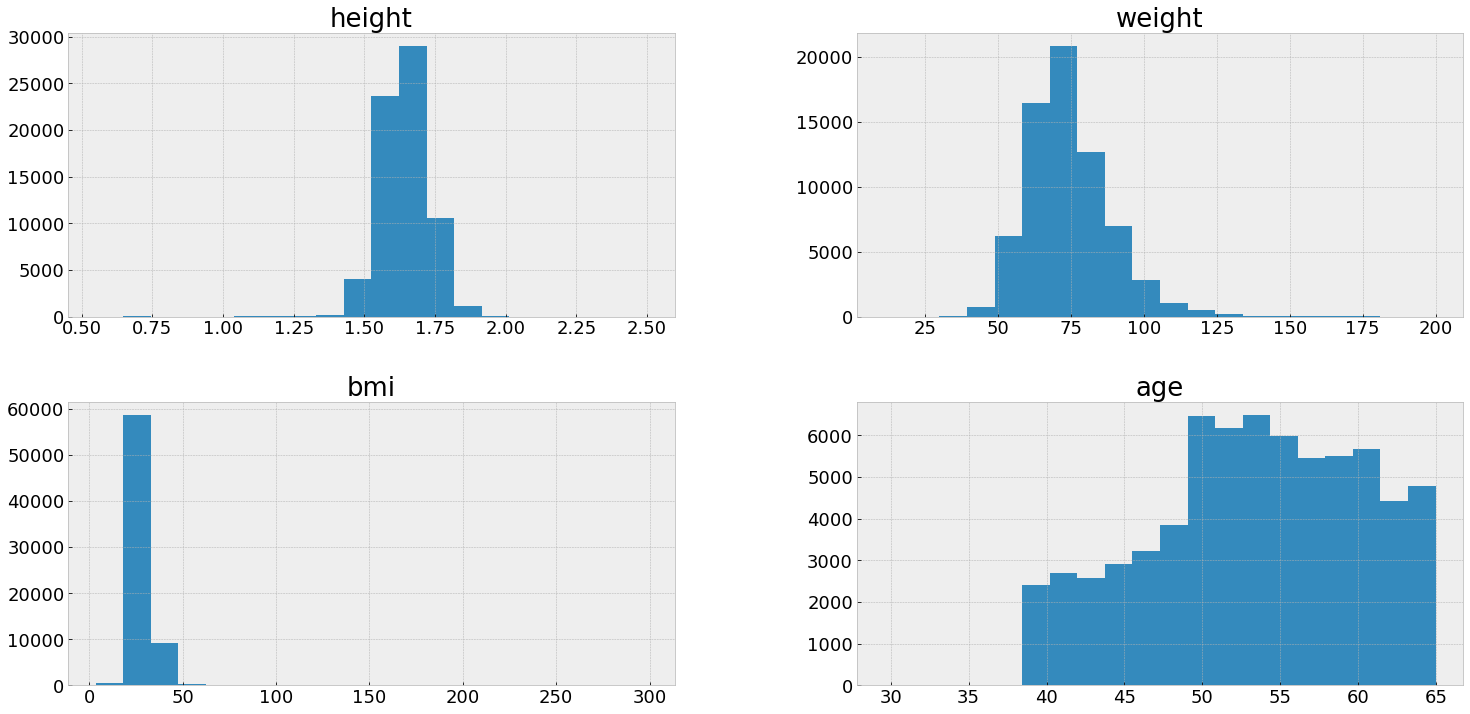

In [31]:
df4[['height', 'weight', 'bmi', 'age']].hist(bins = 20);

<AxesSubplot:>

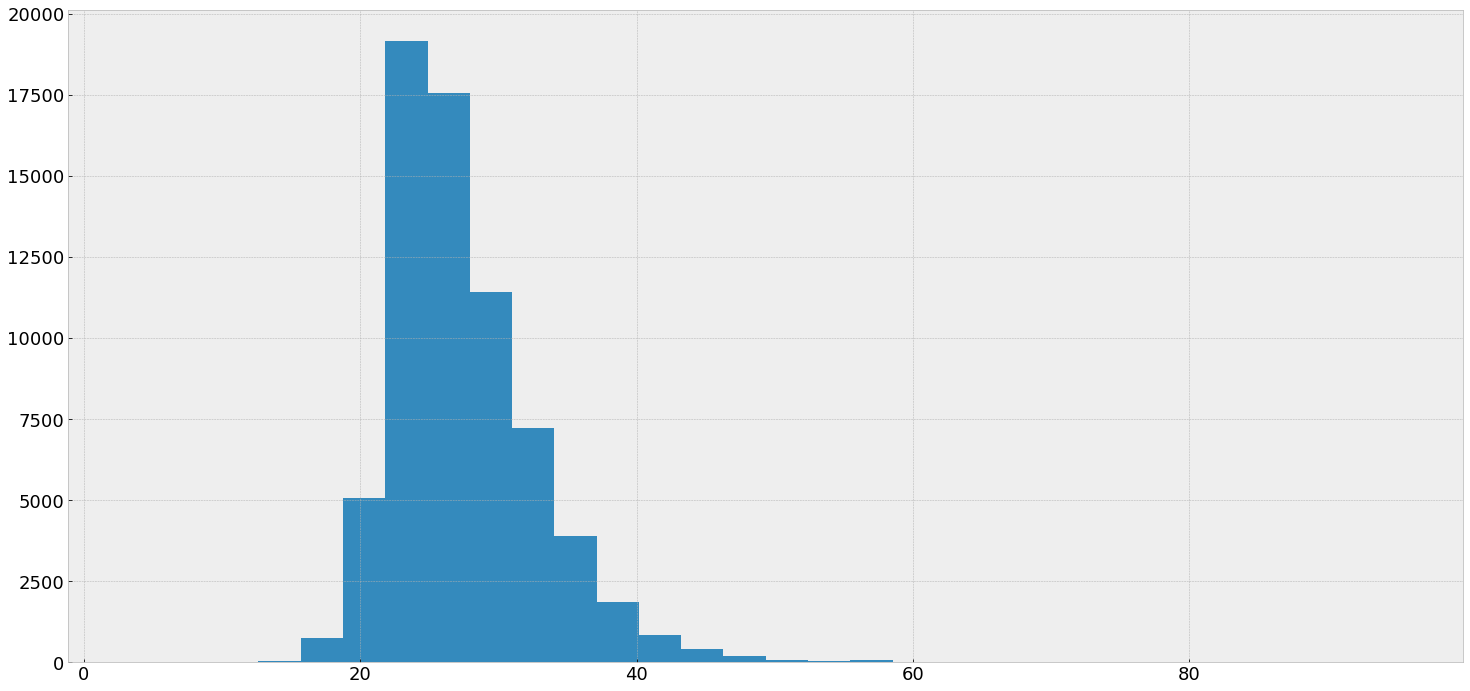

In [34]:
df4[df4['bmi'] < 100]['bmi'].hist(bins = 30)

### 4.1.3 Variáveis categóricas

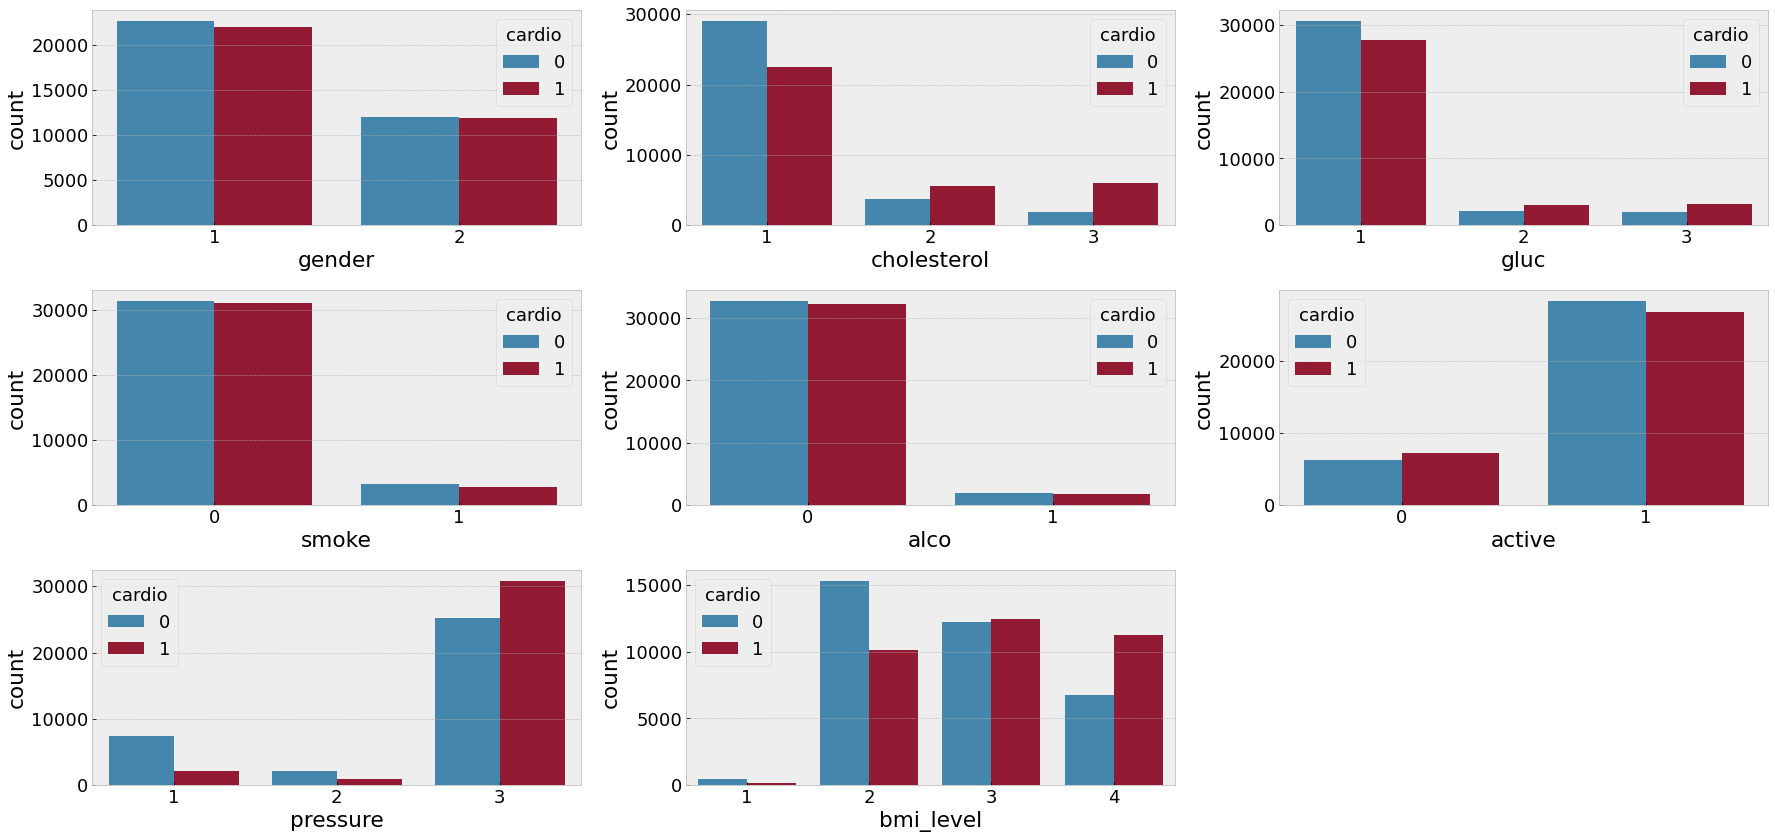

In [35]:
# gender | 1: women, 2: men
plt.subplot(331)
sns.countplot(x = 'gender', data = df4, hue = 'cardio')

# cholesterol | 1: normal, 2: above normal, 3: well above normal
plt.subplot(332)
sns.countplot(x = 'cholesterol', data = df4, hue = 'cardio')

# glucose | 1: normal, 2: above normal, 3: well above normal
plt.subplot(333)
sns.countplot(x = 'gluc', data = df4, hue = 'cardio')

# smoking
plt.subplot(334)
sns.countplot(x = 'smoke', data = df4, hue = 'cardio')

# alcohol intake
plt.subplot(335)
sns.countplot(x = 'alco', data = df4, hue = 'cardio')

# physical activity
plt.subplot(336)
sns.countplot(x = 'active', data = df4, hue = 'cardio')

# pressure level | 1: < 120/80 (normal), 2: < 130/80 (elevated), 3: >=130/80 (hypertension)
plt.subplot(337)
sns.countplot(x = 'pressure', data = df4, hue = 'cardio')

# BMI level | 1: < 18.5 (underweight), 2: < 25 (normal), 3: < 30 (overweight), 4: >= 30 (obesity)
plt.subplot(338)
sns.countplot(x = 'bmi_level', data = df4, hue = 'cardio')

plt.tight_layout();

## 4.2 Análise bivariada

### 4.2.1 H1: Fumantes têm maior chance de desenvolver doenças cardiovasculares
**Falso:** A incidência de doenças cardiovasculares é maior entre os não fumantes

Não fumantes
Sem problema cardiovascular 50.3%
Com problema cardiovascular 49.7%

Fumantes
Sem problema cardiovascular 53.2%
Com problema cardiovascular 46.8%


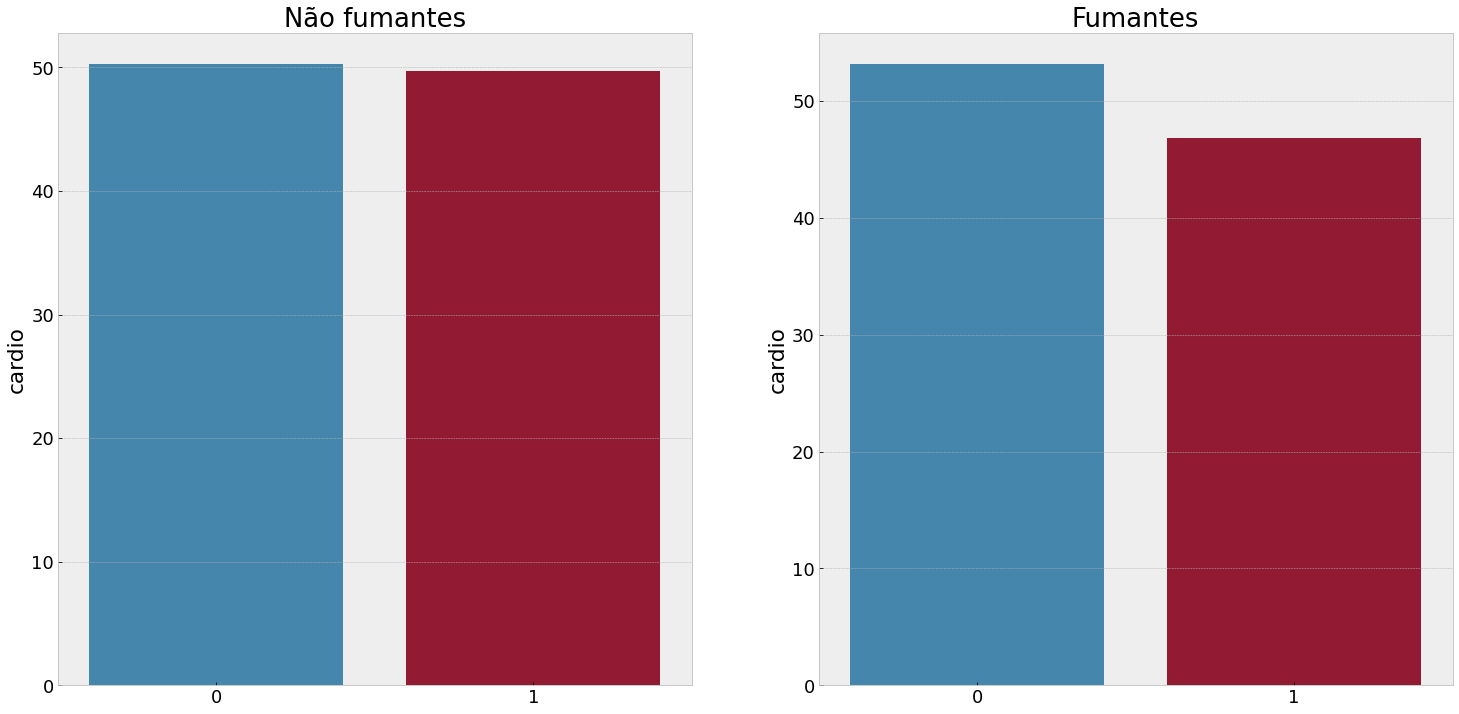

In [36]:
plt.subplot(121)
plt.title('Não fumantes')
aux1 = df4[df4['smoke'] == 0]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(122)
plt.title('Fumantes')
aux2 = df4[df4['smoke'] == 1]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

print('Não fumantes')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nFumantes')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

### 4.2.2 H2: Exercícios físicos diminuem a chance de doenças cardiovasculares
**Verdadeiro:** A incidência de doenças cardiovasculares é menor entre os praticantes de atividade física

Não ativos
Sem problema cardiovascular 46.7%
Com problema cardiovascular 53.3%

Ativos
Sem problema cardiovascular 51.5%
Com problema cardiovascular 48.5%


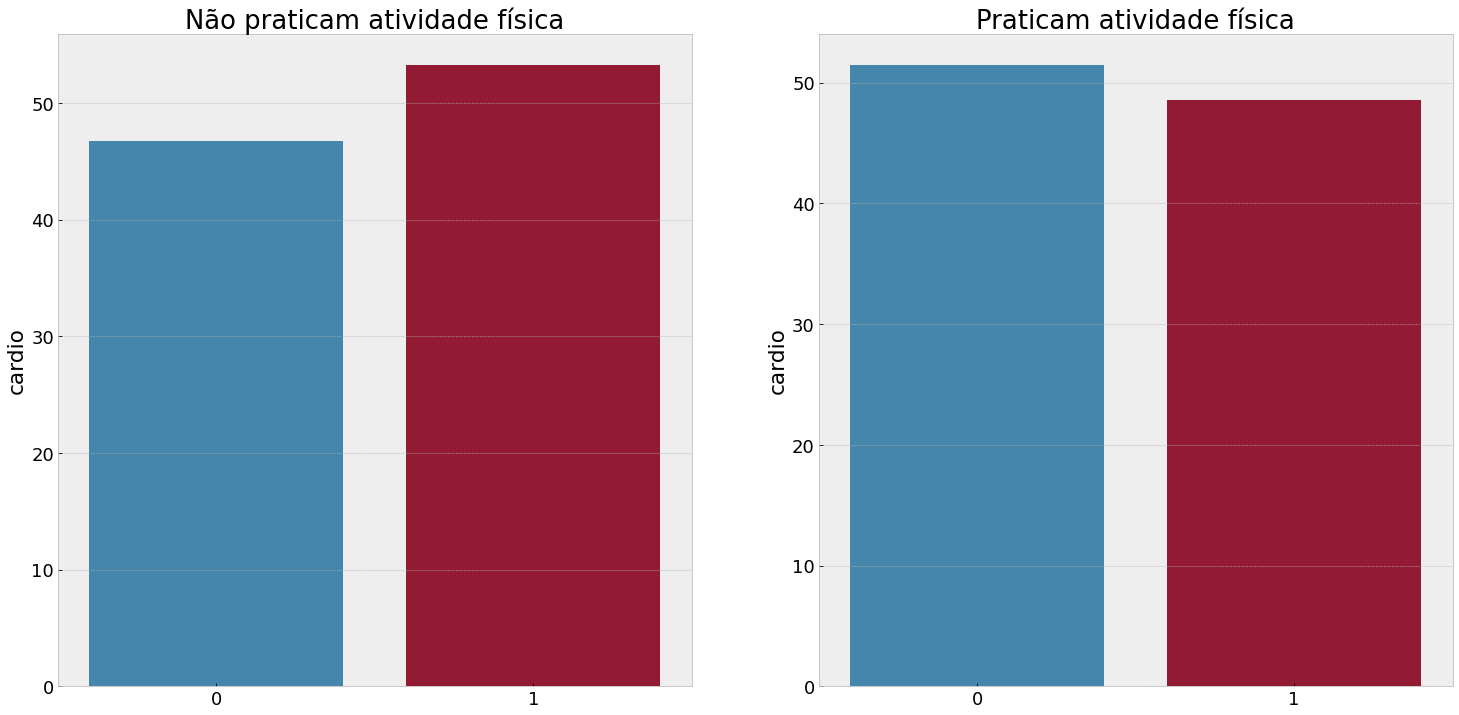

In [37]:
plt.subplot(121)
plt.title('Não praticam atividade física')
aux1 = df4[df4['active'] == 0]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(122)
plt.title('Praticam atividade física')
aux2 = df4[df4['active'] == 1]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

print('Não ativos')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nAtivos')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

### 4.2.3 H3: Consumo de álcool aumenta a chance de doenças cardiovasculares
**Falso:** A incidência de doenças cardiovasculares é menor entre os que consomem álcool

Não consomem álcool
Sem problema cardiovascular 50.4%
Com problema cardiovascular 49.6%

Consomem álcool
Sem problema cardiovascular 52.4%
Com problema cardiovascular 47.6%


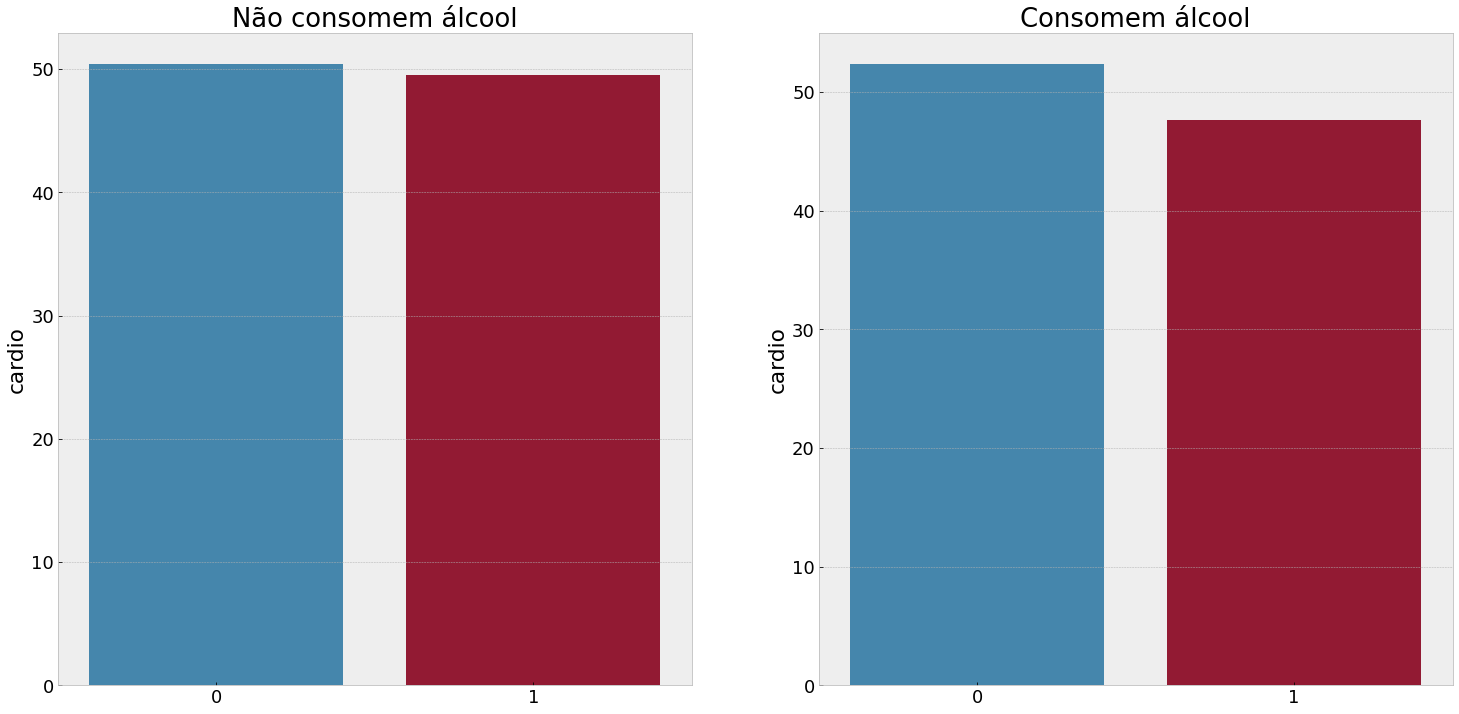

In [38]:
plt.subplot(121)
plt.title('Não consomem álcool')
aux1 = df4[df4['alco'] == 0]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(122)
plt.title('Consomem álcool')
aux2 = df4[df4['alco'] == 1]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

print('Não consomem álcool')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nConsomem álcool')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

### 4.2.4 H4: Altos níveis de colesterol aumentam a chance de desenvolver doenças cardiovasculares
**Verdadeiro:** Altos níveis de colesterol aumentam as chances de doenças cardiovasculares

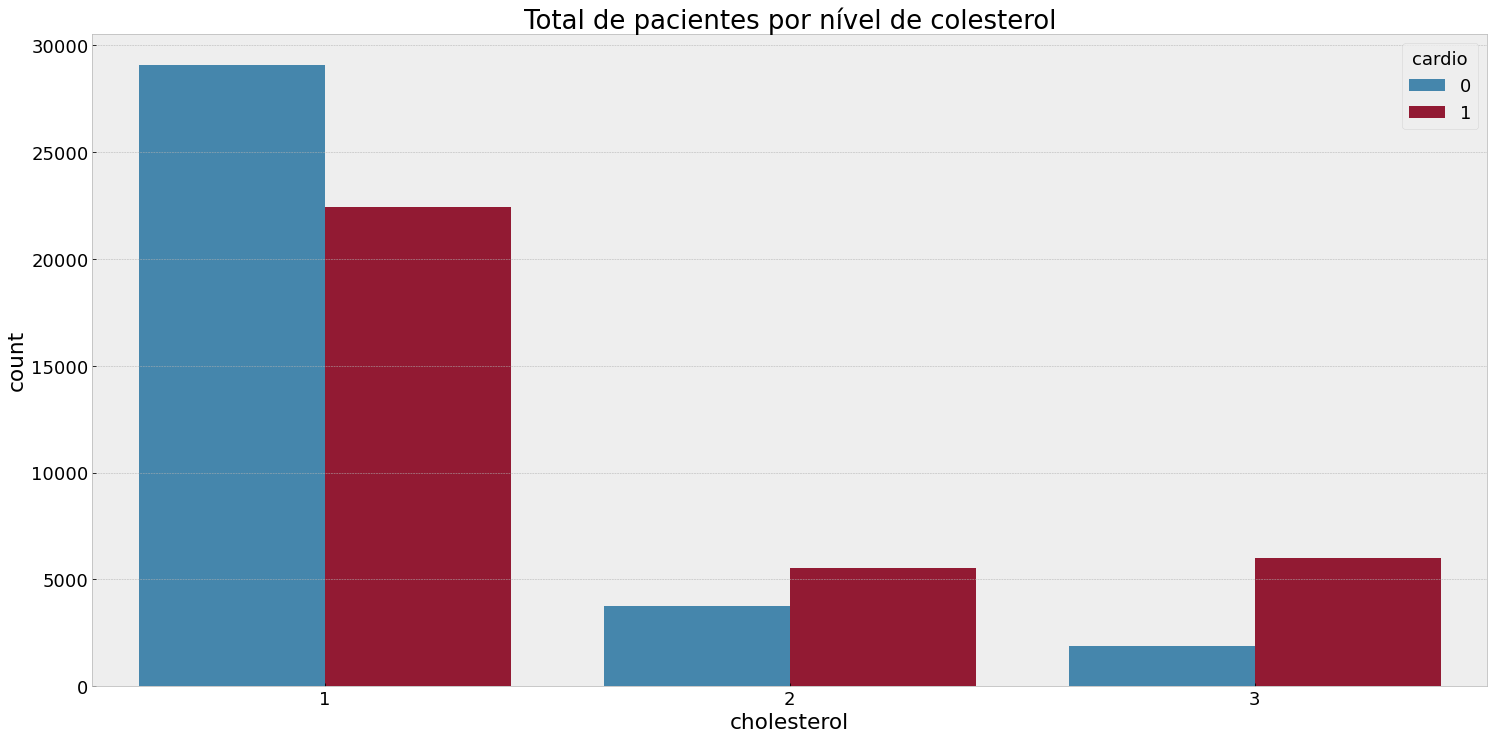

In [39]:
plt.title('Total de pacientes por nível de colesterol')
sns.countplot(x = 'cholesterol', data = df4, hue = 'cardio');

Colesterol normal
Sem problema cardiovascular 56.5%
Com problema cardiovascular 43.5%

Colesterol alto
Sem problema cardiovascular 40.4%
Com problema cardiovascular 59.6%

Colesterol muito alto
Sem problema cardiovascular 23.7%
Com problema cardiovascular 76.3%


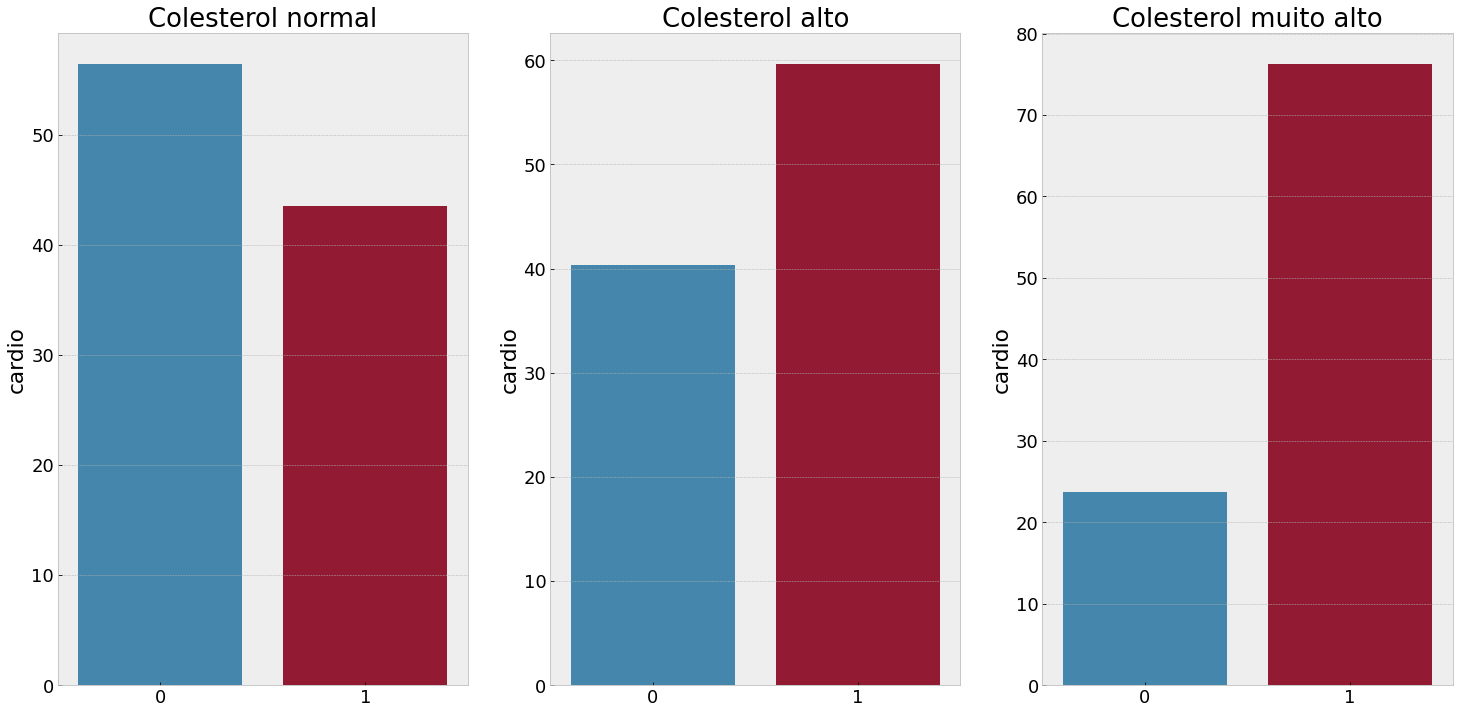

In [40]:
plt.subplot(131)
plt.title('Colesterol normal')
aux1 = df4[df4['cholesterol'] == 1]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(132)
plt.title('Colesterol alto')
aux2 = df4[df4['cholesterol'] == 2]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

plt.subplot(133)
plt.title('Colesterol muito alto')
aux3 = df4[df4['cholesterol'] == 3]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux3.index, y = aux3)

print('Colesterol normal')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nColesterol alto')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

print('\nColesterol muito alto')
print('Sem problema cardiovascular {:.1f}%'.format(aux3[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux3[1]))

### 4.2.5 H5: Pressão alta aumenta a chance de doenças cardiovasculares
**Verdadeiro:** Pressão alta aumenta a chance de doenças cardiovasculares

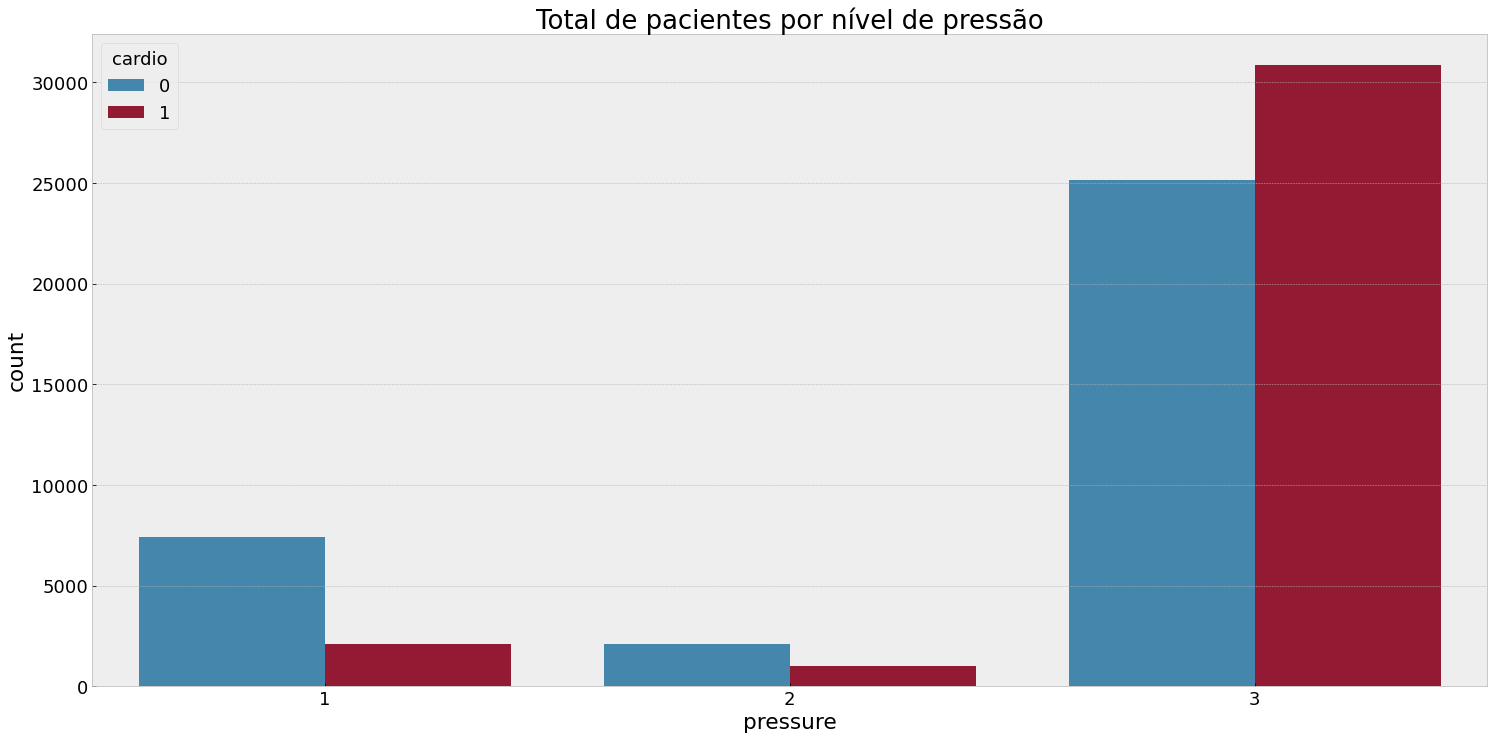

In [41]:
plt.title('Total de pacientes por nível de pressão')
sns.countplot(x = 'pressure', data = df4, hue = 'cardio');

Pressão normal
Sem problema cardiovascular 77.8%
Com problema cardiovascular 22.2%

Pressão alta
Sem problema cardiovascular 67.7%
Com problema cardiovascular 32.3%

Hipertensão
Sem problema cardiovascular 44.9%
Com problema cardiovascular 55.1%


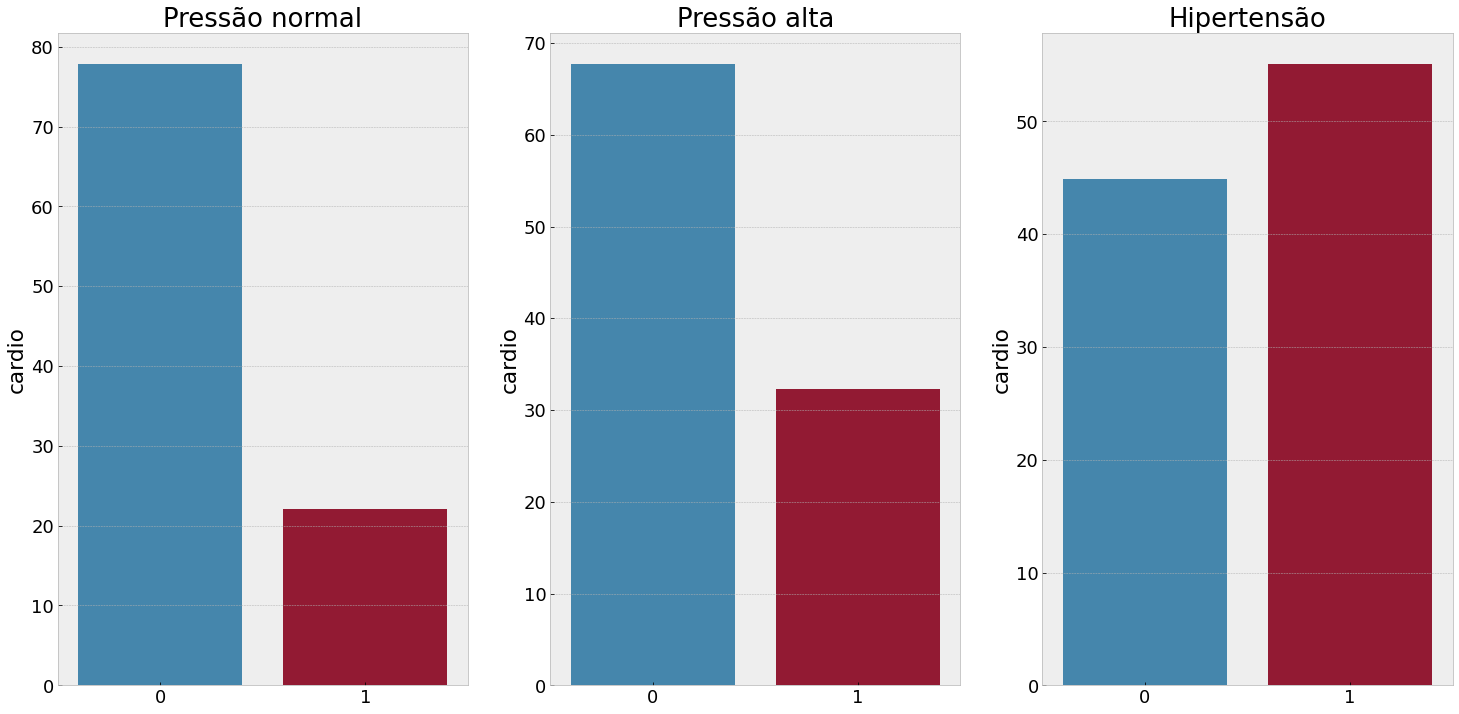

In [42]:
plt.subplot(131)
plt.title('Pressão normal')
aux1 = df4[df4['pressure'] == 1]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(132)
plt.title('Pressão alta')
aux2 = df4[df4['pressure'] == 2]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

plt.subplot(133)
plt.title('Hipertensão')
aux3 = df4[df4['pressure'] == 3]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux3.index, y = aux3)

print('Pressão normal')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nPressão alta')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

print('\nHipertensão')
print('Sem problema cardiovascular {:.1f}%'.format(aux3[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux3[1]))

### 4.2.6 H6: Altos níveis de glicose no sangue aumenta a chance de doenças cardiovasculares
**Verdadeiro:** Altos níveis de glicose aumentam a chance de doenças cardiovasculares

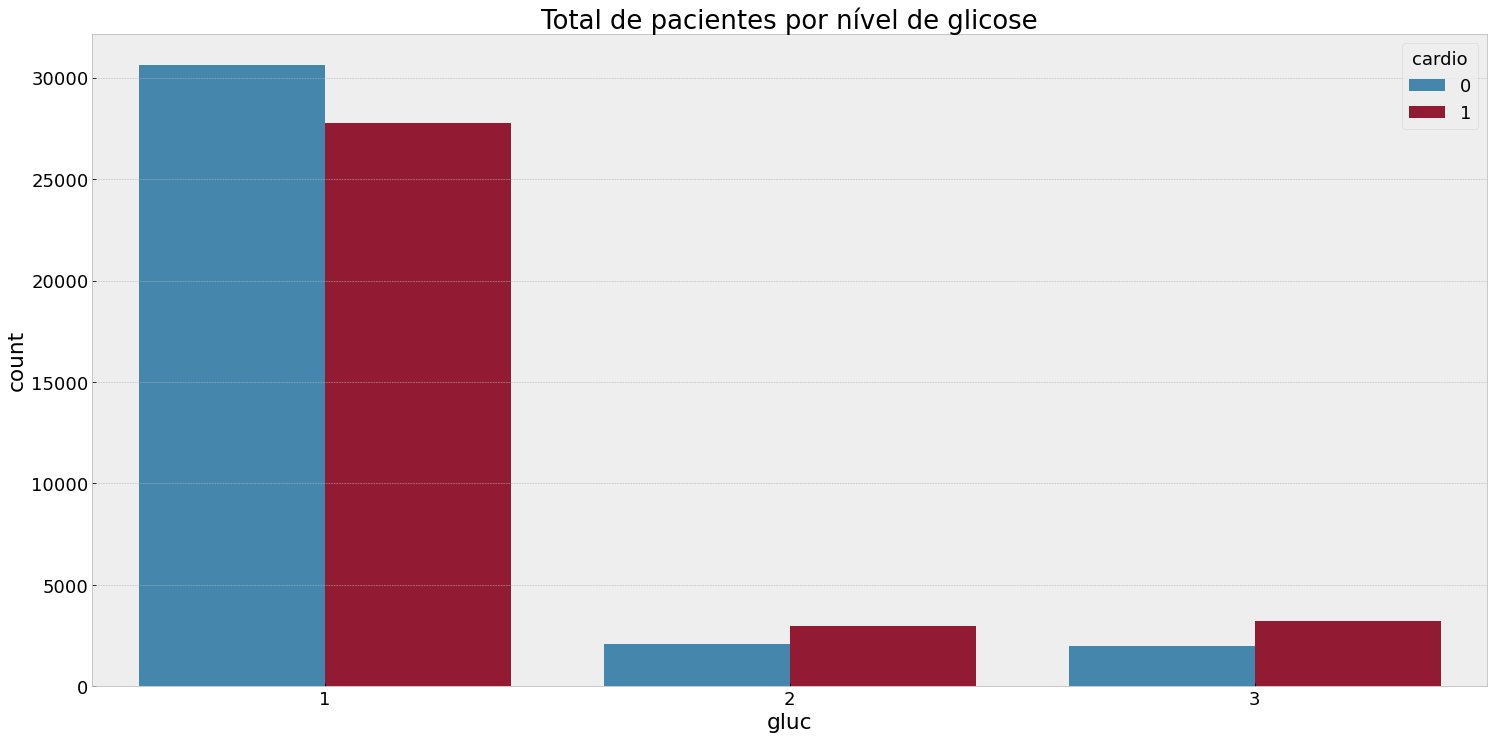

In [43]:
plt.title('Total de pacientes por nível de glicose')
sns.countplot(x = 'gluc', data = df4, hue = 'cardio');

Glicose normal
Sem problema cardiovascular 52.4%
Com problema cardiovascular 47.6%

Glicose alta
Sem problema cardiovascular 41.1%
Com problema cardiovascular 58.9%

Glicose muito alta
Sem problema cardiovascular 38.2%
Com problema cardiovascular 61.8%


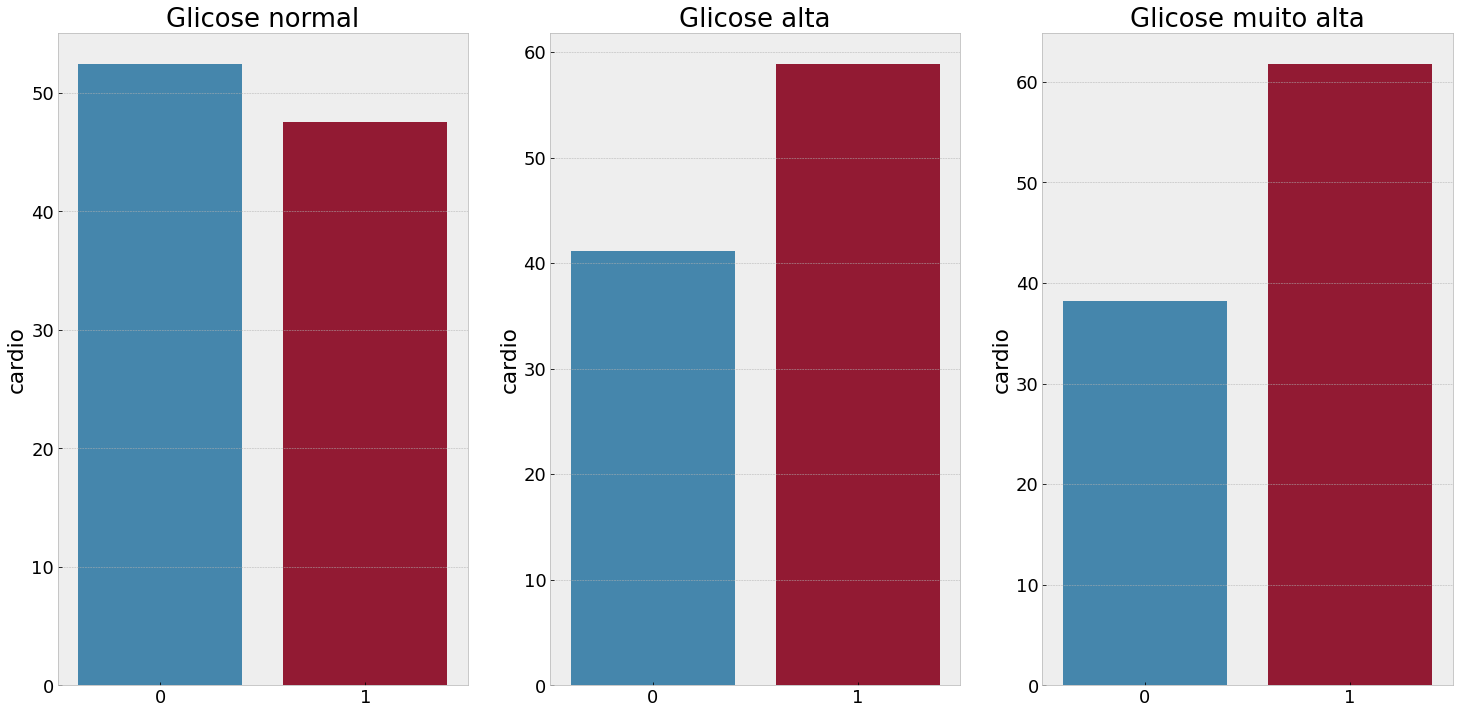

In [44]:
plt.subplot(131)
plt.title('Glicose normal')
aux1 = df4[df4['gluc'] == 1]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(132)
plt.title('Glicose alta')
aux2 = df4[df4['gluc'] == 2]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

plt.subplot(133)
plt.title('Glicose muito alta')
aux3 = df4[df4['gluc'] == 3]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux3.index, y = aux3)

print('Glicose normal')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nGlicose alta')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

print('\nGlicose muito alta')
print('Sem problema cardiovascular {:.1f}%'.format(aux3[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux3[1]))

### 4.2.7 H7: IMC alto aumenta as chances de doenças cardiovasculares
**Verdadeiro:** Pacientes com sobrepeso ou obesidade têm altas chances de desenvolver doenças cardiovasculares

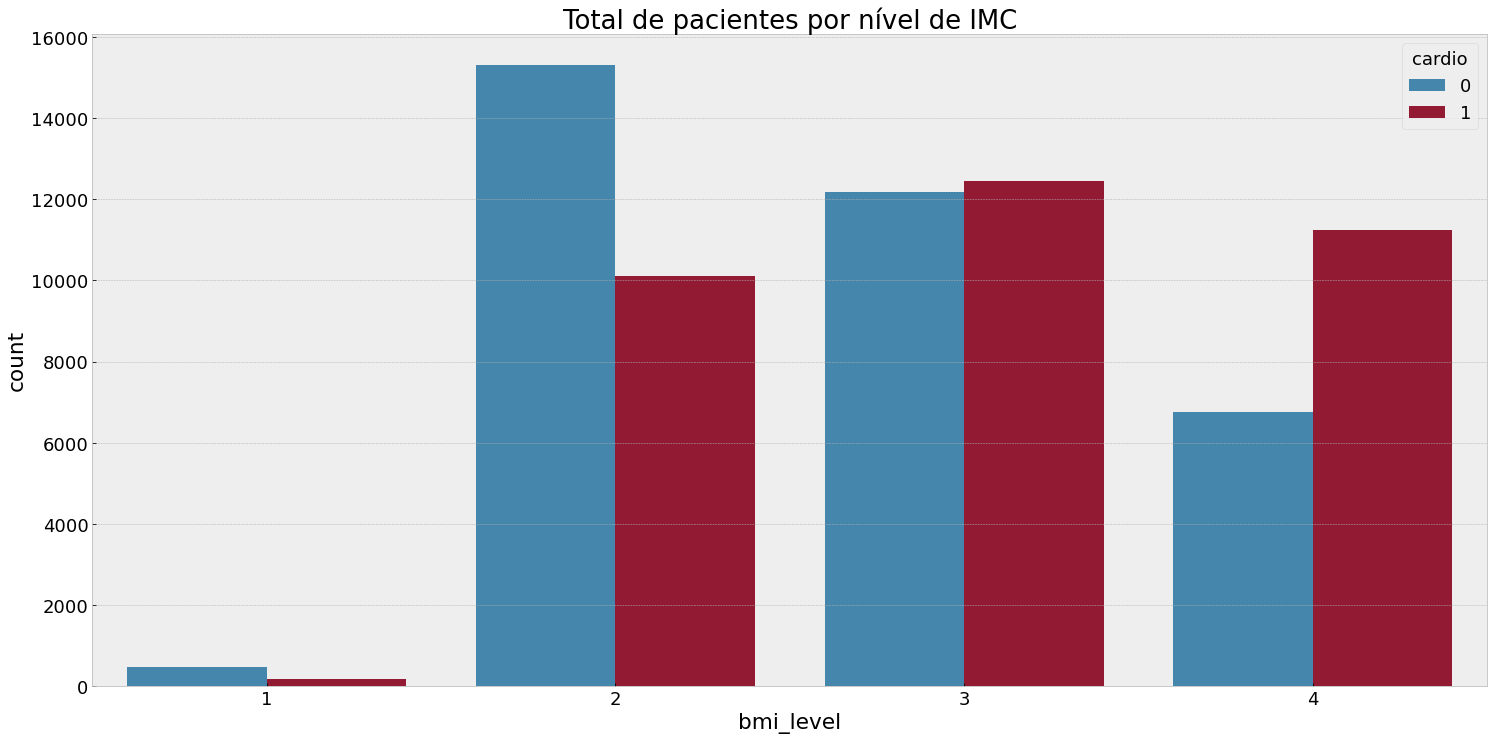

In [45]:
plt.title('Total de pacientes por nível de IMC')
sns.countplot(x = 'bmi_level', data = df4, hue = 'cardio');

Abaixo do peso
Sem problema cardiovascular 72.5%
Com problema cardiovascular 27.5%

Peso normal
Sem problema cardiovascular 60.2%
Com problema cardiovascular 39.8%

Sobrepeso
Sem problema cardiovascular 49.4%
Com problema cardiovascular 50.6%

Obesidade
Sem problema cardiovascular 37.5%
Com problema cardiovascular 62.5%


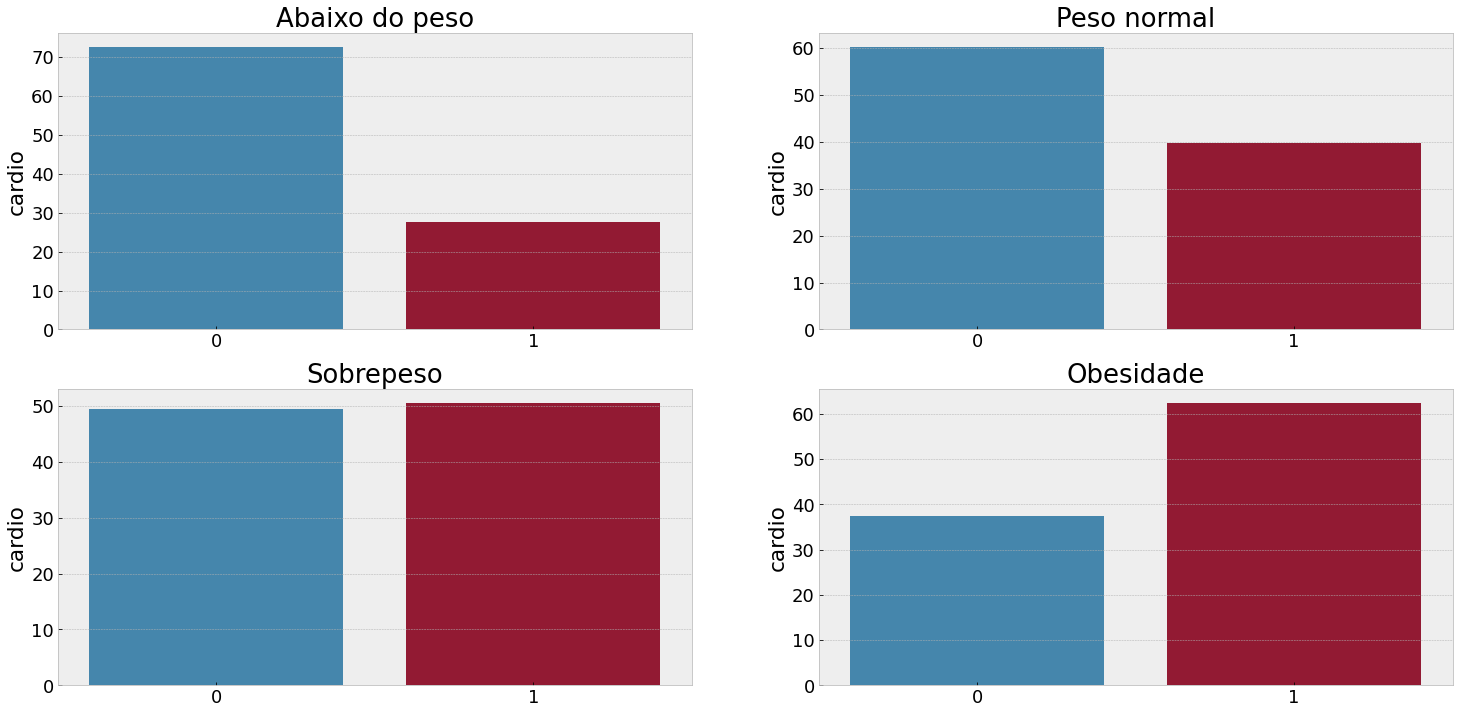

In [46]:
plt.subplot(221)
plt.title('Abaixo do peso')
aux1 = df4[df4['bmi_level'] == 1]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(222)
plt.title('Peso normal')
aux2 = df4[df4['bmi_level'] == 2]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

plt.subplot(223)
plt.title('Sobrepeso')
aux3 = df4[df4['bmi_level'] == 3]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux3.index, y = aux3)

plt.subplot(224)
plt.title('Obesidade')
aux4 = df4[df4['bmi_level'] == 4]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux4.index, y = aux4)

print('Abaixo do peso')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nPeso normal')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

print('\nSobrepeso')
print('Sem problema cardiovascular {:.1f}%'.format(aux3[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux3[1]))

print('\nObesidade')
print('Sem problema cardiovascular {:.1f}%'.format(aux4[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux4[1]))

### 4.2.8 H8: A chance de doenças cardiovasculares aumenta com a idade
**Verdadeiro:** A incidência de doenças cardiovasculares aumenta com a idade

Os pacientes têm idades entre 29 e 64 anos

Abaixo de 40 anos
Sem problema cardiovascular 76.1%
Com problema cardiovascular 23.9%

Entre 40 e 49 anos
Sem problema cardiovascular 62.5%
Com problema cardiovascular 37.5%

Entre 50 e 59 anos
Sem problema cardiovascular 48.9%
Com problema cardiovascular 51.1%

A partir de 60 anos
Sem problema cardiovascular 33.3%
Com problema cardiovascular 66.7%


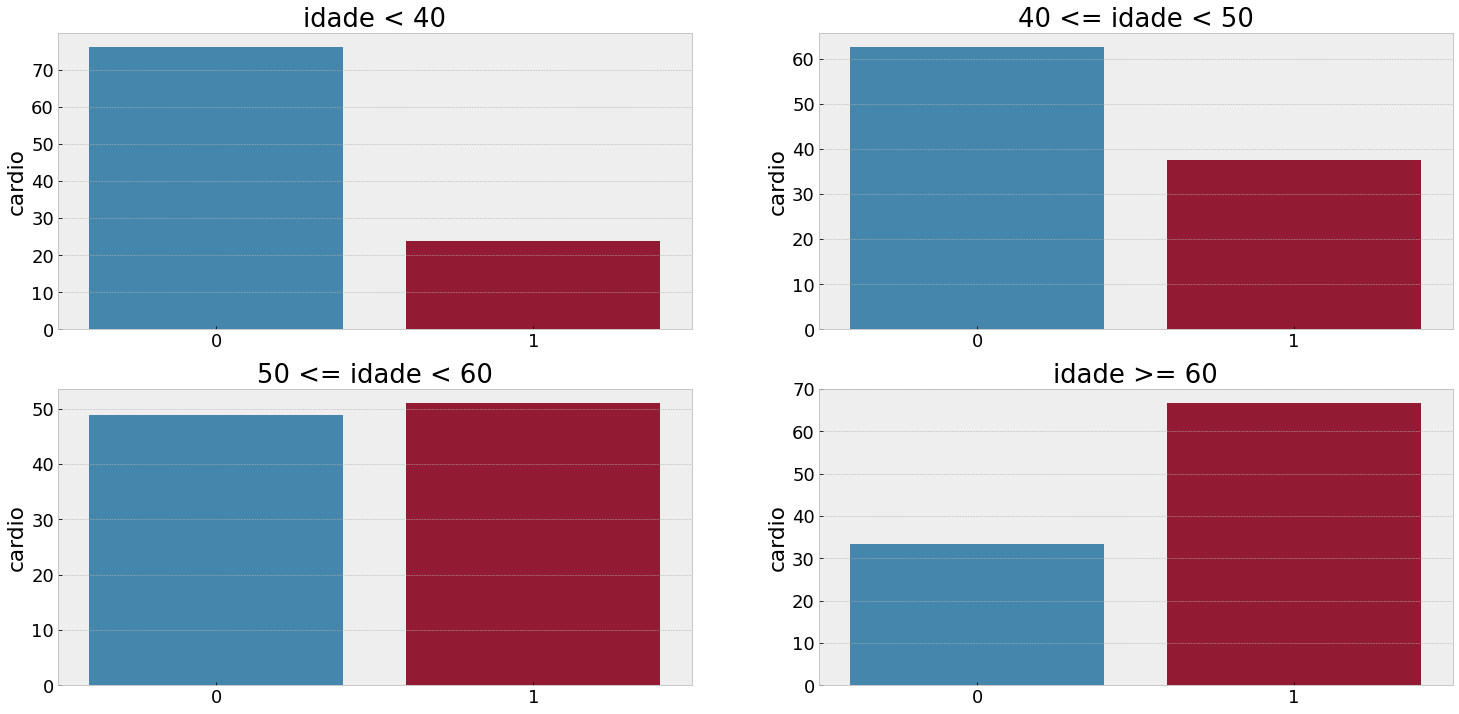

In [47]:
print('Os pacientes têm idades entre {} e {} anos'.format(int(df4['age'].min()), int(df4['age'].max())))

plt.subplot(221)
plt.title('idade < 40')
aux1 = df4[df4['age'] < 40]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(222)
plt.title('40 <= idade < 50')
aux2 = df4[(df4['age'] >= 40) & (df4['age'] < 50)]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

plt.subplot(223)
plt.title('50 <= idade < 60')
aux3 = df4[(df4['age'] >= 50) & (df4['age'] < 60)]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux3.index, y = aux3)

plt.subplot(224)
plt.title('idade >= 60')
aux4 = df4[df4['age'] >= 60]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux4.index, y = aux4)

print('\nAbaixo de 40 anos')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nEntre 40 e 49 anos')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

print('\nEntre 50 e 59 anos')
print('Sem problema cardiovascular {:.1f}%'.format(aux3[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux3[1]))

print('\nA partir de 60 anos')
print('Sem problema cardiovascular {:.1f}%'.format(aux4[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux4[1]))

### 4.2.9 H9: Homens e mulheres têm chances diferentes de desenvolver doenças cardiovasculares
**Falso:** Não há diferença significativa de probabilidade entre os sexos

Mulheres
Sem problema cardiovascular 50.8%
Com problema cardiovascular 49.2%

Homens
Sem problema cardiovascular 50.0%
Com problema cardiovascular 50.0%


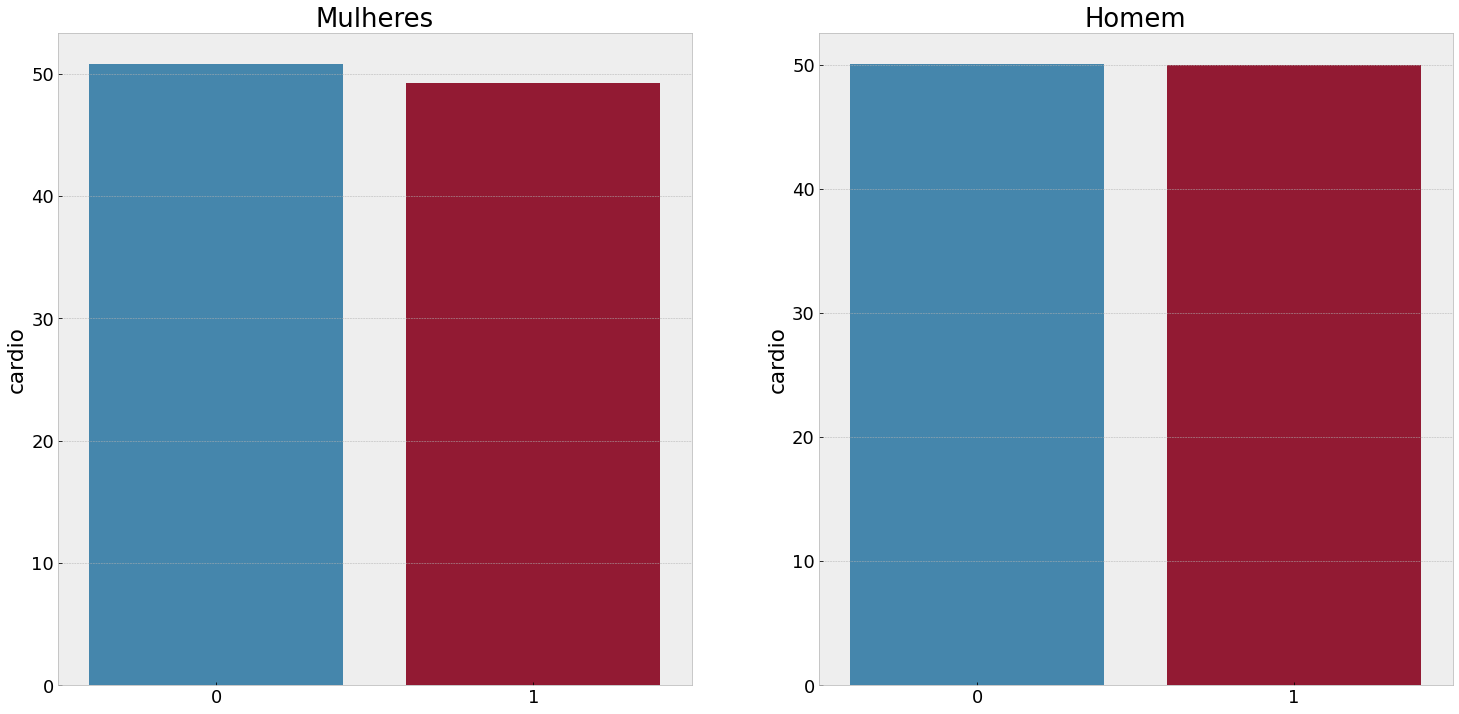

In [48]:
plt.subplot(121)
plt.title('Mulheres')
aux1 = df4[df4['gender'] == 1]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux1.index, y = aux1)

plt.subplot(122)
plt.title('Homem')
aux2 = df4[df4['gender'] == 2]['cardio'].value_counts(normalize = True)*100
sns.barplot(x = aux2.index, y = aux2)

print('Mulheres')
print('Sem problema cardiovascular {:.1f}%'.format(aux1[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux1[1]))

print('\nHomens')
print('Sem problema cardiovascular {:.1f}%'.format(aux2[0]))
print('Com problema cardiovascular {:.1f}%'.format(aux2[1]))

### 4.2.10 Resumo das hipóteses

In [49]:
tab = [['Hipótese', 'Conclusão', 'Relevância'], 
       ['H1', 'Falso', 'Baixa'], 
       ['H2', 'Verdadeiro', 'Baixa'], 
       ['H3', 'Falso', 'Baixa'], 
       ['H4', 'Verdadeiro', 'Alta'], 
       ['H5', 'Verdadeiro', 'Alta'], 
       ['H6', 'Verdadeiro', 'Alta'], 
       ['H7', 'Verdadeiro', 'Alta'], 
       ['H8', 'Verdadeiro', 'Alta'], 
       ['H9', 'Falso', 'Baixa']
      ]
print(tabulate(tab, headers = 'firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falso        Baixa
H2          Verdadeiro   Baixa
H3          Falso        Baixa
H4          Verdadeiro   Alta
H5          Verdadeiro   Alta
H6          Verdadeiro   Alta
H7          Verdadeiro   Alta
H8          Verdadeiro   Alta
H9          Falso        Baixa


## 4.3 Análise Multivariada

In [50]:
num_attributes = df4[['height', 'weight', 'psys', 'pdia', 'bmi', 'age']]
cat_attributes = df4[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'pressure', 'bmi_level']]

### 4.3.1 Atributos numéricos

<AxesSubplot:>

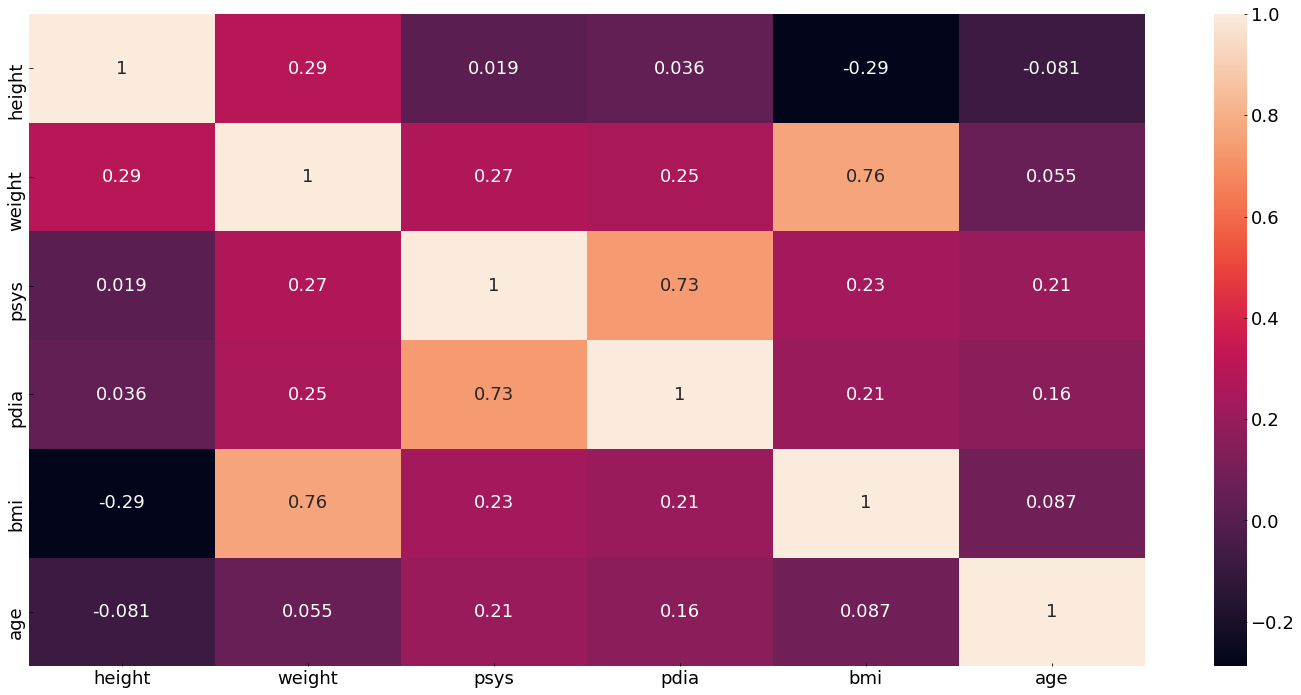

In [51]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Atributos categóricos

<AxesSubplot:>

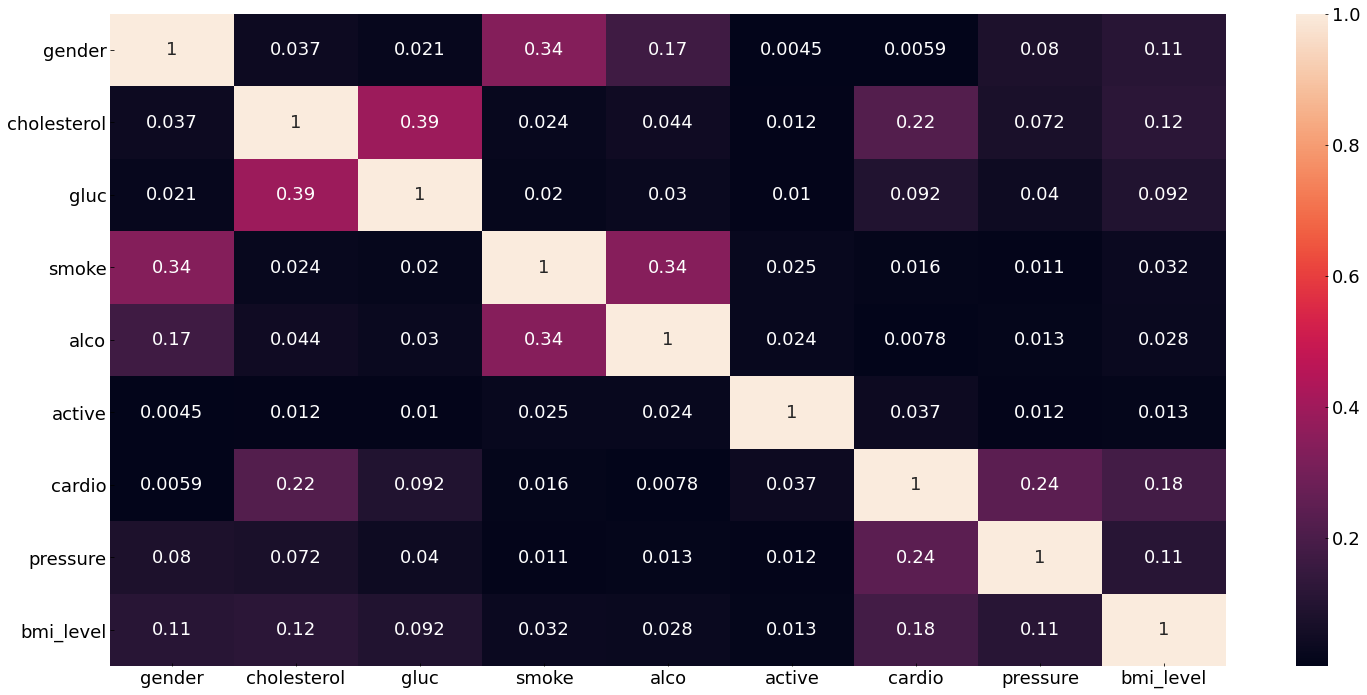

In [52]:
# Dados categóricos
cat = cat_attributes.copy()

# Cálculo do V de Cramér
a1 = cramerV(cat['gender'], cat['gender'])
a2 = cramerV(cat['gender'], cat['cholesterol'])
a3 = cramerV(cat['gender'], cat['gluc'])
a4 = cramerV(cat['gender'], cat['smoke'])
a5 = cramerV(cat['gender'], cat['alco'])
a6 = cramerV(cat['gender'], cat['active'])
a7 = cramerV(cat['gender'], cat['cardio'])
a8 = cramerV(cat['gender'], cat['pressure'])
a9 = cramerV(cat['gender'], cat['bmi_level'])
a10 = cramerV(cat['cholesterol'], cat['gender'])
a11 = cramerV(cat['cholesterol'], cat['cholesterol'])
a12 = cramerV(cat['cholesterol'], cat['gluc'])
a13 = cramerV(cat['cholesterol'], cat['smoke'])
a14 = cramerV(cat['cholesterol'], cat['alco'])
a15 = cramerV(cat['cholesterol'], cat['active'])
a16 = cramerV(cat['cholesterol'], cat['cardio'])
a17 = cramerV(cat['cholesterol'], cat['pressure'])
a18 = cramerV(cat['cholesterol'], cat['bmi_level'])
a19 = cramerV(cat['gluc'], cat['gender'])
a20 = cramerV(cat['gluc'], cat['cholesterol'])
a21 = cramerV(cat['gluc'], cat['gluc'])
a22 = cramerV(cat['gluc'], cat['smoke'])
a23 = cramerV(cat['gluc'], cat['alco'])
a24 = cramerV(cat['gluc'], cat['active'])
a25 = cramerV(cat['gluc'], cat['cardio'])
a26 = cramerV(cat['gluc'], cat['pressure'])
a27 = cramerV(cat['gluc'], cat['bmi_level'])
a28 = cramerV(cat['smoke'], cat['gender'])
a29 = cramerV(cat['smoke'], cat['cholesterol'])
a30 = cramerV(cat['smoke'], cat['gluc'])
a31 = cramerV(cat['smoke'], cat['smoke'])
a32 = cramerV(cat['smoke'], cat['alco'])
a33 = cramerV(cat['smoke'], cat['active'])
a34 = cramerV(cat['smoke'], cat['cardio'])
a35 = cramerV(cat['smoke'], cat['pressure'])
a36 = cramerV(cat['smoke'], cat['bmi_level'])
a37 = cramerV(cat['alco'], cat['gender'])
a38 = cramerV(cat['alco'], cat['cholesterol'])
a39 = cramerV(cat['alco'], cat['gluc'])
a40 = cramerV(cat['alco'], cat['smoke'])
a41 = cramerV(cat['alco'], cat['alco'])
a42 = cramerV(cat['alco'], cat['active'])
a43 = cramerV(cat['alco'], cat['cardio'])
a44 = cramerV(cat['alco'], cat['pressure'])
a45 = cramerV(cat['alco'], cat['bmi_level'])
a46 = cramerV(cat['active'], cat['gender'])
a47 = cramerV(cat['active'], cat['cholesterol'])
a48 = cramerV(cat['active'], cat['gluc'])
a49 = cramerV(cat['active'], cat['smoke'])
a50 = cramerV(cat['active'], cat['alco'])
a51 = cramerV(cat['active'], cat['active'])
a52 = cramerV(cat['active'], cat['cardio'])
a53 = cramerV(cat['active'], cat['pressure'])
a54 = cramerV(cat['active'], cat['bmi_level'])
a55 = cramerV(cat['cardio'], cat['gender'])
a56 = cramerV(cat['cardio'], cat['cholesterol'])
a57 = cramerV(cat['cardio'], cat['gluc'])
a58 = cramerV(cat['cardio'], cat['smoke'])
a59 = cramerV(cat['cardio'], cat['alco'])
a60 = cramerV(cat['cardio'], cat['active'])
a61 = cramerV(cat['cardio'], cat['cardio'])
a62 = cramerV(cat['cardio'], cat['pressure'])
a63 = cramerV(cat['cardio'], cat['bmi_level'])
a64 = cramerV(cat['pressure'], cat['gender'])
a65 = cramerV(cat['pressure'], cat['cholesterol'])
a66 = cramerV(cat['pressure'], cat['gluc'])
a67 = cramerV(cat['pressure'], cat['smoke'])
a68 = cramerV(cat['pressure'], cat['alco'])
a69 = cramerV(cat['pressure'], cat['active'])
a70 = cramerV(cat['pressure'], cat['cardio'])
a71 = cramerV(cat['pressure'], cat['pressure'])
a72 = cramerV(cat['pressure'], cat['bmi_level'])
a73 = cramerV(cat['bmi_level'], cat['gender'])
a74 = cramerV(cat['bmi_level'], cat['cholesterol'])
a75 = cramerV(cat['bmi_level'], cat['gluc'])
a76 = cramerV(cat['bmi_level'], cat['smoke'])
a77 = cramerV(cat['bmi_level'], cat['alco'])
a78 = cramerV(cat['bmi_level'], cat['active'])
a79 = cramerV(cat['bmi_level'], cat['cardio'])
a80 = cramerV(cat['bmi_level'], cat['pressure'])
a81 = cramerV(cat['bmi_level'], cat['bmi_level'])

# Conjunto final
d = pd.DataFrame({'gender': [a1, a2, a3, a4, a5, a6, a7, a8, a9], 
                  'cholesterol': [a10, a11, a12, a13, a14, a15, a16, a17, a18], 
                  'gluc': [a19, a20, a21, a22, a23, a24, a25, a26, a27], 
                  'smoke': [a28, a29, a30, a31, a32, a33, a34, a35, a36], 
                  'alco': [a37, a38, a39, a40, a41, a42, a43, a44, a45], 
                  'active': [a46, a47, a48, a49, a50, a51, a52, a53, a54], 
                  'cardio': [a55, a56, a57, a58, a59, a60, a61, a62, a63], 
                  'pressure': [a64, a65, a66, a67, a68, a69, a70, a71, a72], 
                  'bmi_level': [a73, a74, a75, a76, a77, a78, a79, a80, a81]})
d.set_index(d.columns, inplace = True)

sns.heatmap(d, annot = True)

# 5 Preparação dos dados

In [53]:
df5 = df4.copy()

In [ ]:
df5.to_csv('data/interim/df5.csv', index = False)

In [ ]:
df5 = pd.read_csv('data/interim/df5.csv')

## 5.1 Normalização

In [54]:
# Height | média: 1.644, desv pad = 0.082
med = df5['height'].mean()
stddev = df5['height'].std()
df5['height'] = df5['height'].apply(lambda x: (x-med)/stddev)

## 5.2 Rescaling

In [55]:
mms = MinMaxScaler()
rs = RobustScaler()

# Weight
df5['weight'] = mms.fit_transform(df5[['weight']].values)

# P systolic
df5['psys'] = mms.fit_transform(df5[['psys']].values)

# P diastolic
df5['pdia'] = mms.fit_transform(df5[['pdia']].values)

# BMI
df5['bmi'] = rs.fit_transform(df5[['bmi']].values)

# Age
df5['age'] = mms.fit_transform(df5[['age']].values)

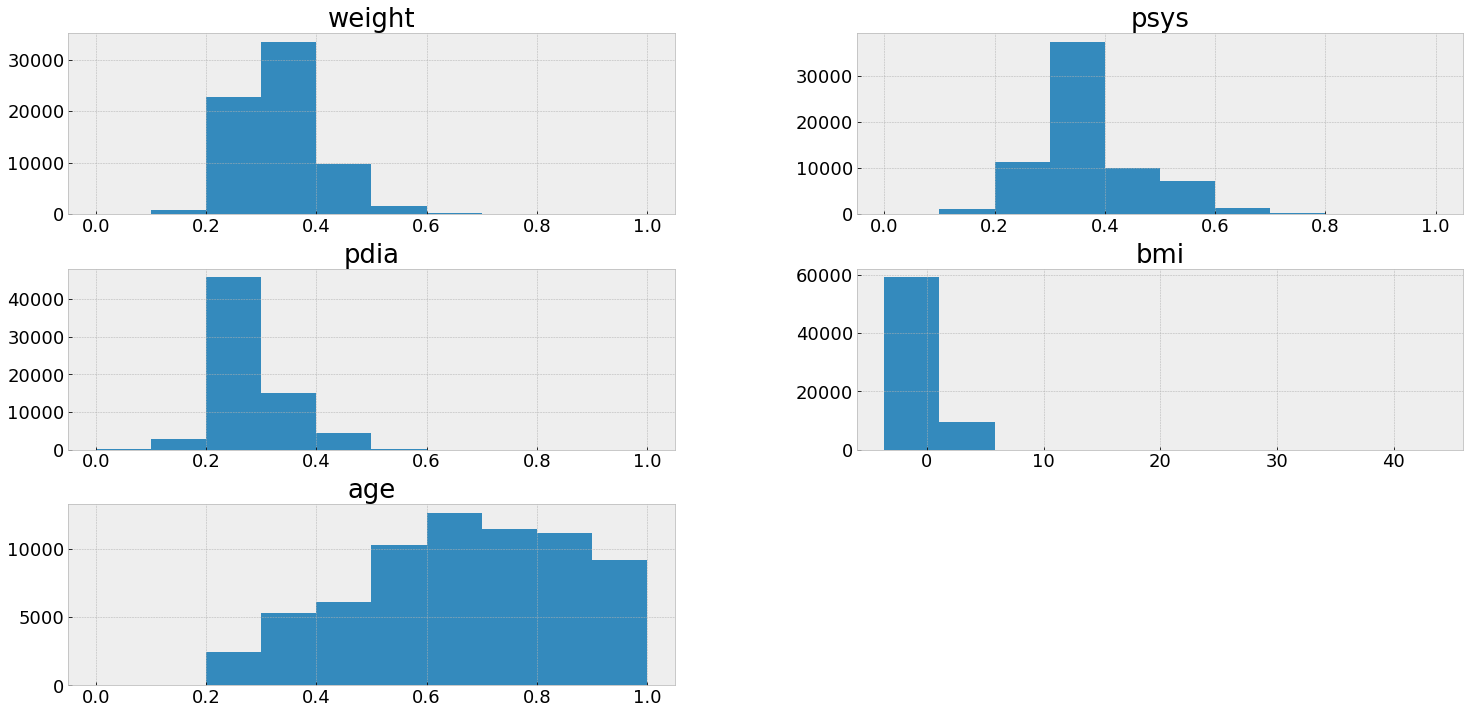

In [56]:
aux = df5[['weight', 'psys', 'pdia', 'bmi', 'age']]
aux.hist();

## 5.3 Transformação

*As variáveis discretas já são numéricas*

# 6 Seleção das features

In [57]:
df6 = df5.copy()

In [ ]:
df6.to_csv('data/interim/df6.csv', index = False)

In [5]:
df6 = pd.read_csv('data/interim/df6.csv')

## 6.1 Separar dados para treino e teste

In [6]:
df6 = df6.drop(['height', 'weight'], axis = 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df6.drop(columns = 'cardio'), 
                                                    df6['cardio'], 
                                                    test_size=0.2, 
                                                    random_state = 73)

## 6.2 Seleção com Boruta

In [ ]:
# Preparar os dados para o Boruta
X_train_b = X_train.values
y_train_b = y_train.values.ravel()

In [ ]:
rf = RandomForestRegressor(n_jobs = -1)
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 73).fit(X_train_b, y_train_b)

In [ ]:
boruta.support_

In [ ]:
# Características selecionadas
features_selected_boruta = X_train.loc[:,boruta.support_].columns.tolist()

# Características rejeitadas
features_not_selected_boruta = list(np.setdiff1d(X_train.columns, features_selected_boruta))

In [ ]:
print('Columns selected by Boruta: \n',features_selected_boruta)
print('\nColumns Not selected by Boruta: \n',features_not_selected_boruta)

## 6.3 Seleção manual

In [8]:
features_selected_boruta = ['psys', 
                            'bmi', 
                            'age', 
                            'cholesterol', # Rejeitado pelo Boruta
                            'gluc']# Rejeitado pelo Boruta

# 7 Machine learning

In [17]:
x_train = X_train[features_selected_boruta]
x_test = X_test[features_selected_boruta]

## 7.1 Regressão logística

In [62]:
# Model training
logreg = LogisticRegression(random_state = 73)
logreg.fit(x_train, y_train)

# Prediction
pred_logreg = logreg.predict(x_test)

# Performance
logreg_performance = pd.DataFrame(['Logistic Regression',
                                   metrics.accuracy_score(y_test, pred_logreg),
                                   metrics.precision_score(y_test, pred_logreg),
                                   metrics.recall_score(y_test, pred_logreg),
                                   metrics.f1_score(y_test, pred_logreg),
                                   metrics.roc_auc_score(y_test, pred_logreg)]).T
logreg_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score', 'ROC-AUC']
logreg_performance

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,Logistic Regression,0.721223,0.75656,0.651458,0.700086,0.721147


### 7.1.1 Cross-validation

In [10]:
logreg_performance_cv = cross_validation(x_train, y_train, 10, LogisticRegression(random_state = 73), 'Logistic regression', verbose = False)
logreg_performance_cv

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,Logistic regression,0.73 +- 0.01,0.75 +- 0.01,0.66 +- 0.01,0.7 +- 0.01,0.72 +- 0.01


## 7.2 Random forest

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,Random forest classifier,0.691008,0.698182,0.67172,0.684695,0.690987


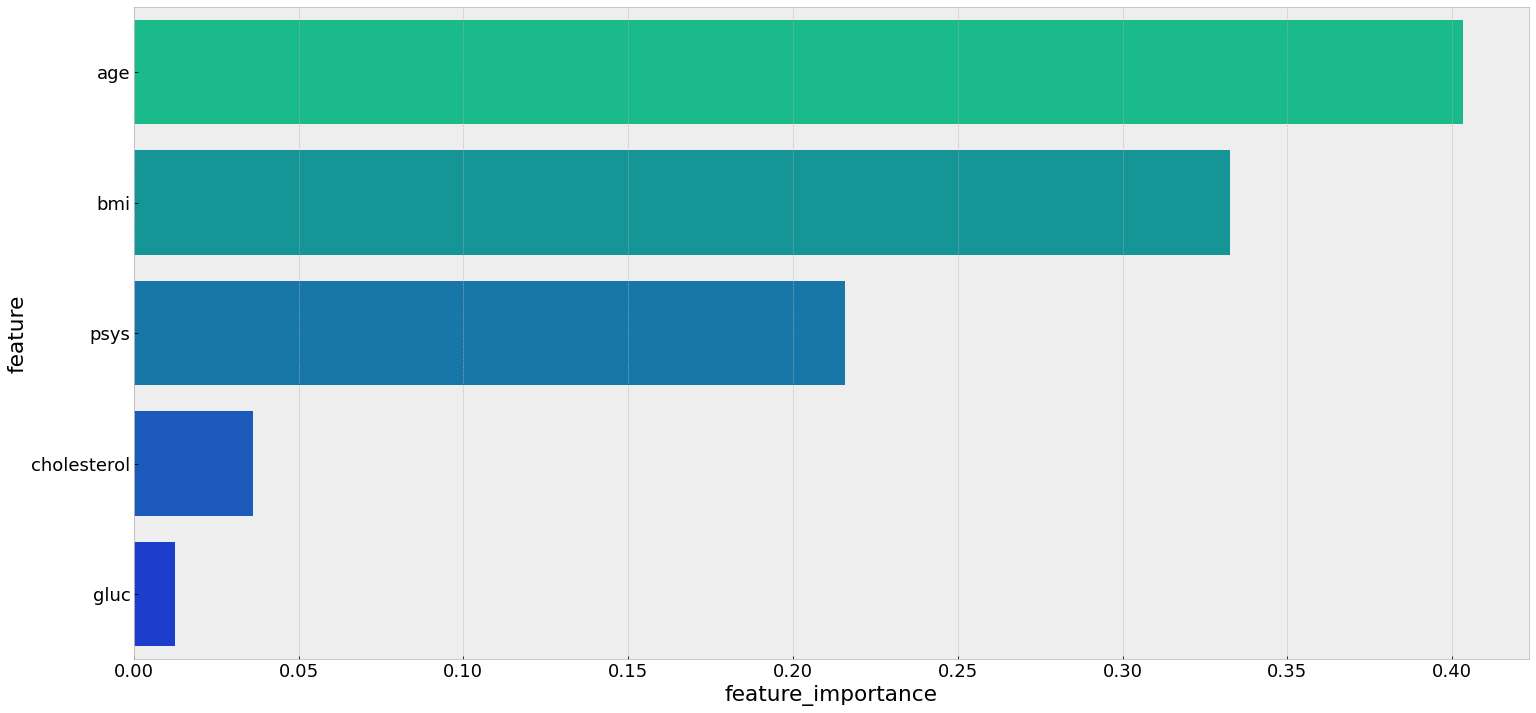

In [72]:
# Model training
rf = RandomForestClassifier(random_state = 73)
rf.fit(x_train, y_train)

# Feature importance
feat_imp = pd.DataFrame({'feature': x_train.columns,
                         'feature_importance': rf.feature_importances_})
feat_imp = feat_imp.sort_values('feature_importance', ascending = False)
sns.barplot(x = 'feature_importance', y = 'feature', data = feat_imp, palette = 'winter_r')

# Prediction
pred_rf = rf.predict(x_test)

# Performance
rf_performance = pd.DataFrame(['Random forest classifier',
                               metrics.accuracy_score(y_test, pred_rf),
                               metrics.precision_score(y_test, pred_rf),
                               metrics.recall_score(y_test, pred_rf),
                               metrics.f1_score(y_test, pred_rf),
                               metrics.roc_auc_score(y_test, pred_rf)]).T
rf_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score', 'ROC-AUC']
rf_performance

### 7.2.1 Cross-validation

In [11]:
rf_performance_cv = cross_validation(x_train, y_train, 10, RandomForestClassifier(random_state = 73), 'Random forest classifier', verbose = False)
rf_performance_cv

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,Random forest classifier,0.69 +- 0.01,0.69 +- 0.01,0.67 +- 0.01,0.68 +- 0.01,0.69 +- 0.01


## 7.3 CatBoost Classifier

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,CatBoost classifier,0.730834,0.755451,0.681778,0.716727,0.73078


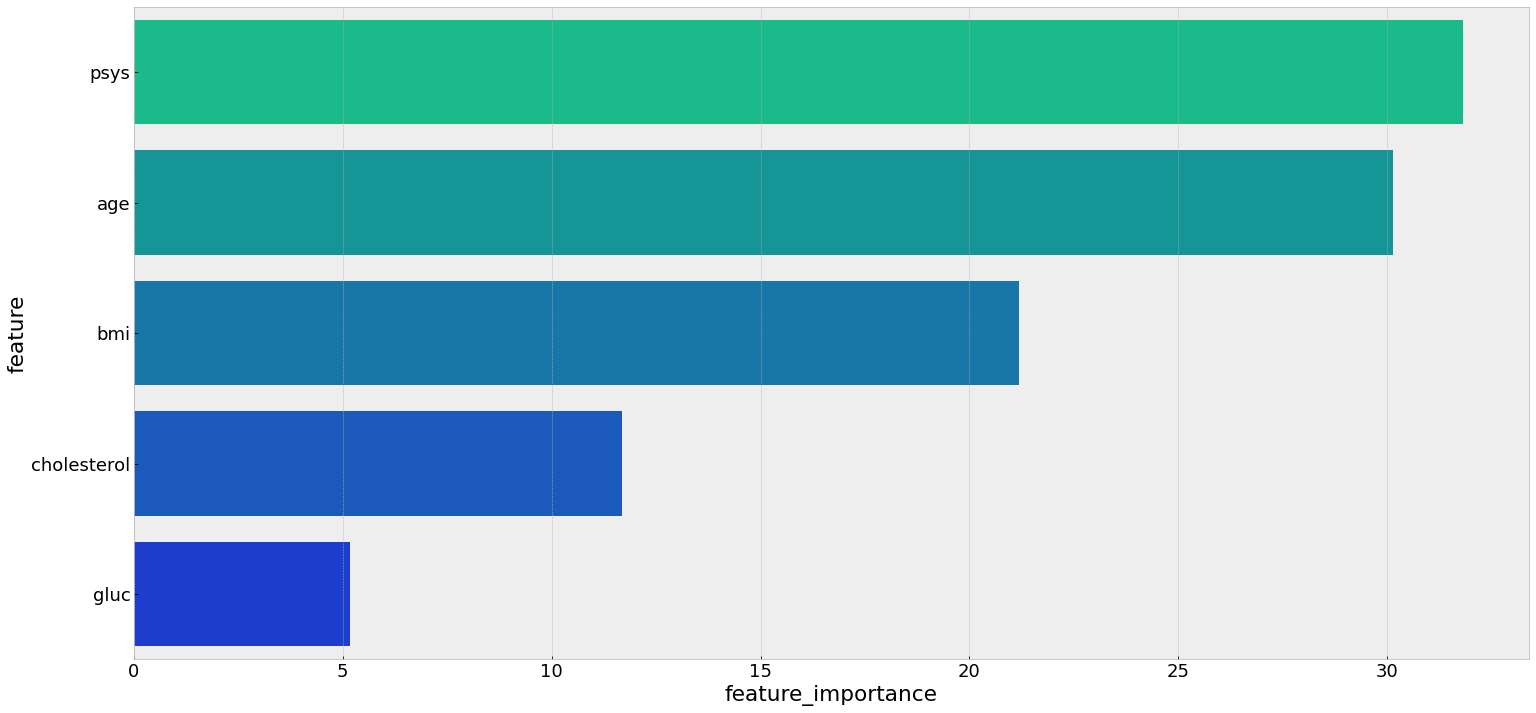

In [73]:
# Model training
cat = CatBoostClassifier(random_state = 73)
cat.fit(x_train, y_train, verbose = False)

# Feature importance
feat_imp = pd.DataFrame({'feature': x_train.columns,
                         'feature_importance': cat.feature_importances_})
feat_imp = feat_imp.sort_values('feature_importance', ascending = False)
sns.barplot(x = 'feature_importance', y = 'feature', data = feat_imp, palette = 'winter_r')

# Prediction
pred_cat = cat.predict(x_test)

# Performance
cat_performance = pd.DataFrame(['CatBoost classifier',
                                metrics.accuracy_score(y_test, pred_cat),
                                metrics.precision_score(y_test, pred_cat),
                                metrics.recall_score(y_test, pred_cat),
                                metrics.f1_score(y_test, pred_cat),
                                metrics.roc_auc_score(y_test, pred_cat)]).T
cat_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score', 'ROC-AUC']
cat_performance

### 7.3.1 Cross-validation

In [12]:
cat_performance_cv = cross_validation(x_train, y_train, 10, CatBoostClassifier(random_state = 73), 'CatBoost classifier', verbose = False)
cat_performance_cv

Learning rate set to 0.05449
0:	learn: 0.6774706	total: 329ms	remaining: 5m 28s
1:	learn: 0.6633347	total: 339ms	remaining: 2m 49s
2:	learn: 0.6509520	total: 349ms	remaining: 1m 55s
3:	learn: 0.6395414	total: 357ms	remaining: 1m 28s
4:	learn: 0.6295816	total: 365ms	remaining: 1m 12s
5:	learn: 0.6208796	total: 373ms	remaining: 1m 1s
6:	learn: 0.6129123	total: 382ms	remaining: 54.2s
7:	learn: 0.6061025	total: 391ms	remaining: 48.5s
8:	learn: 0.5998833	total: 399ms	remaining: 44s
9:	learn: 0.5942148	total: 408ms	remaining: 40.4s
10:	learn: 0.5891635	total: 416ms	remaining: 37.4s
11:	learn: 0.5850005	total: 424ms	remaining: 34.9s
12:	learn: 0.5811808	total: 431ms	remaining: 32.7s
13:	learn: 0.5777415	total: 439ms	remaining: 30.9s
14:	learn: 0.5745528	total: 447ms	remaining: 29.4s
15:	learn: 0.5714880	total: 455ms	remaining: 28s
16:	learn: 0.5690728	total: 464ms	remaining: 26.9s
17:	learn: 0.5668315	total: 473ms	remaining: 25.8s
18:	learn: 0.5647467	total: 480ms	remaining: 24.8s
19:	learn: 

175:	learn: 0.5374759	total: 1.86s	remaining: 8.7s
176:	learn: 0.5374387	total: 1.87s	remaining: 8.69s
177:	learn: 0.5373909	total: 1.88s	remaining: 8.66s
178:	learn: 0.5373811	total: 1.89s	remaining: 8.65s
179:	learn: 0.5373577	total: 1.89s	remaining: 8.63s
180:	learn: 0.5373299	total: 1.9s	remaining: 8.61s
181:	learn: 0.5373061	total: 1.91s	remaining: 8.59s
182:	learn: 0.5372917	total: 1.92s	remaining: 8.57s
183:	learn: 0.5372627	total: 1.93s	remaining: 8.56s
184:	learn: 0.5372465	total: 1.94s	remaining: 8.54s
185:	learn: 0.5372165	total: 1.95s	remaining: 8.52s
186:	learn: 0.5371849	total: 1.96s	remaining: 8.51s
187:	learn: 0.5371595	total: 1.97s	remaining: 8.49s
188:	learn: 0.5371382	total: 1.97s	remaining: 8.47s
189:	learn: 0.5371179	total: 1.98s	remaining: 8.45s
190:	learn: 0.5370920	total: 1.99s	remaining: 8.43s
191:	learn: 0.5370817	total: 2s	remaining: 8.42s
192:	learn: 0.5370439	total: 2.01s	remaining: 8.4s
193:	learn: 0.5370087	total: 2.02s	remaining: 8.39s
194:	learn: 0.5369

349:	learn: 0.5319951	total: 3.42s	remaining: 6.35s
350:	learn: 0.5319831	total: 3.43s	remaining: 6.34s
351:	learn: 0.5319445	total: 3.44s	remaining: 6.34s
352:	learn: 0.5319054	total: 3.45s	remaining: 6.33s
353:	learn: 0.5318556	total: 3.46s	remaining: 6.32s
354:	learn: 0.5318240	total: 3.47s	remaining: 6.3s
355:	learn: 0.5318043	total: 3.48s	remaining: 6.29s
356:	learn: 0.5317515	total: 3.49s	remaining: 6.28s
357:	learn: 0.5317131	total: 3.5s	remaining: 6.27s
358:	learn: 0.5316973	total: 3.5s	remaining: 6.26s
359:	learn: 0.5316645	total: 3.51s	remaining: 6.25s
360:	learn: 0.5316243	total: 3.52s	remaining: 6.23s
361:	learn: 0.5315740	total: 3.53s	remaining: 6.22s
362:	learn: 0.5315472	total: 3.54s	remaining: 6.21s
363:	learn: 0.5315233	total: 3.55s	remaining: 6.2s
364:	learn: 0.5314695	total: 3.56s	remaining: 6.19s
365:	learn: 0.5314272	total: 3.56s	remaining: 6.17s
366:	learn: 0.5314010	total: 3.57s	remaining: 6.16s
367:	learn: 0.5313779	total: 3.58s	remaining: 6.15s
368:	learn: 0.53

516:	learn: 0.5271064	total: 4.93s	remaining: 4.6s
517:	learn: 0.5270857	total: 4.94s	remaining: 4.59s
518:	learn: 0.5270600	total: 4.95s	remaining: 4.58s
519:	learn: 0.5270252	total: 4.95s	remaining: 4.57s
520:	learn: 0.5270038	total: 4.96s	remaining: 4.56s
521:	learn: 0.5269866	total: 4.97s	remaining: 4.55s
522:	learn: 0.5269469	total: 4.98s	remaining: 4.54s
523:	learn: 0.5269149	total: 4.99s	remaining: 4.53s
524:	learn: 0.5268883	total: 5s	remaining: 4.52s
525:	learn: 0.5268630	total: 5.01s	remaining: 4.51s
526:	learn: 0.5268363	total: 5.02s	remaining: 4.5s
527:	learn: 0.5268200	total: 5.02s	remaining: 4.49s
528:	learn: 0.5267865	total: 5.03s	remaining: 4.48s
529:	learn: 0.5267640	total: 5.04s	remaining: 4.47s
530:	learn: 0.5267459	total: 5.05s	remaining: 4.46s
531:	learn: 0.5267216	total: 5.06s	remaining: 4.45s
532:	learn: 0.5266917	total: 5.07s	remaining: 4.44s
533:	learn: 0.5266720	total: 5.08s	remaining: 4.43s
534:	learn: 0.5266620	total: 5.08s	remaining: 4.42s
535:	learn: 0.526

681:	learn: 0.5228633	total: 6.41s	remaining: 2.99s
682:	learn: 0.5228490	total: 6.42s	remaining: 2.98s
683:	learn: 0.5228245	total: 6.43s	remaining: 2.97s
684:	learn: 0.5228028	total: 6.44s	remaining: 2.96s
685:	learn: 0.5227753	total: 6.45s	remaining: 2.95s
686:	learn: 0.5227405	total: 6.46s	remaining: 2.94s
687:	learn: 0.5226899	total: 6.47s	remaining: 2.93s
688:	learn: 0.5226550	total: 6.48s	remaining: 2.92s
689:	learn: 0.5226522	total: 6.49s	remaining: 2.92s
690:	learn: 0.5226239	total: 6.5s	remaining: 2.9s
691:	learn: 0.5226084	total: 6.5s	remaining: 2.9s
692:	learn: 0.5225831	total: 6.51s	remaining: 2.88s
693:	learn: 0.5225579	total: 6.52s	remaining: 2.88s
694:	learn: 0.5225362	total: 6.53s	remaining: 2.87s
695:	learn: 0.5225161	total: 6.54s	remaining: 2.86s
696:	learn: 0.5224995	total: 6.55s	remaining: 2.85s
697:	learn: 0.5224834	total: 6.56s	remaining: 2.84s
698:	learn: 0.5224528	total: 6.57s	remaining: 2.83s
699:	learn: 0.5224389	total: 6.58s	remaining: 2.82s
700:	learn: 0.52

845:	learn: 0.5189328	total: 7.93s	remaining: 1.44s
846:	learn: 0.5188966	total: 7.94s	remaining: 1.43s
847:	learn: 0.5188702	total: 7.95s	remaining: 1.42s
848:	learn: 0.5188465	total: 7.96s	remaining: 1.42s
849:	learn: 0.5188103	total: 7.97s	remaining: 1.41s
850:	learn: 0.5187752	total: 7.98s	remaining: 1.4s
851:	learn: 0.5187380	total: 7.99s	remaining: 1.39s
852:	learn: 0.5187287	total: 8s	remaining: 1.38s
853:	learn: 0.5187049	total: 8s	remaining: 1.37s
854:	learn: 0.5186860	total: 8.01s	remaining: 1.36s
855:	learn: 0.5186662	total: 8.02s	remaining: 1.35s
856:	learn: 0.5186500	total: 8.03s	remaining: 1.34s
857:	learn: 0.5186243	total: 8.04s	remaining: 1.33s
858:	learn: 0.5185975	total: 8.05s	remaining: 1.32s
859:	learn: 0.5185900	total: 8.05s	remaining: 1.31s
860:	learn: 0.5185678	total: 8.06s	remaining: 1.3s
861:	learn: 0.5185475	total: 8.07s	remaining: 1.29s
862:	learn: 0.5185322	total: 8.08s	remaining: 1.28s
863:	learn: 0.5185055	total: 8.09s	remaining: 1.27s
864:	learn: 0.518485

21:	learn: 0.5596550	total: 188ms	remaining: 8.35s
22:	learn: 0.5581873	total: 196ms	remaining: 8.35s
23:	learn: 0.5566661	total: 204ms	remaining: 8.29s
24:	learn: 0.5554957	total: 212ms	remaining: 8.25s
25:	learn: 0.5543773	total: 220ms	remaining: 8.24s
26:	learn: 0.5534414	total: 228ms	remaining: 8.2s
27:	learn: 0.5524474	total: 235ms	remaining: 8.15s
28:	learn: 0.5515946	total: 243ms	remaining: 8.15s
29:	learn: 0.5508042	total: 252ms	remaining: 8.15s
30:	learn: 0.5501062	total: 259ms	remaining: 8.11s
31:	learn: 0.5495443	total: 268ms	remaining: 8.11s
32:	learn: 0.5489777	total: 277ms	remaining: 8.11s
33:	learn: 0.5484331	total: 285ms	remaining: 8.11s
34:	learn: 0.5479928	total: 293ms	remaining: 8.09s
35:	learn: 0.5475379	total: 303ms	remaining: 8.12s
36:	learn: 0.5471005	total: 312ms	remaining: 8.13s
37:	learn: 0.5466648	total: 321ms	remaining: 8.13s
38:	learn: 0.5463523	total: 330ms	remaining: 8.14s
39:	learn: 0.5459774	total: 338ms	remaining: 8.12s
40:	learn: 0.5456299	total: 347m

194:	learn: 0.5366510	total: 2.13s	remaining: 8.81s
195:	learn: 0.5366203	total: 2.15s	remaining: 8.82s
196:	learn: 0.5365828	total: 2.16s	remaining: 8.82s
197:	learn: 0.5365526	total: 2.18s	remaining: 8.82s
198:	learn: 0.5365314	total: 2.19s	remaining: 8.82s
199:	learn: 0.5364981	total: 2.21s	remaining: 8.83s
200:	learn: 0.5364545	total: 2.22s	remaining: 8.84s
201:	learn: 0.5364172	total: 2.24s	remaining: 8.85s
202:	learn: 0.5363838	total: 2.26s	remaining: 8.86s
203:	learn: 0.5363584	total: 2.27s	remaining: 8.87s
204:	learn: 0.5363207	total: 2.29s	remaining: 8.87s
205:	learn: 0.5362773	total: 2.3s	remaining: 8.88s
206:	learn: 0.5362416	total: 2.32s	remaining: 8.89s
207:	learn: 0.5362151	total: 2.34s	remaining: 8.91s
208:	learn: 0.5361847	total: 2.35s	remaining: 8.91s
209:	learn: 0.5361561	total: 2.37s	remaining: 8.92s
210:	learn: 0.5361288	total: 2.39s	remaining: 8.93s
211:	learn: 0.5360855	total: 2.4s	remaining: 8.94s
212:	learn: 0.5360463	total: 2.42s	remaining: 8.95s
213:	learn: 0.

357:	learn: 0.5313376	total: 4.51s	remaining: 8.1s
358:	learn: 0.5313153	total: 4.53s	remaining: 8.09s
359:	learn: 0.5312826	total: 4.54s	remaining: 8.07s
360:	learn: 0.5312495	total: 4.55s	remaining: 8.06s
361:	learn: 0.5312290	total: 4.57s	remaining: 8.05s
362:	learn: 0.5311977	total: 4.58s	remaining: 8.04s
363:	learn: 0.5311685	total: 4.59s	remaining: 8.03s
364:	learn: 0.5311297	total: 4.61s	remaining: 8.02s
365:	learn: 0.5311069	total: 4.62s	remaining: 8s
366:	learn: 0.5310633	total: 4.63s	remaining: 7.99s
367:	learn: 0.5310262	total: 4.65s	remaining: 7.98s
368:	learn: 0.5309917	total: 4.66s	remaining: 7.97s
369:	learn: 0.5309604	total: 4.67s	remaining: 7.96s
370:	learn: 0.5309207	total: 4.69s	remaining: 7.95s
371:	learn: 0.5308842	total: 4.7s	remaining: 7.93s
372:	learn: 0.5308510	total: 4.71s	remaining: 7.92s
373:	learn: 0.5308199	total: 4.73s	remaining: 7.91s
374:	learn: 0.5307849	total: 4.74s	remaining: 7.9s
375:	learn: 0.5307626	total: 4.75s	remaining: 7.89s
376:	learn: 0.5307

517:	learn: 0.5267922	total: 6.71s	remaining: 6.24s
518:	learn: 0.5267613	total: 6.72s	remaining: 6.23s
519:	learn: 0.5267242	total: 6.74s	remaining: 6.22s
520:	learn: 0.5266725	total: 6.75s	remaining: 6.2s
521:	learn: 0.5266438	total: 6.76s	remaining: 6.19s
522:	learn: 0.5266277	total: 6.77s	remaining: 6.18s
523:	learn: 0.5266056	total: 6.79s	remaining: 6.17s
524:	learn: 0.5265648	total: 6.8s	remaining: 6.15s
525:	learn: 0.5265435	total: 6.81s	remaining: 6.14s
526:	learn: 0.5265250	total: 6.83s	remaining: 6.13s
527:	learn: 0.5265021	total: 6.84s	remaining: 6.11s
528:	learn: 0.5264669	total: 6.85s	remaining: 6.1s
529:	learn: 0.5264541	total: 6.86s	remaining: 6.09s
530:	learn: 0.5264239	total: 6.88s	remaining: 6.07s
531:	learn: 0.5264062	total: 6.89s	remaining: 6.06s
532:	learn: 0.5263880	total: 6.91s	remaining: 6.05s
533:	learn: 0.5263556	total: 6.92s	remaining: 6.04s
534:	learn: 0.5263304	total: 6.94s	remaining: 6.03s
535:	learn: 0.5263030	total: 6.95s	remaining: 6.02s
536:	learn: 0.5

688:	learn: 0.5223292	total: 9.1s	remaining: 4.11s
689:	learn: 0.5223099	total: 9.12s	remaining: 4.09s
690:	learn: 0.5222762	total: 9.13s	remaining: 4.08s
691:	learn: 0.5222592	total: 9.14s	remaining: 4.07s
692:	learn: 0.5222387	total: 9.16s	remaining: 4.06s
693:	learn: 0.5222043	total: 9.17s	remaining: 4.04s
694:	learn: 0.5221647	total: 9.19s	remaining: 4.03s
695:	learn: 0.5221263	total: 9.2s	remaining: 4.02s
696:	learn: 0.5220979	total: 9.21s	remaining: 4s
697:	learn: 0.5220745	total: 9.22s	remaining: 3.99s
698:	learn: 0.5220547	total: 9.24s	remaining: 3.98s
699:	learn: 0.5220162	total: 9.25s	remaining: 3.96s
700:	learn: 0.5219879	total: 9.26s	remaining: 3.95s
701:	learn: 0.5219551	total: 9.28s	remaining: 3.94s
702:	learn: 0.5219276	total: 9.29s	remaining: 3.92s
703:	learn: 0.5219088	total: 9.3s	remaining: 3.91s
704:	learn: 0.5218916	total: 9.32s	remaining: 3.9s
705:	learn: 0.5218678	total: 9.33s	remaining: 3.89s
706:	learn: 0.5218260	total: 9.35s	remaining: 3.87s
707:	learn: 0.52181

849:	learn: 0.5184823	total: 11.3s	remaining: 1.99s
850:	learn: 0.5184672	total: 11.3s	remaining: 1.98s
851:	learn: 0.5184441	total: 11.3s	remaining: 1.97s
852:	learn: 0.5184124	total: 11.3s	remaining: 1.95s
853:	learn: 0.5183898	total: 11.4s	remaining: 1.94s
854:	learn: 0.5183631	total: 11.4s	remaining: 1.93s
855:	learn: 0.5183284	total: 11.4s	remaining: 1.92s
856:	learn: 0.5183242	total: 11.4s	remaining: 1.9s
857:	learn: 0.5183045	total: 11.4s	remaining: 1.89s
858:	learn: 0.5182704	total: 11.4s	remaining: 1.88s
859:	learn: 0.5182423	total: 11.4s	remaining: 1.86s
860:	learn: 0.5182257	total: 11.5s	remaining: 1.85s
861:	learn: 0.5182123	total: 11.5s	remaining: 1.84s
862:	learn: 0.5181790	total: 11.5s	remaining: 1.82s
863:	learn: 0.5181517	total: 11.5s	remaining: 1.81s
864:	learn: 0.5181191	total: 11.5s	remaining: 1.8s
865:	learn: 0.5180969	total: 11.5s	remaining: 1.78s
866:	learn: 0.5180827	total: 11.5s	remaining: 1.77s
867:	learn: 0.5180651	total: 11.6s	remaining: 1.76s
868:	learn: 0.

15:	learn: 0.5718683	total: 188ms	remaining: 11.5s
16:	learn: 0.5693529	total: 199ms	remaining: 11.5s
17:	learn: 0.5670690	total: 209ms	remaining: 11.4s
18:	learn: 0.5649467	total: 218ms	remaining: 11.3s
19:	learn: 0.5631324	total: 229ms	remaining: 11.2s
20:	learn: 0.5615689	total: 239ms	remaining: 11.1s
21:	learn: 0.5602137	total: 247ms	remaining: 11s
22:	learn: 0.5587258	total: 260ms	remaining: 11s
23:	learn: 0.5574085	total: 270ms	remaining: 11s
24:	learn: 0.5563027	total: 281ms	remaining: 11s
25:	learn: 0.5554455	total: 294ms	remaining: 11s
26:	learn: 0.5545148	total: 304ms	remaining: 11s
27:	learn: 0.5535125	total: 317ms	remaining: 11s
28:	learn: 0.5527166	total: 329ms	remaining: 11s
29:	learn: 0.5519509	total: 340ms	remaining: 11s
30:	learn: 0.5512115	total: 350ms	remaining: 10.9s
31:	learn: 0.5505628	total: 363ms	remaining: 11s
32:	learn: 0.5499958	total: 373ms	remaining: 10.9s
33:	learn: 0.5494305	total: 386ms	remaining: 11s
34:	learn: 0.5489664	total: 399ms	remaining: 11s
35:	

187:	learn: 0.5375690	total: 2.39s	remaining: 10.3s
188:	learn: 0.5375471	total: 2.4s	remaining: 10.3s
189:	learn: 0.5375031	total: 2.41s	remaining: 10.3s
190:	learn: 0.5374679	total: 2.43s	remaining: 10.3s
191:	learn: 0.5374412	total: 2.44s	remaining: 10.3s
192:	learn: 0.5374240	total: 2.45s	remaining: 10.3s
193:	learn: 0.5374205	total: 2.46s	remaining: 10.2s
194:	learn: 0.5373807	total: 2.48s	remaining: 10.2s
195:	learn: 0.5373428	total: 2.49s	remaining: 10.2s
196:	learn: 0.5373152	total: 2.5s	remaining: 10.2s
197:	learn: 0.5372864	total: 2.51s	remaining: 10.2s
198:	learn: 0.5372644	total: 2.52s	remaining: 10.2s
199:	learn: 0.5372201	total: 2.54s	remaining: 10.2s
200:	learn: 0.5371827	total: 2.55s	remaining: 10.1s
201:	learn: 0.5371517	total: 2.56s	remaining: 10.1s
202:	learn: 0.5371139	total: 2.58s	remaining: 10.1s
203:	learn: 0.5370853	total: 2.59s	remaining: 10.1s
204:	learn: 0.5370415	total: 2.61s	remaining: 10.1s
205:	learn: 0.5370228	total: 2.62s	remaining: 10.1s
206:	learn: 0.

359:	learn: 0.5318197	total: 4.7s	remaining: 8.36s
360:	learn: 0.5317880	total: 4.71s	remaining: 8.34s
361:	learn: 0.5317409	total: 4.73s	remaining: 8.33s
362:	learn: 0.5317163	total: 4.74s	remaining: 8.32s
363:	learn: 0.5316785	total: 4.75s	remaining: 8.3s
364:	learn: 0.5316515	total: 4.76s	remaining: 8.29s
365:	learn: 0.5316122	total: 4.78s	remaining: 8.28s
366:	learn: 0.5315691	total: 4.79s	remaining: 8.26s
367:	learn: 0.5315310	total: 4.8s	remaining: 8.25s
368:	learn: 0.5314991	total: 4.82s	remaining: 8.24s
369:	learn: 0.5314552	total: 4.83s	remaining: 8.22s
370:	learn: 0.5314300	total: 4.84s	remaining: 8.21s
371:	learn: 0.5314054	total: 4.86s	remaining: 8.2s
372:	learn: 0.5313791	total: 4.87s	remaining: 8.18s
373:	learn: 0.5313441	total: 4.88s	remaining: 8.17s
374:	learn: 0.5313055	total: 4.89s	remaining: 8.15s
375:	learn: 0.5312845	total: 4.91s	remaining: 8.15s
376:	learn: 0.5312265	total: 4.92s	remaining: 8.14s
377:	learn: 0.5312085	total: 4.94s	remaining: 8.12s
378:	learn: 0.53

523:	learn: 0.5270193	total: 6.9s	remaining: 6.27s
524:	learn: 0.5269861	total: 6.91s	remaining: 6.25s
525:	learn: 0.5269618	total: 6.92s	remaining: 6.24s
526:	learn: 0.5269175	total: 6.94s	remaining: 6.23s
527:	learn: 0.5269028	total: 6.95s	remaining: 6.21s
528:	learn: 0.5268809	total: 6.96s	remaining: 6.2s
529:	learn: 0.5268247	total: 6.98s	remaining: 6.19s
530:	learn: 0.5268115	total: 6.99s	remaining: 6.17s
531:	learn: 0.5267851	total: 7s	remaining: 6.16s
532:	learn: 0.5267680	total: 7.01s	remaining: 6.15s
533:	learn: 0.5267270	total: 7.03s	remaining: 6.13s
534:	learn: 0.5267052	total: 7.04s	remaining: 6.12s
535:	learn: 0.5266743	total: 7.05s	remaining: 6.11s
536:	learn: 0.5266644	total: 7.07s	remaining: 6.09s
537:	learn: 0.5266396	total: 7.08s	remaining: 6.08s
538:	learn: 0.5265921	total: 7.1s	remaining: 6.07s
539:	learn: 0.5265666	total: 7.11s	remaining: 6.06s
540:	learn: 0.5265436	total: 7.13s	remaining: 6.05s
541:	learn: 0.5265178	total: 7.14s	remaining: 6.04s
542:	learn: 0.5264

686:	learn: 0.5226347	total: 9.11s	remaining: 4.15s
687:	learn: 0.5226124	total: 9.12s	remaining: 4.14s
688:	learn: 0.5225617	total: 9.14s	remaining: 4.12s
689:	learn: 0.5225444	total: 9.15s	remaining: 4.11s
690:	learn: 0.5225180	total: 9.17s	remaining: 4.1s
691:	learn: 0.5224980	total: 9.18s	remaining: 4.09s
692:	learn: 0.5224708	total: 9.2s	remaining: 4.07s
693:	learn: 0.5224447	total: 9.21s	remaining: 4.06s
694:	learn: 0.5224277	total: 9.22s	remaining: 4.05s
695:	learn: 0.5224038	total: 9.24s	remaining: 4.03s
696:	learn: 0.5223787	total: 9.25s	remaining: 4.02s
697:	learn: 0.5223537	total: 9.26s	remaining: 4.01s
698:	learn: 0.5223181	total: 9.28s	remaining: 3.99s
699:	learn: 0.5223063	total: 9.29s	remaining: 3.98s
700:	learn: 0.5222781	total: 9.3s	remaining: 3.97s
701:	learn: 0.5222528	total: 9.32s	remaining: 3.96s
702:	learn: 0.5222244	total: 9.33s	remaining: 3.94s
703:	learn: 0.5221946	total: 9.34s	remaining: 3.93s
704:	learn: 0.5221662	total: 9.36s	remaining: 3.92s
705:	learn: 0.5

859:	learn: 0.5183942	total: 11.5s	remaining: 1.87s
860:	learn: 0.5183785	total: 11.5s	remaining: 1.86s
861:	learn: 0.5183608	total: 11.5s	remaining: 1.84s
862:	learn: 0.5183275	total: 11.5s	remaining: 1.83s
863:	learn: 0.5183099	total: 11.6s	remaining: 1.82s
864:	learn: 0.5182840	total: 11.6s	remaining: 1.8s
865:	learn: 0.5182557	total: 11.6s	remaining: 1.79s
866:	learn: 0.5182278	total: 11.6s	remaining: 1.78s
867:	learn: 0.5182028	total: 11.6s	remaining: 1.76s
868:	learn: 0.5181775	total: 11.6s	remaining: 1.75s
869:	learn: 0.5181570	total: 11.6s	remaining: 1.74s
870:	learn: 0.5181390	total: 11.7s	remaining: 1.73s
871:	learn: 0.5181170	total: 11.7s	remaining: 1.71s
872:	learn: 0.5180942	total: 11.7s	remaining: 1.7s
873:	learn: 0.5180766	total: 11.7s	remaining: 1.69s
874:	learn: 0.5180490	total: 11.7s	remaining: 1.67s
875:	learn: 0.5180193	total: 11.7s	remaining: 1.66s
876:	learn: 0.5179973	total: 11.7s	remaining: 1.65s
877:	learn: 0.5179766	total: 11.7s	remaining: 1.63s
878:	learn: 0.

34:	learn: 0.5498260	total: 370ms	remaining: 10.2s
35:	learn: 0.5493232	total: 383ms	remaining: 10.2s
36:	learn: 0.5489049	total: 394ms	remaining: 10.3s
37:	learn: 0.5485009	total: 406ms	remaining: 10.3s
38:	learn: 0.5481307	total: 416ms	remaining: 10.3s
39:	learn: 0.5478288	total: 429ms	remaining: 10.3s
40:	learn: 0.5474729	total: 441ms	remaining: 10.3s
41:	learn: 0.5471715	total: 453ms	remaining: 10.3s
42:	learn: 0.5469074	total: 467ms	remaining: 10.4s
43:	learn: 0.5466735	total: 480ms	remaining: 10.4s
44:	learn: 0.5464047	total: 494ms	remaining: 10.5s
45:	learn: 0.5461556	total: 505ms	remaining: 10.5s
46:	learn: 0.5459440	total: 518ms	remaining: 10.5s
47:	learn: 0.5457336	total: 531ms	remaining: 10.5s
48:	learn: 0.5455480	total: 544ms	remaining: 10.6s
49:	learn: 0.5453417	total: 558ms	remaining: 10.6s
50:	learn: 0.5451645	total: 575ms	remaining: 10.7s
51:	learn: 0.5449929	total: 586ms	remaining: 10.7s
52:	learn: 0.5448026	total: 600ms	remaining: 10.7s
53:	learn: 0.5446551	total: 610

198:	learn: 0.5382886	total: 2.8s	remaining: 11.3s
199:	learn: 0.5382556	total: 2.81s	remaining: 11.3s
200:	learn: 0.5382167	total: 2.83s	remaining: 11.3s
201:	learn: 0.5381668	total: 2.85s	remaining: 11.3s
202:	learn: 0.5381358	total: 2.87s	remaining: 11.3s
203:	learn: 0.5381112	total: 2.88s	remaining: 11.2s
204:	learn: 0.5380777	total: 2.9s	remaining: 11.2s
205:	learn: 0.5380352	total: 2.92s	remaining: 11.2s
206:	learn: 0.5380043	total: 2.93s	remaining: 11.2s
207:	learn: 0.5379635	total: 2.95s	remaining: 11.2s
208:	learn: 0.5379248	total: 2.96s	remaining: 11.2s
209:	learn: 0.5379038	total: 2.98s	remaining: 11.2s
210:	learn: 0.5378734	total: 2.99s	remaining: 11.2s
211:	learn: 0.5378220	total: 3s	remaining: 11.2s
212:	learn: 0.5377751	total: 3.02s	remaining: 11.2s
213:	learn: 0.5377332	total: 3.03s	remaining: 11.1s
214:	learn: 0.5376990	total: 3.05s	remaining: 11.1s
215:	learn: 0.5376782	total: 3.07s	remaining: 11.1s
216:	learn: 0.5376212	total: 3.09s	remaining: 11.1s
217:	learn: 0.537

358:	learn: 0.5329050	total: 5s	remaining: 8.93s
359:	learn: 0.5328721	total: 5.01s	remaining: 8.91s
360:	learn: 0.5328506	total: 5.03s	remaining: 8.89s
361:	learn: 0.5328107	total: 5.04s	remaining: 8.88s
362:	learn: 0.5327890	total: 5.05s	remaining: 8.86s
363:	learn: 0.5327664	total: 5.06s	remaining: 8.85s
364:	learn: 0.5327459	total: 5.08s	remaining: 8.83s
365:	learn: 0.5327298	total: 5.09s	remaining: 8.81s
366:	learn: 0.5326932	total: 5.1s	remaining: 8.8s
367:	learn: 0.5326717	total: 5.11s	remaining: 8.78s
368:	learn: 0.5326367	total: 5.13s	remaining: 8.77s
369:	learn: 0.5325935	total: 5.14s	remaining: 8.75s
370:	learn: 0.5325562	total: 5.15s	remaining: 8.74s
371:	learn: 0.5325256	total: 5.17s	remaining: 8.72s
372:	learn: 0.5324837	total: 5.18s	remaining: 8.71s
373:	learn: 0.5324660	total: 5.2s	remaining: 8.7s
374:	learn: 0.5324214	total: 5.21s	remaining: 8.68s
375:	learn: 0.5323907	total: 5.22s	remaining: 8.67s
376:	learn: 0.5323711	total: 5.24s	remaining: 8.65s
377:	learn: 0.53233

522:	learn: 0.5281780	total: 7.19s	remaining: 6.56s
523:	learn: 0.5281444	total: 7.21s	remaining: 6.54s
524:	learn: 0.5281167	total: 7.22s	remaining: 6.53s
525:	learn: 0.5280948	total: 7.23s	remaining: 6.52s
526:	learn: 0.5280574	total: 7.25s	remaining: 6.5s
527:	learn: 0.5280391	total: 7.26s	remaining: 6.49s
528:	learn: 0.5280145	total: 7.27s	remaining: 6.47s
529:	learn: 0.5279760	total: 7.29s	remaining: 6.46s
530:	learn: 0.5279554	total: 7.3s	remaining: 6.45s
531:	learn: 0.5279153	total: 7.32s	remaining: 6.44s
532:	learn: 0.5278866	total: 7.33s	remaining: 6.42s
533:	learn: 0.5278556	total: 7.34s	remaining: 6.41s
534:	learn: 0.5278423	total: 7.36s	remaining: 6.39s
535:	learn: 0.5278018	total: 7.37s	remaining: 6.38s
536:	learn: 0.5277662	total: 7.38s	remaining: 6.37s
537:	learn: 0.5277322	total: 7.4s	remaining: 6.35s
538:	learn: 0.5277109	total: 7.41s	remaining: 6.34s
539:	learn: 0.5276856	total: 7.43s	remaining: 6.33s
540:	learn: 0.5276533	total: 7.44s	remaining: 6.31s
541:	learn: 0.5

684:	learn: 0.5237432	total: 9.39s	remaining: 4.32s
685:	learn: 0.5237176	total: 9.4s	remaining: 4.3s
686:	learn: 0.5236976	total: 9.42s	remaining: 4.29s
687:	learn: 0.5236702	total: 9.43s	remaining: 4.28s
688:	learn: 0.5236439	total: 9.45s	remaining: 4.26s
689:	learn: 0.5236216	total: 9.46s	remaining: 4.25s
690:	learn: 0.5236024	total: 9.47s	remaining: 4.24s
691:	learn: 0.5235809	total: 9.49s	remaining: 4.22s
692:	learn: 0.5235524	total: 9.5s	remaining: 4.21s
693:	learn: 0.5235252	total: 9.51s	remaining: 4.2s
694:	learn: 0.5235143	total: 9.53s	remaining: 4.18s
695:	learn: 0.5234825	total: 9.54s	remaining: 4.17s
696:	learn: 0.5234605	total: 9.55s	remaining: 4.15s
697:	learn: 0.5234327	total: 9.57s	remaining: 4.14s
698:	learn: 0.5234094	total: 9.58s	remaining: 4.13s
699:	learn: 0.5233935	total: 9.6s	remaining: 4.11s
700:	learn: 0.5233817	total: 9.61s	remaining: 4.1s
701:	learn: 0.5233561	total: 9.62s	remaining: 4.08s
702:	learn: 0.5233318	total: 9.63s	remaining: 4.07s
703:	learn: 0.5233

846:	learn: 0.5197344	total: 11.6s	remaining: 2.09s
847:	learn: 0.5197115	total: 11.6s	remaining: 2.08s
848:	learn: 0.5196919	total: 11.6s	remaining: 2.07s
849:	learn: 0.5196697	total: 11.6s	remaining: 2.05s
850:	learn: 0.5196419	total: 11.6s	remaining: 2.04s
851:	learn: 0.5196308	total: 11.7s	remaining: 2.02s
852:	learn: 0.5195988	total: 11.7s	remaining: 2.01s
853:	learn: 0.5195725	total: 11.7s	remaining: 2s
854:	learn: 0.5195647	total: 11.7s	remaining: 1.98s
855:	learn: 0.5195394	total: 11.7s	remaining: 1.97s
856:	learn: 0.5195156	total: 11.7s	remaining: 1.96s
857:	learn: 0.5195051	total: 11.7s	remaining: 1.94s
858:	learn: 0.5194943	total: 11.8s	remaining: 1.93s
859:	learn: 0.5194737	total: 11.8s	remaining: 1.91s
860:	learn: 0.5194629	total: 11.8s	remaining: 1.9s
861:	learn: 0.5194245	total: 11.8s	remaining: 1.89s
862:	learn: 0.5193868	total: 11.8s	remaining: 1.87s
863:	learn: 0.5193680	total: 11.8s	remaining: 1.86s
864:	learn: 0.5193529	total: 11.8s	remaining: 1.85s
865:	learn: 0.51

19:	learn: 0.5608094	total: 187ms	remaining: 9.18s
20:	learn: 0.5589223	total: 197ms	remaining: 9.19s
21:	learn: 0.5574338	total: 208ms	remaining: 9.25s
22:	learn: 0.5559531	total: 217ms	remaining: 9.23s
23:	learn: 0.5546323	total: 228ms	remaining: 9.27s
24:	learn: 0.5534956	total: 241ms	remaining: 9.39s
25:	learn: 0.5526221	total: 252ms	remaining: 9.45s
26:	learn: 0.5517098	total: 263ms	remaining: 9.46s
27:	learn: 0.5507980	total: 275ms	remaining: 9.55s
28:	learn: 0.5499284	total: 287ms	remaining: 9.59s
29:	learn: 0.5491990	total: 297ms	remaining: 9.62s
30:	learn: 0.5484362	total: 310ms	remaining: 9.68s
31:	learn: 0.5478470	total: 322ms	remaining: 9.73s
32:	learn: 0.5472383	total: 332ms	remaining: 9.73s
33:	learn: 0.5466534	total: 344ms	remaining: 9.78s
34:	learn: 0.5460573	total: 356ms	remaining: 9.83s
35:	learn: 0.5457086	total: 366ms	remaining: 9.81s
36:	learn: 0.5452699	total: 379ms	remaining: 9.88s
37:	learn: 0.5448102	total: 392ms	remaining: 9.93s
38:	learn: 0.5445298	total: 401

189:	learn: 0.5347840	total: 2.38s	remaining: 10.1s
190:	learn: 0.5347636	total: 2.39s	remaining: 10.1s
191:	learn: 0.5347412	total: 2.41s	remaining: 10.1s
192:	learn: 0.5347113	total: 2.42s	remaining: 10.1s
193:	learn: 0.5346883	total: 2.44s	remaining: 10.1s
194:	learn: 0.5346446	total: 2.45s	remaining: 10.1s
195:	learn: 0.5346168	total: 2.47s	remaining: 10.1s
196:	learn: 0.5345841	total: 2.48s	remaining: 10.1s
197:	learn: 0.5345572	total: 2.5s	remaining: 10.1s
198:	learn: 0.5345229	total: 2.52s	remaining: 10.1s
199:	learn: 0.5344973	total: 2.53s	remaining: 10.1s
200:	learn: 0.5344627	total: 2.55s	remaining: 10.1s
201:	learn: 0.5344265	total: 2.56s	remaining: 10.1s
202:	learn: 0.5343820	total: 2.58s	remaining: 10.1s
203:	learn: 0.5343338	total: 2.6s	remaining: 10.1s
204:	learn: 0.5343058	total: 2.61s	remaining: 10.1s
205:	learn: 0.5342761	total: 2.63s	remaining: 10.1s
206:	learn: 0.5342389	total: 2.65s	remaining: 10.1s
207:	learn: 0.5341921	total: 2.66s	remaining: 10.1s
208:	learn: 0.

350:	learn: 0.5293112	total: 4.59s	remaining: 8.49s
351:	learn: 0.5292819	total: 4.61s	remaining: 8.48s
352:	learn: 0.5292438	total: 4.62s	remaining: 8.47s
353:	learn: 0.5292072	total: 4.63s	remaining: 8.46s
354:	learn: 0.5291815	total: 4.65s	remaining: 8.44s
355:	learn: 0.5291658	total: 4.66s	remaining: 8.43s
356:	learn: 0.5291299	total: 4.67s	remaining: 8.41s
357:	learn: 0.5290870	total: 4.68s	remaining: 8.4s
358:	learn: 0.5290519	total: 4.7s	remaining: 8.39s
359:	learn: 0.5290201	total: 4.71s	remaining: 8.38s
360:	learn: 0.5289921	total: 4.73s	remaining: 8.37s
361:	learn: 0.5289673	total: 4.74s	remaining: 8.35s
362:	learn: 0.5289370	total: 4.75s	remaining: 8.34s
363:	learn: 0.5289061	total: 4.77s	remaining: 8.33s
364:	learn: 0.5288686	total: 4.78s	remaining: 8.32s
365:	learn: 0.5288479	total: 4.79s	remaining: 8.31s
366:	learn: 0.5288109	total: 4.81s	remaining: 8.29s
367:	learn: 0.5287726	total: 4.82s	remaining: 8.28s
368:	learn: 0.5287194	total: 4.83s	remaining: 8.27s
369:	learn: 0.

512:	learn: 0.5243998	total: 6.78s	remaining: 6.44s
513:	learn: 0.5243679	total: 6.8s	remaining: 6.43s
514:	learn: 0.5243339	total: 6.81s	remaining: 6.41s
515:	learn: 0.5243067	total: 6.82s	remaining: 6.4s
516:	learn: 0.5242617	total: 6.84s	remaining: 6.39s
517:	learn: 0.5242427	total: 6.85s	remaining: 6.37s
518:	learn: 0.5242110	total: 6.86s	remaining: 6.36s
519:	learn: 0.5241896	total: 6.88s	remaining: 6.35s
520:	learn: 0.5241533	total: 6.89s	remaining: 6.34s
521:	learn: 0.5241232	total: 6.91s	remaining: 6.32s
522:	learn: 0.5240950	total: 6.92s	remaining: 6.31s
523:	learn: 0.5240748	total: 6.93s	remaining: 6.3s
524:	learn: 0.5240507	total: 6.95s	remaining: 6.28s
525:	learn: 0.5240256	total: 6.96s	remaining: 6.27s
526:	learn: 0.5239934	total: 6.97s	remaining: 6.26s
527:	learn: 0.5239658	total: 6.99s	remaining: 6.24s
528:	learn: 0.5239433	total: 7s	remaining: 6.23s
529:	learn: 0.5239057	total: 7.01s	remaining: 6.22s
530:	learn: 0.5238691	total: 7.03s	remaining: 6.21s
531:	learn: 0.5238

674:	learn: 0.5201581	total: 8.98s	remaining: 4.32s
675:	learn: 0.5201211	total: 8.99s	remaining: 4.31s
676:	learn: 0.5200972	total: 9.01s	remaining: 4.3s
677:	learn: 0.5200560	total: 9.02s	remaining: 4.29s
678:	learn: 0.5200294	total: 9.04s	remaining: 4.27s
679:	learn: 0.5199994	total: 9.05s	remaining: 4.26s
680:	learn: 0.5199766	total: 9.06s	remaining: 4.24s
681:	learn: 0.5199493	total: 9.08s	remaining: 4.23s
682:	learn: 0.5199220	total: 9.09s	remaining: 4.22s
683:	learn: 0.5198804	total: 9.11s	remaining: 4.21s
684:	learn: 0.5198448	total: 9.12s	remaining: 4.19s
685:	learn: 0.5198236	total: 9.13s	remaining: 4.18s
686:	learn: 0.5197934	total: 9.15s	remaining: 4.17s
687:	learn: 0.5197822	total: 9.16s	remaining: 4.15s
688:	learn: 0.5197681	total: 9.17s	remaining: 4.14s
689:	learn: 0.5197576	total: 9.19s	remaining: 4.13s
690:	learn: 0.5197288	total: 9.2s	remaining: 4.12s
691:	learn: 0.5197197	total: 9.21s	remaining: 4.1s
692:	learn: 0.5196906	total: 9.23s	remaining: 4.09s
693:	learn: 0.5

834:	learn: 0.5163164	total: 11.2s	remaining: 2.21s
835:	learn: 0.5163043	total: 11.2s	remaining: 2.19s
836:	learn: 0.5162885	total: 11.2s	remaining: 2.18s
837:	learn: 0.5162608	total: 11.2s	remaining: 2.17s
838:	learn: 0.5162313	total: 11.2s	remaining: 2.15s
839:	learn: 0.5161975	total: 11.2s	remaining: 2.14s
840:	learn: 0.5161661	total: 11.3s	remaining: 2.13s
841:	learn: 0.5161448	total: 11.3s	remaining: 2.12s
842:	learn: 0.5161177	total: 11.3s	remaining: 2.1s
843:	learn: 0.5161070	total: 11.3s	remaining: 2.09s
844:	learn: 0.5160865	total: 11.3s	remaining: 2.08s
845:	learn: 0.5160392	total: 11.3s	remaining: 2.06s
846:	learn: 0.5160061	total: 11.3s	remaining: 2.05s
847:	learn: 0.5159653	total: 11.4s	remaining: 2.04s
848:	learn: 0.5159474	total: 11.4s	remaining: 2.02s
849:	learn: 0.5159245	total: 11.4s	remaining: 2.01s
850:	learn: 0.5159080	total: 11.4s	remaining: 2s
851:	learn: 0.5158888	total: 11.4s	remaining: 1.99s
852:	learn: 0.5158534	total: 11.4s	remaining: 1.97s
853:	learn: 0.51

997:	learn: 0.5124274	total: 13.6s	remaining: 27.2ms
998:	learn: 0.5124085	total: 13.6s	remaining: 13.6ms
999:	learn: 0.5123934	total: 13.6s	remaining: 0us
Learning rate set to 0.05449
0:	learn: 0.6774090	total: 15.1ms	remaining: 15.1s
1:	learn: 0.6634621	total: 31.8ms	remaining: 15.9s
2:	learn: 0.6506637	total: 45.6ms	remaining: 15.1s
3:	learn: 0.6393820	total: 60.4ms	remaining: 15s
4:	learn: 0.6292342	total: 71.7ms	remaining: 14.3s
5:	learn: 0.6203669	total: 81.3ms	remaining: 13.5s
6:	learn: 0.6124036	total: 91.4ms	remaining: 13s
7:	learn: 0.6053303	total: 100ms	remaining: 12.4s
8:	learn: 0.5993422	total: 110ms	remaining: 12.1s
9:	learn: 0.5936544	total: 119ms	remaining: 11.8s
10:	learn: 0.5888185	total: 129ms	remaining: 11.6s
11:	learn: 0.5842292	total: 138ms	remaining: 11.4s
12:	learn: 0.5801551	total: 147ms	remaining: 11.1s
13:	learn: 0.5766281	total: 156ms	remaining: 11s
14:	learn: 0.5733922	total: 164ms	remaining: 10.8s
15:	learn: 0.5707441	total: 174ms	remaining: 10.7s
16:	lear

171:	learn: 0.5364911	total: 2.19s	remaining: 10.6s
172:	learn: 0.5364716	total: 2.21s	remaining: 10.6s
173:	learn: 0.5364345	total: 2.22s	remaining: 10.6s
174:	learn: 0.5364080	total: 2.24s	remaining: 10.5s
175:	learn: 0.5363804	total: 2.25s	remaining: 10.5s
176:	learn: 0.5363453	total: 2.27s	remaining: 10.5s
177:	learn: 0.5363055	total: 2.28s	remaining: 10.5s
178:	learn: 0.5362747	total: 2.3s	remaining: 10.5s
179:	learn: 0.5362371	total: 2.31s	remaining: 10.5s
180:	learn: 0.5362067	total: 2.32s	remaining: 10.5s
181:	learn: 0.5361962	total: 2.33s	remaining: 10.5s
182:	learn: 0.5361452	total: 2.35s	remaining: 10.5s
183:	learn: 0.5361007	total: 2.36s	remaining: 10.5s
184:	learn: 0.5360505	total: 2.38s	remaining: 10.5s
185:	learn: 0.5360313	total: 2.39s	remaining: 10.5s
186:	learn: 0.5360127	total: 2.4s	remaining: 10.5s
187:	learn: 0.5359826	total: 2.42s	remaining: 10.4s
188:	learn: 0.5359460	total: 2.43s	remaining: 10.4s
189:	learn: 0.5359460	total: 2.44s	remaining: 10.4s
190:	learn: 0.

331:	learn: 0.5312188	total: 4.4s	remaining: 8.86s
332:	learn: 0.5311826	total: 4.42s	remaining: 8.86s
333:	learn: 0.5311634	total: 4.44s	remaining: 8.85s
334:	learn: 0.5311389	total: 4.46s	remaining: 8.85s
335:	learn: 0.5310974	total: 4.47s	remaining: 8.84s
336:	learn: 0.5310499	total: 4.49s	remaining: 8.84s
337:	learn: 0.5310318	total: 4.51s	remaining: 8.83s
338:	learn: 0.5310084	total: 4.52s	remaining: 8.82s
339:	learn: 0.5309966	total: 4.54s	remaining: 8.81s
340:	learn: 0.5309722	total: 4.55s	remaining: 8.8s
341:	learn: 0.5309427	total: 4.57s	remaining: 8.79s
342:	learn: 0.5309155	total: 4.58s	remaining: 8.78s
343:	learn: 0.5308839	total: 4.6s	remaining: 8.76s
344:	learn: 0.5308570	total: 4.61s	remaining: 8.76s
345:	learn: 0.5308144	total: 4.63s	remaining: 8.75s
346:	learn: 0.5307900	total: 4.64s	remaining: 8.73s
347:	learn: 0.5307534	total: 4.66s	remaining: 8.72s
348:	learn: 0.5307340	total: 4.67s	remaining: 8.71s
349:	learn: 0.5306976	total: 4.68s	remaining: 8.7s
350:	learn: 0.53

496:	learn: 0.5264495	total: 6.8s	remaining: 6.88s
497:	learn: 0.5264144	total: 6.82s	remaining: 6.87s
498:	learn: 0.5263860	total: 6.83s	remaining: 6.86s
499:	learn: 0.5263489	total: 6.85s	remaining: 6.85s
500:	learn: 0.5263182	total: 6.86s	remaining: 6.83s
501:	learn: 0.5262943	total: 6.88s	remaining: 6.82s
502:	learn: 0.5262630	total: 6.89s	remaining: 6.81s
503:	learn: 0.5262410	total: 6.91s	remaining: 6.8s
504:	learn: 0.5262028	total: 6.93s	remaining: 6.79s
505:	learn: 0.5261830	total: 6.94s	remaining: 6.78s
506:	learn: 0.5261489	total: 6.96s	remaining: 6.77s
507:	learn: 0.5261275	total: 6.98s	remaining: 6.76s
508:	learn: 0.5261117	total: 6.99s	remaining: 6.75s
509:	learn: 0.5261028	total: 7.01s	remaining: 6.73s
510:	learn: 0.5260834	total: 7.02s	remaining: 6.72s
511:	learn: 0.5260604	total: 7.04s	remaining: 6.71s
512:	learn: 0.5260041	total: 7.05s	remaining: 6.69s
513:	learn: 0.5259688	total: 7.06s	remaining: 6.68s
514:	learn: 0.5259440	total: 7.08s	remaining: 6.67s
515:	learn: 0.

655:	learn: 0.5222245	total: 9s	remaining: 4.72s
656:	learn: 0.5221883	total: 9.02s	remaining: 4.71s
657:	learn: 0.5221830	total: 9.03s	remaining: 4.69s
658:	learn: 0.5221666	total: 9.04s	remaining: 4.68s
659:	learn: 0.5221588	total: 9.06s	remaining: 4.67s
660:	learn: 0.5221250	total: 9.07s	remaining: 4.65s
661:	learn: 0.5221083	total: 9.09s	remaining: 4.64s
662:	learn: 0.5220838	total: 9.1s	remaining: 4.63s
663:	learn: 0.5220640	total: 9.11s	remaining: 4.61s
664:	learn: 0.5220459	total: 9.13s	remaining: 4.6s
665:	learn: 0.5220191	total: 9.14s	remaining: 4.58s
666:	learn: 0.5220064	total: 9.15s	remaining: 4.57s
667:	learn: 0.5219663	total: 9.17s	remaining: 4.56s
668:	learn: 0.5219556	total: 9.18s	remaining: 4.54s
669:	learn: 0.5219350	total: 9.2s	remaining: 4.53s
670:	learn: 0.5219258	total: 9.21s	remaining: 4.51s
671:	learn: 0.5218984	total: 9.22s	remaining: 4.5s
672:	learn: 0.5218592	total: 9.24s	remaining: 4.49s
673:	learn: 0.5218249	total: 9.25s	remaining: 4.47s
674:	learn: 0.52179

819:	learn: 0.5180479	total: 11.4s	remaining: 2.51s
820:	learn: 0.5180073	total: 11.4s	remaining: 2.49s
821:	learn: 0.5179741	total: 11.5s	remaining: 2.48s
822:	learn: 0.5179410	total: 11.5s	remaining: 2.47s
823:	learn: 0.5179153	total: 11.5s	remaining: 2.45s
824:	learn: 0.5178939	total: 11.5s	remaining: 2.44s
825:	learn: 0.5178720	total: 11.5s	remaining: 2.42s
826:	learn: 0.5178486	total: 11.5s	remaining: 2.41s
827:	learn: 0.5178186	total: 11.5s	remaining: 2.4s
828:	learn: 0.5177955	total: 11.5s	remaining: 2.38s
829:	learn: 0.5177619	total: 11.6s	remaining: 2.37s
830:	learn: 0.5177321	total: 11.6s	remaining: 2.35s
831:	learn: 0.5177128	total: 11.6s	remaining: 2.34s
832:	learn: 0.5176943	total: 11.6s	remaining: 2.33s
833:	learn: 0.5176661	total: 11.6s	remaining: 2.31s
834:	learn: 0.5176407	total: 11.6s	remaining: 2.3s
835:	learn: 0.5176075	total: 11.6s	remaining: 2.28s
836:	learn: 0.5175749	total: 11.7s	remaining: 2.27s
837:	learn: 0.5175520	total: 11.7s	remaining: 2.25s
838:	learn: 0.

986:	learn: 0.5140721	total: 13.8s	remaining: 182ms
987:	learn: 0.5140556	total: 13.8s	remaining: 168ms
988:	learn: 0.5140422	total: 13.9s	remaining: 154ms
989:	learn: 0.5140190	total: 13.9s	remaining: 140ms
990:	learn: 0.5139864	total: 13.9s	remaining: 126ms
991:	learn: 0.5139537	total: 13.9s	remaining: 112ms
992:	learn: 0.5139309	total: 13.9s	remaining: 98.1ms
993:	learn: 0.5139038	total: 13.9s	remaining: 84.1ms
994:	learn: 0.5138855	total: 13.9s	remaining: 70ms
995:	learn: 0.5138709	total: 14s	remaining: 56ms
996:	learn: 0.5138407	total: 14s	remaining: 42ms
997:	learn: 0.5138111	total: 14s	remaining: 28ms
998:	learn: 0.5137895	total: 14s	remaining: 14ms
999:	learn: 0.5137753	total: 14s	remaining: 0us
Learning rate set to 0.05449
0:	learn: 0.6775318	total: 27.9ms	remaining: 27.9s
1:	learn: 0.6636896	total: 54ms	remaining: 27s
2:	learn: 0.6509304	total: 66.8ms	remaining: 22.2s
3:	learn: 0.6397730	total: 78.1ms	remaining: 19.4s
4:	learn: 0.6296027	total: 86.6ms	remaining: 17.2s
5:	lear

153:	learn: 0.5378801	total: 1.97s	remaining: 10.8s
154:	learn: 0.5378735	total: 1.98s	remaining: 10.8s
155:	learn: 0.5378488	total: 2s	remaining: 10.8s
156:	learn: 0.5378241	total: 2.01s	remaining: 10.8s
157:	learn: 0.5377914	total: 2.02s	remaining: 10.8s
158:	learn: 0.5377674	total: 2.04s	remaining: 10.8s
159:	learn: 0.5377385	total: 2.05s	remaining: 10.8s
160:	learn: 0.5377054	total: 2.07s	remaining: 10.8s
161:	learn: 0.5376742	total: 2.08s	remaining: 10.8s
162:	learn: 0.5376456	total: 2.1s	remaining: 10.8s
163:	learn: 0.5376142	total: 2.11s	remaining: 10.7s
164:	learn: 0.5375752	total: 2.12s	remaining: 10.7s
165:	learn: 0.5375436	total: 2.13s	remaining: 10.7s
166:	learn: 0.5375168	total: 2.15s	remaining: 10.7s
167:	learn: 0.5374957	total: 2.16s	remaining: 10.7s
168:	learn: 0.5374759	total: 2.17s	remaining: 10.7s
169:	learn: 0.5374444	total: 2.19s	remaining: 10.7s
170:	learn: 0.5374195	total: 2.2s	remaining: 10.7s
171:	learn: 0.5373947	total: 2.21s	remaining: 10.7s
172:	learn: 0.537

314:	learn: 0.5325611	total: 4.17s	remaining: 9.07s
315:	learn: 0.5325148	total: 4.18s	remaining: 9.06s
316:	learn: 0.5324708	total: 4.2s	remaining: 9.05s
317:	learn: 0.5324309	total: 4.21s	remaining: 9.03s
318:	learn: 0.5324042	total: 4.22s	remaining: 9.02s
319:	learn: 0.5323677	total: 4.24s	remaining: 9.01s
320:	learn: 0.5323403	total: 4.25s	remaining: 8.99s
321:	learn: 0.5323066	total: 4.27s	remaining: 8.98s
322:	learn: 0.5322848	total: 4.28s	remaining: 8.97s
323:	learn: 0.5322627	total: 4.29s	remaining: 8.95s
324:	learn: 0.5322397	total: 4.3s	remaining: 8.94s
325:	learn: 0.5322087	total: 4.32s	remaining: 8.93s
326:	learn: 0.5321859	total: 4.33s	remaining: 8.91s
327:	learn: 0.5321508	total: 4.34s	remaining: 8.9s
328:	learn: 0.5321253	total: 4.36s	remaining: 8.89s
329:	learn: 0.5320624	total: 4.37s	remaining: 8.88s
330:	learn: 0.5320353	total: 4.38s	remaining: 8.86s
331:	learn: 0.5320061	total: 4.4s	remaining: 8.85s
332:	learn: 0.5319854	total: 4.41s	remaining: 8.84s
333:	learn: 0.53

475:	learn: 0.5277893	total: 6.36s	remaining: 7s
476:	learn: 0.5277679	total: 6.38s	remaining: 6.99s
477:	learn: 0.5277341	total: 6.39s	remaining: 6.98s
478:	learn: 0.5277201	total: 6.41s	remaining: 6.97s
479:	learn: 0.5276921	total: 6.42s	remaining: 6.95s
480:	learn: 0.5276596	total: 6.43s	remaining: 6.94s
481:	learn: 0.5276369	total: 6.44s	remaining: 6.92s
482:	learn: 0.5276063	total: 6.46s	remaining: 6.91s
483:	learn: 0.5275928	total: 6.47s	remaining: 6.9s
484:	learn: 0.5275520	total: 6.48s	remaining: 6.88s
485:	learn: 0.5275333	total: 6.5s	remaining: 6.87s
486:	learn: 0.5274919	total: 6.51s	remaining: 6.86s
487:	learn: 0.5274628	total: 6.52s	remaining: 6.84s
488:	learn: 0.5274282	total: 6.54s	remaining: 6.83s
489:	learn: 0.5274083	total: 6.55s	remaining: 6.82s
490:	learn: 0.5273793	total: 6.56s	remaining: 6.8s
491:	learn: 0.5273562	total: 6.58s	remaining: 6.79s
492:	learn: 0.5273355	total: 6.59s	remaining: 6.78s
493:	learn: 0.5273078	total: 6.61s	remaining: 6.76s
494:	learn: 0.5272

635:	learn: 0.5234616	total: 8.54s	remaining: 4.89s
636:	learn: 0.5234278	total: 8.56s	remaining: 4.88s
637:	learn: 0.5233974	total: 8.57s	remaining: 4.86s
638:	learn: 0.5233794	total: 8.58s	remaining: 4.85s
639:	learn: 0.5233659	total: 8.6s	remaining: 4.84s
640:	learn: 0.5233377	total: 8.61s	remaining: 4.82s
641:	learn: 0.5233202	total: 8.62s	remaining: 4.81s
642:	learn: 0.5232853	total: 8.64s	remaining: 4.79s
643:	learn: 0.5232559	total: 8.65s	remaining: 4.78s
644:	learn: 0.5232405	total: 8.66s	remaining: 4.77s
645:	learn: 0.5232147	total: 8.68s	remaining: 4.75s
646:	learn: 0.5231897	total: 8.69s	remaining: 4.74s
647:	learn: 0.5231470	total: 8.7s	remaining: 4.73s
648:	learn: 0.5231188	total: 8.71s	remaining: 4.71s
649:	learn: 0.5230773	total: 8.73s	remaining: 4.7s
650:	learn: 0.5230556	total: 8.74s	remaining: 4.69s
651:	learn: 0.5230376	total: 8.76s	remaining: 4.67s
652:	learn: 0.5230198	total: 8.77s	remaining: 4.66s
653:	learn: 0.5230006	total: 8.79s	remaining: 4.65s
654:	learn: 0.5

805:	learn: 0.5191420	total: 10.9s	remaining: 2.62s
806:	learn: 0.5191058	total: 10.9s	remaining: 2.6s
807:	learn: 0.5190774	total: 10.9s	remaining: 2.59s
808:	learn: 0.5190297	total: 10.9s	remaining: 2.58s
809:	learn: 0.5190104	total: 10.9s	remaining: 2.56s
810:	learn: 0.5189874	total: 10.9s	remaining: 2.55s
811:	learn: 0.5189555	total: 10.9s	remaining: 2.53s
812:	learn: 0.5189262	total: 11s	remaining: 2.52s
813:	learn: 0.5188937	total: 11s	remaining: 2.51s
814:	learn: 0.5188737	total: 11s	remaining: 2.49s
815:	learn: 0.5188470	total: 11s	remaining: 2.48s
816:	learn: 0.5188139	total: 11s	remaining: 2.47s
817:	learn: 0.5187814	total: 11s	remaining: 2.45s
818:	learn: 0.5187590	total: 11s	remaining: 2.44s
819:	learn: 0.5187324	total: 11.1s	remaining: 2.42s
820:	learn: 0.5186900	total: 11.1s	remaining: 2.41s
821:	learn: 0.5186624	total: 11.1s	remaining: 2.4s
822:	learn: 0.5186506	total: 11.1s	remaining: 2.38s
823:	learn: 0.5186374	total: 11.1s	remaining: 2.37s
824:	learn: 0.5186060	total:

972:	learn: 0.5151131	total: 13.3s	remaining: 369ms
973:	learn: 0.5150872	total: 13.3s	remaining: 355ms
974:	learn: 0.5150739	total: 13.3s	remaining: 341ms
975:	learn: 0.5150513	total: 13.3s	remaining: 328ms
976:	learn: 0.5150346	total: 13.3s	remaining: 314ms
977:	learn: 0.5150127	total: 13.4s	remaining: 300ms
978:	learn: 0.5149911	total: 13.4s	remaining: 287ms
979:	learn: 0.5149587	total: 13.4s	remaining: 273ms
980:	learn: 0.5149375	total: 13.4s	remaining: 259ms
981:	learn: 0.5149056	total: 13.4s	remaining: 246ms
982:	learn: 0.5148731	total: 13.4s	remaining: 232ms
983:	learn: 0.5148535	total: 13.4s	remaining: 218ms
984:	learn: 0.5148340	total: 13.4s	remaining: 205ms
985:	learn: 0.5148255	total: 13.5s	remaining: 191ms
986:	learn: 0.5148003	total: 13.5s	remaining: 177ms
987:	learn: 0.5147752	total: 13.5s	remaining: 164ms
988:	learn: 0.5147470	total: 13.5s	remaining: 150ms
989:	learn: 0.5147310	total: 13.5s	remaining: 137ms
990:	learn: 0.5147083	total: 13.5s	remaining: 123ms
991:	learn: 

137:	learn: 0.5393279	total: 1.78s	remaining: 11.2s
138:	learn: 0.5392920	total: 1.8s	remaining: 11.2s
139:	learn: 0.5392645	total: 1.81s	remaining: 11.1s
140:	learn: 0.5392408	total: 1.83s	remaining: 11.1s
141:	learn: 0.5391968	total: 1.84s	remaining: 11.1s
142:	learn: 0.5391792	total: 1.86s	remaining: 11.1s
143:	learn: 0.5391766	total: 1.87s	remaining: 11.1s
144:	learn: 0.5391548	total: 1.88s	remaining: 11.1s
145:	learn: 0.5391245	total: 1.89s	remaining: 11.1s
146:	learn: 0.5390959	total: 1.91s	remaining: 11.1s
147:	learn: 0.5390687	total: 1.92s	remaining: 11.1s
148:	learn: 0.5390390	total: 1.94s	remaining: 11.1s
149:	learn: 0.5389861	total: 1.95s	remaining: 11s
150:	learn: 0.5389564	total: 1.96s	remaining: 11s
151:	learn: 0.5389318	total: 1.98s	remaining: 11s
152:	learn: 0.5389004	total: 1.99s	remaining: 11s
153:	learn: 0.5388795	total: 2s	remaining: 11s
154:	learn: 0.5388657	total: 2.02s	remaining: 11s
155:	learn: 0.5388318	total: 2.03s	remaining: 11s
156:	learn: 0.5388184	total: 2

299:	learn: 0.5343793	total: 3.97s	remaining: 9.27s
300:	learn: 0.5343605	total: 3.98s	remaining: 9.26s
301:	learn: 0.5343406	total: 4s	remaining: 9.24s
302:	learn: 0.5343091	total: 4.01s	remaining: 9.23s
303:	learn: 0.5342761	total: 4.03s	remaining: 9.22s
304:	learn: 0.5342616	total: 4.04s	remaining: 9.2s
305:	learn: 0.5342472	total: 4.05s	remaining: 9.19s
306:	learn: 0.5342048	total: 4.07s	remaining: 9.18s
307:	learn: 0.5341768	total: 4.08s	remaining: 9.17s
308:	learn: 0.5341465	total: 4.09s	remaining: 9.16s
309:	learn: 0.5341241	total: 4.11s	remaining: 9.14s
310:	learn: 0.5340984	total: 4.12s	remaining: 9.13s
311:	learn: 0.5340679	total: 4.13s	remaining: 9.11s
312:	learn: 0.5340413	total: 4.14s	remaining: 9.1s
313:	learn: 0.5340228	total: 4.16s	remaining: 9.09s
314:	learn: 0.5339945	total: 4.17s	remaining: 9.08s
315:	learn: 0.5339739	total: 4.19s	remaining: 9.06s
316:	learn: 0.5339436	total: 4.2s	remaining: 9.05s
317:	learn: 0.5339240	total: 4.21s	remaining: 9.04s
318:	learn: 0.5338

461:	learn: 0.5295698	total: 6.17s	remaining: 7.19s
462:	learn: 0.5295445	total: 6.19s	remaining: 7.18s
463:	learn: 0.5295124	total: 6.2s	remaining: 7.16s
464:	learn: 0.5294927	total: 6.22s	remaining: 7.15s
465:	learn: 0.5294746	total: 6.23s	remaining: 7.14s
466:	learn: 0.5294535	total: 6.24s	remaining: 7.13s
467:	learn: 0.5294303	total: 6.25s	remaining: 7.11s
468:	learn: 0.5294056	total: 6.27s	remaining: 7.1s
469:	learn: 0.5293803	total: 6.28s	remaining: 7.08s
470:	learn: 0.5293280	total: 6.29s	remaining: 7.07s
471:	learn: 0.5293058	total: 6.31s	remaining: 7.06s
472:	learn: 0.5292741	total: 6.32s	remaining: 7.04s
473:	learn: 0.5292449	total: 6.33s	remaining: 7.03s
474:	learn: 0.5292137	total: 6.35s	remaining: 7.02s
475:	learn: 0.5291851	total: 6.36s	remaining: 7s
476:	learn: 0.5291414	total: 6.38s	remaining: 6.99s
477:	learn: 0.5291138	total: 6.39s	remaining: 6.98s
478:	learn: 0.5290824	total: 6.4s	remaining: 6.96s
479:	learn: 0.5290456	total: 6.42s	remaining: 6.95s
480:	learn: 0.5290

622:	learn: 0.5251978	total: 8.37s	remaining: 5.07s
623:	learn: 0.5251701	total: 8.39s	remaining: 5.05s
624:	learn: 0.5251412	total: 8.4s	remaining: 5.04s
625:	learn: 0.5251246	total: 8.41s	remaining: 5.03s
626:	learn: 0.5250975	total: 8.43s	remaining: 5.01s
627:	learn: 0.5250798	total: 8.44s	remaining: 5s
628:	learn: 0.5250508	total: 8.46s	remaining: 4.99s
629:	learn: 0.5250271	total: 8.47s	remaining: 4.97s
630:	learn: 0.5249932	total: 8.48s	remaining: 4.96s
631:	learn: 0.5249503	total: 8.5s	remaining: 4.95s
632:	learn: 0.5249053	total: 8.51s	remaining: 4.93s
633:	learn: 0.5248864	total: 8.52s	remaining: 4.92s
634:	learn: 0.5248726	total: 8.54s	remaining: 4.91s
635:	learn: 0.5248520	total: 8.55s	remaining: 4.89s
636:	learn: 0.5248109	total: 8.57s	remaining: 4.88s
637:	learn: 0.5247880	total: 8.58s	remaining: 4.87s
638:	learn: 0.5247686	total: 8.59s	remaining: 4.85s
639:	learn: 0.5247411	total: 8.61s	remaining: 4.84s
640:	learn: 0.5246996	total: 8.62s	remaining: 4.83s
641:	learn: 0.524

781:	learn: 0.5210936	total: 10.6s	remaining: 2.94s
782:	learn: 0.5210674	total: 10.6s	remaining: 2.93s
783:	learn: 0.5210403	total: 10.6s	remaining: 2.92s
784:	learn: 0.5210110	total: 10.6s	remaining: 2.9s
785:	learn: 0.5209975	total: 10.6s	remaining: 2.89s
786:	learn: 0.5209784	total: 10.6s	remaining: 2.87s
787:	learn: 0.5209695	total: 10.6s	remaining: 2.86s
788:	learn: 0.5209447	total: 10.6s	remaining: 2.85s
789:	learn: 0.5209268	total: 10.7s	remaining: 2.83s
790:	learn: 0.5209057	total: 10.7s	remaining: 2.82s
791:	learn: 0.5208723	total: 10.7s	remaining: 2.81s
792:	learn: 0.5208489	total: 10.7s	remaining: 2.79s
793:	learn: 0.5208304	total: 10.7s	remaining: 2.78s
794:	learn: 0.5207983	total: 10.7s	remaining: 2.77s
795:	learn: 0.5207804	total: 10.7s	remaining: 2.75s
796:	learn: 0.5207524	total: 10.8s	remaining: 2.74s
797:	learn: 0.5207224	total: 10.8s	remaining: 2.73s
798:	learn: 0.5207102	total: 10.8s	remaining: 2.71s
799:	learn: 0.5206903	total: 10.8s	remaining: 2.7s
800:	learn: 0.

941:	learn: 0.5172858	total: 12.7s	remaining: 785ms
942:	learn: 0.5172708	total: 12.8s	remaining: 771ms
943:	learn: 0.5172533	total: 12.8s	remaining: 758ms
944:	learn: 0.5172209	total: 12.8s	remaining: 744ms
945:	learn: 0.5171828	total: 12.8s	remaining: 731ms
946:	learn: 0.5171600	total: 12.8s	remaining: 717ms
947:	learn: 0.5171293	total: 12.8s	remaining: 704ms
948:	learn: 0.5171165	total: 12.8s	remaining: 690ms
949:	learn: 0.5171013	total: 12.9s	remaining: 677ms
950:	learn: 0.5170745	total: 12.9s	remaining: 663ms
951:	learn: 0.5170535	total: 12.9s	remaining: 650ms
952:	learn: 0.5170325	total: 12.9s	remaining: 636ms
953:	learn: 0.5170060	total: 12.9s	remaining: 622ms
954:	learn: 0.5169710	total: 12.9s	remaining: 609ms
955:	learn: 0.5169439	total: 12.9s	remaining: 595ms
956:	learn: 0.5169059	total: 13s	remaining: 582ms
957:	learn: 0.5168657	total: 13s	remaining: 568ms
958:	learn: 0.5168586	total: 13s	remaining: 555ms
959:	learn: 0.5168332	total: 13s	remaining: 541ms
960:	learn: 0.516819

101:	learn: 0.5375680	total: 1.18s	remaining: 10.4s
102:	learn: 0.5375440	total: 1.19s	remaining: 10.3s
103:	learn: 0.5375172	total: 1.2s	remaining: 10.3s
104:	learn: 0.5374592	total: 1.21s	remaining: 10.4s
105:	learn: 0.5374098	total: 1.23s	remaining: 10.4s
106:	learn: 0.5373602	total: 1.24s	remaining: 10.4s
107:	learn: 0.5373115	total: 1.25s	remaining: 10.4s
108:	learn: 0.5372644	total: 1.27s	remaining: 10.4s
109:	learn: 0.5371938	total: 1.28s	remaining: 10.4s
110:	learn: 0.5371645	total: 1.29s	remaining: 10.3s
111:	learn: 0.5371285	total: 1.3s	remaining: 10.3s
112:	learn: 0.5370956	total: 1.32s	remaining: 10.3s
113:	learn: 0.5370446	total: 1.33s	remaining: 10.3s
114:	learn: 0.5370335	total: 1.34s	remaining: 10.3s
115:	learn: 0.5369940	total: 1.35s	remaining: 10.3s
116:	learn: 0.5369590	total: 1.37s	remaining: 10.3s
117:	learn: 0.5369319	total: 1.38s	remaining: 10.3s
118:	learn: 0.5369031	total: 1.39s	remaining: 10.3s
119:	learn: 0.5368713	total: 1.41s	remaining: 10.3s
120:	learn: 0.

266:	learn: 0.5320597	total: 3.36s	remaining: 9.23s
267:	learn: 0.5320340	total: 3.38s	remaining: 9.23s
268:	learn: 0.5319874	total: 3.39s	remaining: 9.21s
269:	learn: 0.5319605	total: 3.4s	remaining: 9.2s
270:	learn: 0.5319367	total: 3.42s	remaining: 9.19s
271:	learn: 0.5319140	total: 3.43s	remaining: 9.18s
272:	learn: 0.5318783	total: 3.44s	remaining: 9.16s
273:	learn: 0.5318622	total: 3.45s	remaining: 9.15s
274:	learn: 0.5318360	total: 3.47s	remaining: 9.14s
275:	learn: 0.5317841	total: 3.48s	remaining: 9.13s
276:	learn: 0.5317558	total: 3.5s	remaining: 9.12s
277:	learn: 0.5317197	total: 3.51s	remaining: 9.11s
278:	learn: 0.5316759	total: 3.52s	remaining: 9.1s
279:	learn: 0.5316462	total: 3.54s	remaining: 9.09s
280:	learn: 0.5316144	total: 3.55s	remaining: 9.08s
281:	learn: 0.5315802	total: 3.56s	remaining: 9.07s
282:	learn: 0.5315137	total: 3.58s	remaining: 9.06s
283:	learn: 0.5314762	total: 3.59s	remaining: 9.05s
284:	learn: 0.5314405	total: 3.6s	remaining: 9.04s
285:	learn: 0.531

430:	learn: 0.5270018	total: 5.56s	remaining: 7.35s
431:	learn: 0.5269728	total: 5.58s	remaining: 7.33s
432:	learn: 0.5269609	total: 5.59s	remaining: 7.32s
433:	learn: 0.5269210	total: 5.61s	remaining: 7.31s
434:	learn: 0.5269002	total: 5.62s	remaining: 7.3s
435:	learn: 0.5268690	total: 5.63s	remaining: 7.29s
436:	learn: 0.5268501	total: 5.65s	remaining: 7.27s
437:	learn: 0.5268218	total: 5.66s	remaining: 7.26s
438:	learn: 0.5267853	total: 5.67s	remaining: 7.25s
439:	learn: 0.5267434	total: 5.69s	remaining: 7.24s
440:	learn: 0.5267211	total: 5.7s	remaining: 7.23s
441:	learn: 0.5266920	total: 5.72s	remaining: 7.22s
442:	learn: 0.5266752	total: 5.73s	remaining: 7.2s
443:	learn: 0.5266552	total: 5.74s	remaining: 7.19s
444:	learn: 0.5266312	total: 5.76s	remaining: 7.18s
445:	learn: 0.5266111	total: 5.77s	remaining: 7.17s
446:	learn: 0.5265823	total: 5.78s	remaining: 7.16s
447:	learn: 0.5265489	total: 5.8s	remaining: 7.14s
448:	learn: 0.5265229	total: 5.81s	remaining: 7.13s
449:	learn: 0.52

599:	learn: 0.5221361	total: 7.96s	remaining: 5.31s
600:	learn: 0.5221105	total: 7.97s	remaining: 5.29s
601:	learn: 0.5220815	total: 7.99s	remaining: 5.28s
602:	learn: 0.5220461	total: 8s	remaining: 5.27s
603:	learn: 0.5220078	total: 8.02s	remaining: 5.25s
604:	learn: 0.5219825	total: 8.03s	remaining: 5.24s
605:	learn: 0.5219441	total: 8.04s	remaining: 5.23s
606:	learn: 0.5219390	total: 8.06s	remaining: 5.22s
607:	learn: 0.5219113	total: 8.07s	remaining: 5.2s
608:	learn: 0.5218866	total: 8.09s	remaining: 5.19s
609:	learn: 0.5218618	total: 8.1s	remaining: 5.18s
610:	learn: 0.5218237	total: 8.11s	remaining: 5.17s
611:	learn: 0.5218065	total: 8.13s	remaining: 5.15s
612:	learn: 0.5217769	total: 8.14s	remaining: 5.14s
613:	learn: 0.5217576	total: 8.15s	remaining: 5.13s
614:	learn: 0.5217185	total: 8.17s	remaining: 5.11s
615:	learn: 0.5216917	total: 8.18s	remaining: 5.1s
616:	learn: 0.5216608	total: 8.2s	remaining: 5.09s
617:	learn: 0.5216258	total: 8.21s	remaining: 5.07s
618:	learn: 0.52159

760:	learn: 0.5180126	total: 10.2s	remaining: 3.19s
761:	learn: 0.5179741	total: 10.2s	remaining: 3.18s
762:	learn: 0.5179500	total: 10.2s	remaining: 3.17s
763:	learn: 0.5179294	total: 10.2s	remaining: 3.15s
764:	learn: 0.5178889	total: 10.2s	remaining: 3.14s
765:	learn: 0.5178704	total: 10.2s	remaining: 3.13s
766:	learn: 0.5178578	total: 10.2s	remaining: 3.11s
767:	learn: 0.5178405	total: 10.3s	remaining: 3.1s
768:	learn: 0.5178129	total: 10.3s	remaining: 3.08s
769:	learn: 0.5177830	total: 10.3s	remaining: 3.07s
770:	learn: 0.5177471	total: 10.3s	remaining: 3.06s
771:	learn: 0.5177198	total: 10.3s	remaining: 3.04s
772:	learn: 0.5176906	total: 10.3s	remaining: 3.03s
773:	learn: 0.5176463	total: 10.3s	remaining: 3.02s
774:	learn: 0.5176246	total: 10.4s	remaining: 3s
775:	learn: 0.5176115	total: 10.4s	remaining: 2.99s
776:	learn: 0.5175748	total: 10.4s	remaining: 2.98s
777:	learn: 0.5175493	total: 10.4s	remaining: 2.97s
778:	learn: 0.5175304	total: 10.4s	remaining: 2.95s
779:	learn: 0.51

933:	learn: 0.5139943	total: 12.6s	remaining: 888ms
934:	learn: 0.5139814	total: 12.6s	remaining: 874ms
935:	learn: 0.5139686	total: 12.6s	remaining: 861ms
936:	learn: 0.5139441	total: 12.6s	remaining: 848ms
937:	learn: 0.5139284	total: 12.6s	remaining: 834ms
938:	learn: 0.5138764	total: 12.6s	remaining: 821ms
939:	learn: 0.5138336	total: 12.6s	remaining: 807ms
940:	learn: 0.5138036	total: 12.7s	remaining: 794ms
941:	learn: 0.5137838	total: 12.7s	remaining: 780ms
942:	learn: 0.5137651	total: 12.7s	remaining: 767ms
943:	learn: 0.5137294	total: 12.7s	remaining: 753ms
944:	learn: 0.5136804	total: 12.7s	remaining: 740ms
945:	learn: 0.5136490	total: 12.7s	remaining: 727ms
946:	learn: 0.5136259	total: 12.7s	remaining: 713ms
947:	learn: 0.5135949	total: 12.8s	remaining: 700ms
948:	learn: 0.5135832	total: 12.8s	remaining: 686ms
949:	learn: 0.5135615	total: 12.8s	remaining: 673ms
950:	learn: 0.5135541	total: 12.8s	remaining: 660ms
951:	learn: 0.5135396	total: 12.8s	remaining: 646ms
952:	learn: 

95:	learn: 0.5391649	total: 1.18s	remaining: 11.1s
96:	learn: 0.5391327	total: 1.19s	remaining: 11.1s
97:	learn: 0.5390898	total: 1.2s	remaining: 11.1s
98:	learn: 0.5390531	total: 1.22s	remaining: 11.1s
99:	learn: 0.5390490	total: 1.22s	remaining: 11s
100:	learn: 0.5389790	total: 1.24s	remaining: 11s
101:	learn: 0.5389728	total: 1.25s	remaining: 11s
102:	learn: 0.5389355	total: 1.26s	remaining: 11s
103:	learn: 0.5388963	total: 1.27s	remaining: 11s
104:	learn: 0.5388504	total: 1.29s	remaining: 11s
105:	learn: 0.5387945	total: 1.3s	remaining: 11s
106:	learn: 0.5387395	total: 1.31s	remaining: 11s
107:	learn: 0.5386767	total: 1.33s	remaining: 11s
108:	learn: 0.5386433	total: 1.34s	remaining: 11s
109:	learn: 0.5385925	total: 1.35s	remaining: 11s
110:	learn: 0.5385575	total: 1.37s	remaining: 11s
111:	learn: 0.5385188	total: 1.38s	remaining: 11s
112:	learn: 0.5385142	total: 1.39s	remaining: 10.9s
113:	learn: 0.5385097	total: 1.4s	remaining: 10.9s
114:	learn: 0.5384856	total: 1.41s	remaining: 

258:	learn: 0.5338644	total: 3.38s	remaining: 9.67s
259:	learn: 0.5338225	total: 3.39s	remaining: 9.66s
260:	learn: 0.5337815	total: 3.41s	remaining: 9.65s
261:	learn: 0.5337479	total: 3.42s	remaining: 9.64s
262:	learn: 0.5337301	total: 3.44s	remaining: 9.63s
263:	learn: 0.5337023	total: 3.45s	remaining: 9.62s
264:	learn: 0.5336703	total: 3.46s	remaining: 9.6s
265:	learn: 0.5336354	total: 3.48s	remaining: 9.59s
266:	learn: 0.5335959	total: 3.49s	remaining: 9.58s
267:	learn: 0.5335674	total: 3.5s	remaining: 9.56s
268:	learn: 0.5335399	total: 3.51s	remaining: 9.55s
269:	learn: 0.5335054	total: 3.53s	remaining: 9.54s
270:	learn: 0.5334707	total: 3.54s	remaining: 9.52s
271:	learn: 0.5334407	total: 3.55s	remaining: 9.51s
272:	learn: 0.5334044	total: 3.57s	remaining: 9.5s
273:	learn: 0.5333664	total: 3.58s	remaining: 9.49s
274:	learn: 0.5333208	total: 3.6s	remaining: 9.48s
275:	learn: 0.5332807	total: 3.61s	remaining: 9.47s
276:	learn: 0.5332345	total: 3.62s	remaining: 9.46s
277:	learn: 0.53

418:	learn: 0.5288573	total: 5.57s	remaining: 7.72s
419:	learn: 0.5288103	total: 5.58s	remaining: 7.71s
420:	learn: 0.5287769	total: 5.6s	remaining: 7.7s
421:	learn: 0.5287450	total: 5.61s	remaining: 7.68s
422:	learn: 0.5287246	total: 5.62s	remaining: 7.67s
423:	learn: 0.5287013	total: 5.64s	remaining: 7.66s
424:	learn: 0.5286614	total: 5.65s	remaining: 7.64s
425:	learn: 0.5286362	total: 5.66s	remaining: 7.63s
426:	learn: 0.5286061	total: 5.68s	remaining: 7.62s
427:	learn: 0.5285596	total: 5.69s	remaining: 7.61s
428:	learn: 0.5285420	total: 5.71s	remaining: 7.59s
429:	learn: 0.5284997	total: 5.72s	remaining: 7.58s
430:	learn: 0.5284696	total: 5.73s	remaining: 7.57s
431:	learn: 0.5284564	total: 5.75s	remaining: 7.55s
432:	learn: 0.5284229	total: 5.76s	remaining: 7.54s
433:	learn: 0.5283799	total: 5.78s	remaining: 7.53s
434:	learn: 0.5283628	total: 5.79s	remaining: 7.52s
435:	learn: 0.5283164	total: 5.8s	remaining: 7.51s
436:	learn: 0.5282762	total: 5.82s	remaining: 7.5s
437:	learn: 0.52

577:	learn: 0.5243039	total: 7.77s	remaining: 5.67s
578:	learn: 0.5242948	total: 7.78s	remaining: 5.66s
579:	learn: 0.5242569	total: 7.8s	remaining: 5.64s
580:	learn: 0.5242250	total: 7.81s	remaining: 5.63s
581:	learn: 0.5242060	total: 7.82s	remaining: 5.62s
582:	learn: 0.5241821	total: 7.84s	remaining: 5.61s
583:	learn: 0.5241671	total: 7.85s	remaining: 5.59s
584:	learn: 0.5241566	total: 7.86s	remaining: 5.58s
585:	learn: 0.5241343	total: 7.88s	remaining: 5.57s
586:	learn: 0.5240994	total: 7.89s	remaining: 5.55s
587:	learn: 0.5240764	total: 7.91s	remaining: 5.54s
588:	learn: 0.5240497	total: 7.92s	remaining: 5.53s
589:	learn: 0.5240215	total: 7.93s	remaining: 5.51s
590:	learn: 0.5239870	total: 7.95s	remaining: 5.5s
591:	learn: 0.5239623	total: 7.96s	remaining: 5.49s
592:	learn: 0.5239515	total: 7.97s	remaining: 5.47s
593:	learn: 0.5239292	total: 7.99s	remaining: 5.46s
594:	learn: 0.5238972	total: 8s	remaining: 5.45s
595:	learn: 0.5238681	total: 8.01s	remaining: 5.43s
596:	learn: 0.523

749:	learn: 0.5198038	total: 10.2s	remaining: 3.39s
750:	learn: 0.5197806	total: 10.2s	remaining: 3.37s
751:	learn: 0.5197570	total: 10.2s	remaining: 3.36s
752:	learn: 0.5197363	total: 10.2s	remaining: 3.35s
753:	learn: 0.5197047	total: 10.2s	remaining: 3.33s
754:	learn: 0.5196855	total: 10.2s	remaining: 3.32s
755:	learn: 0.5196705	total: 10.2s	remaining: 3.31s
756:	learn: 0.5196503	total: 10.3s	remaining: 3.29s
757:	learn: 0.5196327	total: 10.3s	remaining: 3.28s
758:	learn: 0.5196136	total: 10.3s	remaining: 3.27s
759:	learn: 0.5195896	total: 10.3s	remaining: 3.25s
760:	learn: 0.5195554	total: 10.3s	remaining: 3.24s
761:	learn: 0.5195212	total: 10.3s	remaining: 3.23s
762:	learn: 0.5194857	total: 10.3s	remaining: 3.21s
763:	learn: 0.5194628	total: 10.4s	remaining: 3.2s
764:	learn: 0.5194397	total: 10.4s	remaining: 3.19s
765:	learn: 0.5194140	total: 10.4s	remaining: 3.17s
766:	learn: 0.5193690	total: 10.4s	remaining: 3.16s
767:	learn: 0.5193270	total: 10.4s	remaining: 3.14s
768:	learn: 0

909:	learn: 0.5159200	total: 12.4s	remaining: 1.22s
910:	learn: 0.5158924	total: 12.4s	remaining: 1.21s
911:	learn: 0.5158690	total: 12.4s	remaining: 1.2s
912:	learn: 0.5158412	total: 12.4s	remaining: 1.18s
913:	learn: 0.5158149	total: 12.4s	remaining: 1.17s
914:	learn: 0.5157864	total: 12.4s	remaining: 1.15s
915:	learn: 0.5157540	total: 12.4s	remaining: 1.14s
916:	learn: 0.5157422	total: 12.5s	remaining: 1.13s
917:	learn: 0.5157157	total: 12.5s	remaining: 1.11s
918:	learn: 0.5157001	total: 12.5s	remaining: 1.1s
919:	learn: 0.5156741	total: 12.5s	remaining: 1.09s
920:	learn: 0.5156421	total: 12.5s	remaining: 1.07s
921:	learn: 0.5156122	total: 12.5s	remaining: 1.06s
922:	learn: 0.5155939	total: 12.5s	remaining: 1.05s
923:	learn: 0.5155732	total: 12.6s	remaining: 1.03s
924:	learn: 0.5155615	total: 12.6s	remaining: 1.02s
925:	learn: 0.5155442	total: 12.6s	remaining: 1s
926:	learn: 0.5155358	total: 12.6s	remaining: 992ms
927:	learn: 0.5155170	total: 12.6s	remaining: 978ms
928:	learn: 0.515

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,CatBoost classifier,0.73 +- 0.01,0.75 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.73 +- 0.01


## 7.4 XGBoost Classifier

C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:01] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,XGBoost classifier,0.730906,0.756402,0.680321,0.716347,0.730851


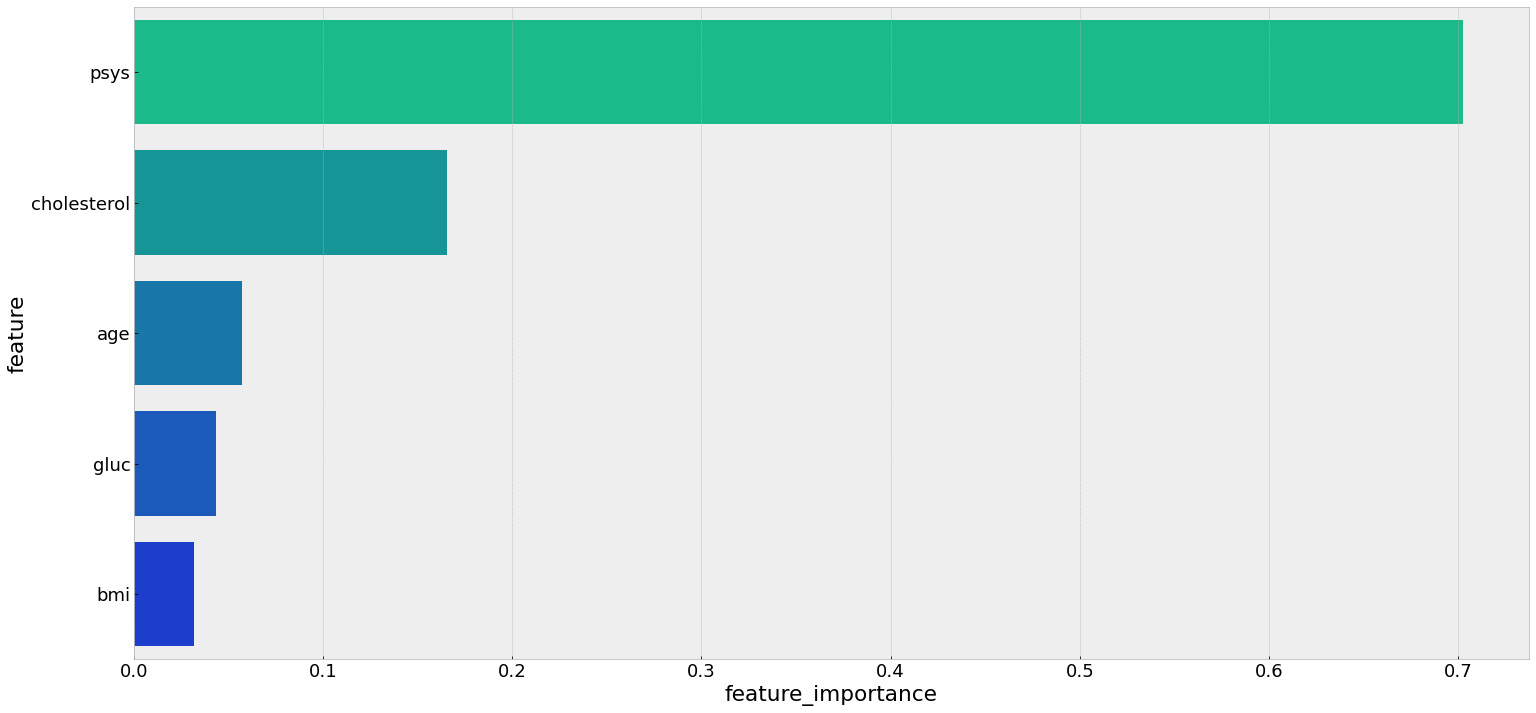

In [74]:
# Model training
xgb = XGBClassifier(random_state = 73)
xgb.fit(x_train, y_train)

# Feature importance
feat_imp = pd.DataFrame({'feature': x_train.columns,
                         'feature_importance': xgb.feature_importances_})
feat_imp = feat_imp.sort_values('feature_importance', ascending = False)
sns.barplot(x = 'feature_importance', y = 'feature', data = feat_imp, palette = 'winter_r')

# Prediction
pred_xgb = xgb.predict(x_test)

# Performance
xgb_performance = pd.DataFrame(['XGBoost classifier',
                                metrics.accuracy_score(y_test, pred_xgb),
                                metrics.precision_score(y_test, pred_xgb),
                                metrics.recall_score(y_test, pred_xgb),
                                metrics.f1_score(y_test, pred_xgb),
                                metrics.roc_auc_score(y_test, pred_xgb)]).T
xgb_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score', 'ROC-AUC']
xgb_performance

### 7.4.1 Cross-validation

In [13]:
xgb_performance_cv = cross_validation(x_train, y_train, 10, XGBClassifier(random_state = 73), 'XGBoost classifier', verbose = False)
xgb_performance_cv

C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:13] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:15] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:16] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:17] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,XGBoost classifier,0.73 +- 0.01,0.75 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.73 +- 0.01


## 7.5 Comparação da performance

### 7.5.1 Performance única

In [75]:
performance_comparison = pd.concat([logreg_performance, rf_performance, cat_performance, xgb_performance])
performance_comparison.sort_values('Accuracy', ascending = False)

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,XGBoost classifier,0.730906,0.756402,0.680321,0.716347,0.730851
0,CatBoost classifier,0.730834,0.755451,0.681778,0.716727,0.73078
0,Logistic Regression,0.721223,0.75656,0.651458,0.700086,0.721147
0,Random forest classifier,0.691008,0.698182,0.67172,0.684695,0.690987


### 7.5.2 Performance real | cross-validation

In [14]:
performance_comparison_cv = pd.concat([logreg_performance_cv, rf_performance_cv, cat_performance_cv, xgb_performance_cv])
performance_comparison_cv.sort_values('Accuracy', ascending = False)

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,Logistic regression,0.73 +- 0.01,0.75 +- 0.01,0.66 +- 0.01,0.7 +- 0.01,0.72 +- 0.01
0,CatBoost classifier,0.73 +- 0.01,0.75 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.73 +- 0.01
0,XGBoost classifier,0.73 +- 0.01,0.75 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.73 +- 0.01
0,Random forest classifier,0.69 +- 0.01,0.69 +- 0.01,0.67 +- 0.01,0.68 +- 0.01,0.69 +- 0.01


# 8 Ajuste fino dos hyperparâmetros

## 8.1 Método aleatório

In [22]:
params = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
          'learning_rate': [0.01, 0.03, 0.05],
          'max_depth': [3, 5, 7, 9],
          'subsample': [0.1, 0.5, 0.7],
          'colsample_bytree': [0.3, 0.7, 0.9],
          'min_child_weight': [3, 7, 11, 15]}
max_eval = 10

In [23]:
final_result = pd.DataFrame()

for i in range(max_eval):
    # Choose parameters
    hp = {k: random.choice(v) for k, v in params.items()}
    print(i, hp)
    
    # Model
    xgb_model = XGBClassifier(n_estimators = hp['n_estimators'],
                              learning_rate = hp['learning_rate'],
                              max_depth = hp['max_depth'],
                              subsample = hp['subsample'],
                              colsample_bytree = hp['colsample_bytree'],
                              min_child_weight = hp['min_child_weight'])
    
    # Performance
    result = cross_validation(x_train, y_train, 10, xgb_model, 'XGBoost classifier', verbose = False)
    final_result = pd.concat([final_result, result])
final_result.reset_index(drop = True)

0 {'n_estimators': 1700, 'learning_rate': 0.05, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 7}
[11:48:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifi

[11:49:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:29] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:49:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:51] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:51:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:51:39] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:52:04] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:52:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1 {'n_estimators': 3500, 'learning_rate': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
[11:52:48] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:54:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:56:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:57:44] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:59:16] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:00:47] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:02:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:03:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:05:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:07:03] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


2 {'n_estimators': 3000, 'learning_rate': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
[12:08:33] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifi

[12:09:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:09:48] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:10:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:03] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:43] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:13:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:13:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:14:16] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


3 {'n_estimators': 3500, 'learning_rate': 0.03, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 7}
[12:14:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:15:44] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:34] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:17:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:18:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:19:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:21:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:22:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:15] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


4 {'n_estimators': 2500, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
[12:24:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:31] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:45] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:21] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:57] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:28:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:29:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:29:47] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


5 {'n_estimators': 2500, 'learning_rate': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 11}
[12:30:24] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:32:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:33:15] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:35:09] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:36:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:01] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:37:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:55] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


6 {'n_estimators': 2500, 'learning_rate': 0.05, 'max_depth': 7, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
[12:39:52] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:40:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:41:01] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:41:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:42:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:42:44] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:52] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:44:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:45:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


7 {'n_estimators': 3000, 'learning_rate': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
[12:45:34] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:46:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:47:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:47:51] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:48:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:09] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:55] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:52:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


8 {'n_estimators': 1700, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
[12:53:13] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:50] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:09] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:46] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:55:04] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:55:23] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:55:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


9 {'n_estimators': 1700, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
[12:56:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:33] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:48] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:02] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:17] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:31] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:45] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,XGBoost classifier,0.73 +- 0.01,0.76 +- 0.01,0.65 +- 0.01,0.7 +- 0.01,0.72 +- 0.01
1,XGBoost classifier,0.72 +- 0.01,0.73 +- 0.01,0.68 +- 0.01,0.7 +- 0.01,0.72 +- 0.01
2,XGBoost classifier,0.73 +- 0.01,0.76 +- 0.01,0.65 +- 0.01,0.7 +- 0.01,0.72 +- 0.01
3,XGBoost classifier,0.73 +- 0.01,0.76 +- 0.01,0.65 +- 0.01,0.7 +- 0.01,0.72 +- 0.01
4,XGBoost classifier,0.73 +- 0.01,0.74 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.73 +- 0.01
5,XGBoost classifier,0.72 +- 0.01,0.74 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.72 +- 0.01
6,XGBoost classifier,0.72 +- 0.01,0.73 +- 0.01,0.68 +- 0.01,0.7 +- 0.01,0.72 +- 0.01
7,XGBoost classifier,0.73 +- 0.01,0.75 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.73 +- 0.01
8,XGBoost classifier,0.73 +- 0.01,0.75 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.73 +- 0.01
9,XGBoost classifier,0.73 +- 0.01,0.75 +- 0.01,0.68 +- 0.01,0.71 +- 0.01,0.73 +- 0.01


## 8.2 Modelo final

In [69]:
tuned_params = {'n_estimators': 1700,
                'learning_rate': 0.05,
                'max_depth': 7,
                'subsample': 0.5,
                'colsample_bytree': 0.3,
                'min_child_weight': 7}

C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:14:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,XGBoost classifier,0.724208,0.763284,0.649125,0.701591,0.724126


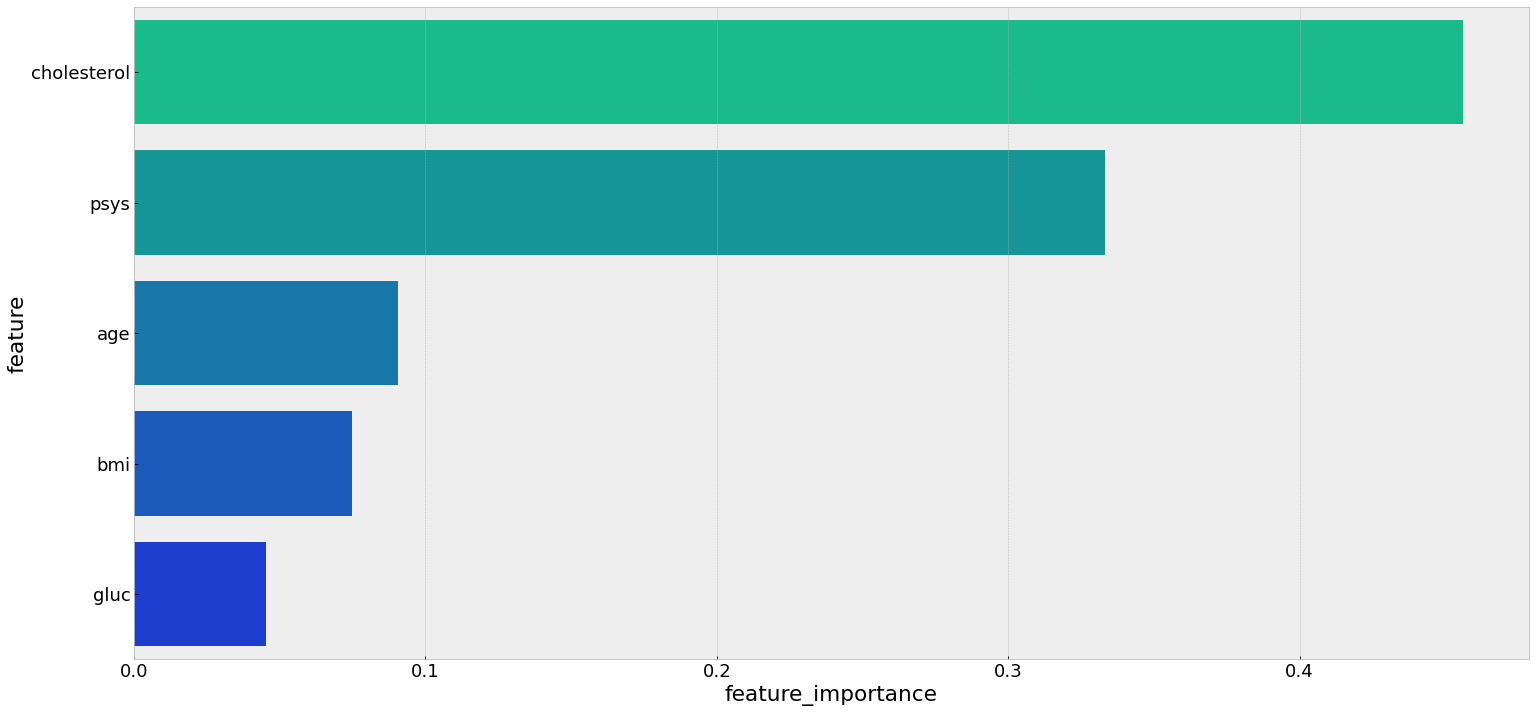

In [70]:
# Model training
xgb_model_tuned = XGBClassifier(n_estimators = tuned_params['n_estimators'],
                                learning_rate = tuned_params['learning_rate'],
                                max_depth = tuned_params['max_depth'],
                                subsample = tuned_params['subsample'],
                                colsample_bytree = tuned_params['colsample_bytree'],
                                min_child_weight = tuned_params['min_child_weight'])
xgb_model_tuned.fit(x_train, y_train)

# Feature importance
feat_imp = pd.DataFrame({'feature': x_train.columns,
                         'feature_importance': xgb_model_tuned.feature_importances_})
feat_imp = feat_imp.sort_values('feature_importance', ascending = False)
sns.barplot(x = 'feature_importance', y = 'feature', data = feat_imp, palette = 'winter_r')

# Prediction
pred_xgb_tuned = xgb_model_tuned.predict(x_test)

# Performance
xgb_tuned_performance = pd.DataFrame(['XGBoost classifier',
                                      metrics.accuracy_score(y_test, pred_xgb_tuned),
                                      metrics.precision_score(y_test, pred_xgb_tuned),
                                      metrics.recall_score(y_test, pred_xgb_tuned),
                                      metrics.f1_score(y_test, pred_xgb_tuned),
                                      metrics.roc_auc_score(y_test, pred_xgb_tuned)]).T
xgb_tuned_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score', 'ROC-AUC']
xgb_tuned_performance

In [15]:
# Salvando o modelo treinado
pickle.dump(xgb_model_tuned, open('model/cardio_model_tuned.pkl', 'wb'))

## 8.3 Cross-validation

In [13]:
xgb_model_tuned = XGBClassifier(n_estimators = tuned_params['n_estimators'],
                                learning_rate = tuned_params['learning_rate'],
                                max_depth = tuned_params['max_depth'],
                                subsample = tuned_params['subsample'],
                                colsample_bytree = tuned_params['colsample_bytree'],
                                min_child_weight = tuned_params['min_child_weight'])
tuned_performance_cv = cross_validation(x_train, y_train, 10, xgb_model_tuned, 'XGBoost classifier', verbose = False)
tuned_performance_cv

C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:23:50] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:24:06] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:24:29] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:24:51] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:25:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:25:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:25:57] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:26:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:26:39] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:27:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,XGBoost classifier,0.73 +- 0.01,0.76 +- 0.01,0.65 +- 0.01,0.7 +- 0.01,0.72 +- 0.01


# 9 Interpretação do erro

In [71]:
df9 = x_test.copy()
df9['cardio'] = y_test
df9['prediction'] = pred_xgb_tuned

In [73]:
df9.to_csv('data/interim/df9.csv', index = False)

In [51]:
df9 = pd.read_csv('data/interim/df9.csv')

C:\Users\lucas\Anaconda3\envs\cardio\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


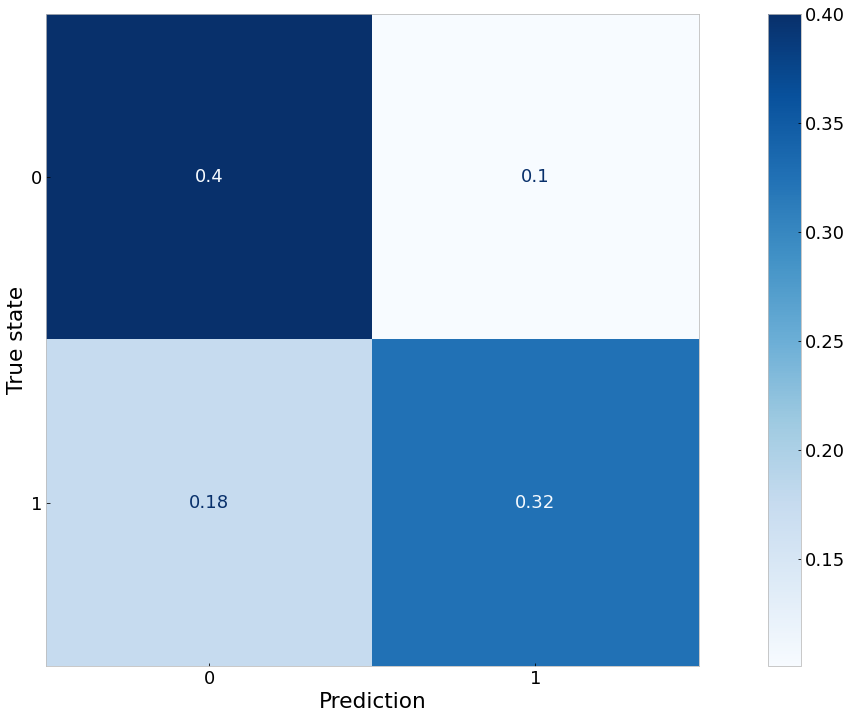

In [118]:
model = pickle.load(open('model/cardio_model_tuned.pkl', 'rb'))
xtest = df9[['psys', 'bmi', 'age', 'cholesterol', 'gluc']]
ytest = df9['cardio']
metrics.plot_confusion_matrix(model, xtest, ytest, cmap = 'Blues', normalize = 'all')
plt.xlabel('Prediction')
plt.ylabel('True state')
plt.grid(False)

In [119]:
pd.DataFrame({'Diagnosis': ['True', 'False negative', 'False positive'], 
              'Occurrence': ['72%', '18%', '10%']})

,Diagnosis,Occurrence
0,True,72%
1,False negative,18%
2,False positive,10%


In [88]:
y_true = df9['cardio']
y_pred = df9['prediction']
performance = pd.DataFrame([metrics.accuracy_score(y_true, y_pred),
                                      metrics.precision_score(y_true, y_pred),
                                      metrics.recall_score(y_true, y_pred),
                                      metrics.f1_score(y_true, y_pred),
                                      metrics.roc_auc_score(y_true, y_pred)]).T
performance.columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'ROC-AUC']
performance

,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.724208,0.763284,0.649125,0.701591,0.724126
